<a href="https://colab.research.google.com/github/Andrea987/advtrain-linreg/blob/main/notebooks/fig1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from re import VERBOSE
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.linear_model import lasso_path
from sklearn import datasets
from sklearn import linear_model
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tqdm
import cvxpy as cp
print(cp.installed_solvers())
import numpy as np

import traceback


def compute_q(p):
    if p != np.inf and p > 1:
        q = p / (p - 1)
    elif p == 1:
        q = np.inf
    else:
        q = 1
    return q


class AdversarialTraining:
    def __init__(self, X, y, S_dict, p):  # S is the matrix such that ||S^(-1) @ Dx||\leq delta. As a consequence, S appears in the unconstrained problem
        # S: (n, n) matrix, or S = np.concatenate(tS), with tS = [S1,..,S_m], so S is (n * m, n)
        m, n = X.shape
        q = compute_q(p)
        #print("who is X", X)
        #print("who is y", y)
        #print("who is S", S)
        #print("who is q in AdversarialTraining: ", q)
        #Formulate problem
        param = cp.Variable(n)
        #print("shape param ", param.shape)
        #print("dim ", n)
        print("X ", m, n)
        #print("S_dict ", S_dict)
        #print("S in adv training", S)
        print("nm ", n*m)
        S_dts = S_dict['S_dts']
        S_mis = S_dict['S_mis']
        adv_radius_times_scale_dts = cp.Parameter(name='adv_radius_times_scale_dts', nonneg=True)
        adv_radius_times_scale_mis = cp.Parameter(name='adv_radius_times_scale_mis', nonneg=True)
        #scale_dts = cp.Parameter(name='scale_dts', nonneg=True)
        #scale_mis = cp.Parameter(name='scale_mis', nonneg=True)
        print("S_mis in Adbvt training ", S_mis)
        if np.sum(S_mis * S_mis) == 0:
          print("no missing part")
          S = S_dts * adv_radius_times_scale_dts
        elif S_mis.shape == (m, n, n):
          S_dts_tiled = np.concatenate([S_dts] * m)
          S_mis_conc = np.concatenate(S_mis)
          #np.concatenate([yyy] * 2)
          S = S_dts_tiled * adv_radius_times_scale_dts + S_mis_conc * adv_radius_times_scale_mis
          print("S type ", type(S))
          #S = np.concatenate(S)
          print("S is a tensor, concatenated")
          print("final S after conc \n", S)

        if S.shape == (n, n):
          print("one matrix in input, S.shape = (n, n)")
          partial = S @ param  # should be (m * n,)
          param_norm = cp.pnorm(partial, p=q)
        elif S.shape == (n * m, n):  # should be a stack of matrices
          print("multiple matrices in input, S conc")
          partial = S @ param  # should be (m * n,)
          partial = cp.reshape(partial, (m, n), order='C')
          param_norm = cp.pnorm(partial, p=q, axis=1)
        else:
          print("--------> ERROR: NO MATRIX S FOUND IN ADVERSARIAL TRAINING")
        #elif S.shape == (m , n):  # stack of diagonal matrices
        #  print("multiple matrices in input, S_i diag")
          #S_cvx = cp.Constant(S)
        #  partial = cp.multiply(cp.Parameter(S), param)
        #  param_norm = cp.pnorm(partial, p=q, axis=1)
        abs_error = cp.abs(X @ param - y)
        adv_loss = 1 / m * cp.sum((abs_error + param_norm) ** 2)
        prob = cp.Problem(cp.Minimize(adv_loss))
        self.prob = prob
        self.adv_radius_times_scale_dts = adv_radius_times_scale_dts
        self.adv_radius_times_scale_mis = adv_radius_times_scale_mis
        #self.scale_dts = scale_dts
        #self.scale_mis = scale_mis
        self.param = param
        self.warm_start = False


    def __call__(self, dict_hyper_p, **kwargs):
        try:
            #print("dic thyper p ", dict_hyper_p)
            self.adv_radius_times_scale_dts.value = dict_hyper_p['adv_radius_times_scale_dts']
            self.adv_radius_times_scale_mis.value = dict_hyper_p['adv_radius_times_scale_mis']
            #self.scale_dts.value = dict_hyper_p['scale_dts
            #self.scale_mis.value = dict_hyper_p['scale_mis']
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v

'''
    def __call__(self, adv_radius, **kwargs):
        try:
            self.adv_radius.value = adv_radius
            self.prob.solve(warm_start=self.warm_start, solver=cp.CLARABEL, max_iter=10000, **kwargs)
            v = self.param.value
        except Exception as e:
          print("------------------> Error occurred:")
          traceback.print_exc()
          v = np.zeros(self.param.shape)
        #except:
        #    print("----------------------> you are in except")
        #    v = np.zeros(self.param.shape)
        return v
'''


def get_lasso_path(X, y, eps_lasso=1e-5):
    alphas, coefs, _ = lasso_path(X, y, eps=eps_lasso)
    coefs= np.concatenate([np.zeros([X.shape[1], 1]), coefs], axis=1)
    alphas = np.concatenate([1e2 * np.ones([1]), alphas], axis=0)
    return alphas, coefs, []


def get_path(X, y, estimator, amax, dts_max, mis_max, eps_amax=1e-5, eps_dts_max=1e-1, eps_mis_max=1e-1, n_alphas=25, n_deltas_dts=2, n_deltas_mis=2):
    _, m = X.shape
    amin = eps_amax * amax
    dts_min = eps_dts_max * dts_max
    mis_min = eps_mis_max * mis_max
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    dts_deltas = np.logspace(np.log10(dts_min), np.log10(dts_max), n_deltas_dts)
    mis_deltas = np.logspace(np.log10(mis_min), np.log10(mis_max), n_deltas_mis)
    #hyper_p = {'scale_dts': dts_deltas, 'scale_mis': mis_deltas}
    hyper_p_ret_ = []
    coefs_ = []
    for scale_dts_value in tqdm.tqdm(dts_deltas):
        for scale_mis_value in tqdm.tqdm(mis_deltas):
          #tuple_key = (scale_dts_value, scale_mis_value)
          #coefs_ = []
          for a in tqdm.tqdm(alphas):
              #dict_hyper_p_values = {'adv_radius': a, 'scale_dts': scale_dts_value, 'scale_mis': scale_mis_value}
              dict_hyper_p_values = {'adv_radius_times_scale_dts': a * scale_dts_value, 'adv_radius_times_scale_mis': a * scale_mis_value}
              coefs = estimator(X, y, dict_hyper_p_values)
              #print("alpha  ", a, "coef: ", coefs)
              coefs_.append(coefs if coefs is not None else np.zeros(m))
              hyper_p_ret_.append([a, scale_dts_value, scale_mis_value])
          #res[tuple_key] = np.stack((coefs_)).T
    return np.stack((hyper_p_ret_)).T, np.stack((coefs_)).T

'''
def get_path(X, y, estimator, amax, eps=1e-5, n_alphas=200):
    _, m = X.shape
    amin = eps * amax
    alphas = np.logspace(np.log10(amin), np.log10(amax), n_alphas)
    coefs_ = []
    for a in tqdm.tqdm(alphas):
        coefs = estimator(X, y, a)
        #print("alpha  ", a, "coef: ", coefs)
        coefs_.append(coefs if coefs is not None else np.zeros(m))
    return alphas, np.stack((coefs_)).T
'''


def plot_coefs(alphas, coefs, ax):
    #print("you are printing coefs in function of 1/alphas")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).sum(axis=0)
    ax.set_xlabel("1/alphas")
    ax.set_ylabel("coef")
    for coef_l, c in zip(coefs, colors):
        ax.semilogx(1/alphas, coef_l, c=c)
        #ax.semilogx(1/alphas, l1norm, c=c)
        #ax.plot(1/alphas, coef_l, c=c)


def plot_coefs_l1norm(coefs, ax):
    #print("you are printing coeff in function of l1 norm")
    colors = cycle(["b", "r", "g", "c", "k"])
    #l1norm = np.abs(coefs).mean(axis=0)
    l1norm = np.abs(coefs).sum(axis=0)
    #print("coef ", coefs)
    #print("l1norm ", l1norm)
    ax.set_xlabel("l1norm")
    ax.set_ylabel("coef")


    for coef_l, c in zip(coefs, colors):
        ax.plot(l1norm, coef_l, c=c)


def train_and_plot(X, y, S_dict, list_ax):
    linfadvtrain = AdversarialTraining(X, y, S_dict, p=np.inf)
    estimator = lambda X, y, dic_h:  linfadvtrain(dict_hyper_p=dic_h)
    hyper_p, coefs_advtrain_linf  = get_path(X, y, estimator, 1e2, 1e0, 1e0)
    #print("hyper_p used\n ", hyper_p)
    if len(list_ax) > 0:
      plot_coefs_l1norm(coefs_advtrain_linf, list_ax[0])
      plot_coefs(alphas_adv, coefs_advtrain_linf, list_ax[1])
    return hyper_p, coefs_advtrain_linf

'''
def add_rectangles_old(x, y, box_width, box_height, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)

  for xi, yi in zip(x[r_c], y[r_c]):
      rect = patches.Rectangle(
        (xi-box_width/2, yi-box_height/2),
        box_width, box_height,
        linewidth=1, edgecolor='r', facecolor='none'
      )
      ax.add_patch(rect)
'''

def add_rectangles(x, y, S, ax):
  r_c = (np.random.binomial(1, 1, size=x.size) == 1)  # 1 taken, 0 not taken
  #print(r_c)
  d = S.shape[-1]
  #S = S * 100
  if S.ndim == 2 or S.shape == (1, d, d):
    S = S.squeeze()
    print("------------------------> who is S in add_rectangles\n", S)
    box_width = S[0, 0]
    box_height = S[1, 1]
    for xi, yi in zip(x[r_c], y[r_c]):
        rect = patches.Rectangle(
          (xi-box_width/2, yi-box_height/2),
          box_width, box_height,
          linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
  else:  # S is something like (n, d, d)
    #print("---------------> who is S in add_rectangles (mult imp)\n", S)
    box_width = S[:, 0, 0]
    box_height = S[:, 1, 1]
    #print("bw\n ", box_width)
    #print("bh\n ", box_height)
    #print("------------------------------> boxes printed")
    for xi, yi, bw, bh in zip(x[r_c], y[r_c], box_width[r_c], box_height[r_c]):
        #print("bw, bh ", bw, ",   ", bh)
        rect = patches.Rectangle(
          (xi-bw/2, yi-bh/2),
          bw, bh, linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    ax.set_aspect('equal')



print("end block")


['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']
end block


In [34]:
# imputation's block

def clear_dataset(X, y, masks):
  # remove observations full NaN
  # X is an (n, d) matrix, y is a (n,) vector,
  # masks is an (n, d) binary matrix associated to X. 1 missing, 0 seen
  M = np.sum(1 - masks, axis=1) > 0
  M_col = np.sum(1 - masks, axis=0) > 0  # True if in the column there is at least one seen component
  if np.sum(M_col) < masks.shape[1]:
    print("Careful, there is one column full of nan")
  return X[M, :][:, M_col], y[M], masks[M, :][:, M_col]


def single_imputation(X_nan, impute_estimator):
    ice = IterativeImputer(estimator=impute_estimator)
    return ice.fit_transform(X_nan)


def multiple_imputation(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


def imputation_elliptic(mu, sigma, x, masks):
  # mu, mean elliptical distribution (,d)
  # sigma, cov matrix elliptical distribution (d, d)
  # x: dataset (n, d)
  # masks: mask data, 0 seen, 1 missing
  n, d = x.shape
  print(n, d)
  x_imp = x.copy()
  #print("x_imp clean", x_imp)
  for i in range(n):
    if not (masks[i, :] == 0).all():  # if we have at least one missing component
      #print("nbr : ", i)
      x_c = x[i, :]
      m_bool = (masks[i, :] == 0)  # True seen, False missing
      sigma_aa_inv = np.linalg.inv(sigma[m_bool, :][:, m_bool])
      sigma_ma = sigma[~m_bool, :][:, m_bool]
      mu_cond = mu[~m_bool] + sigma_ma @ sigma_aa_inv @ (x_c[m_bool] - mu[m_bool])
      x_imp[i, ~m_bool] = mu_cond
  return x_imp


def listwise_delection(X, masks):
  # masks: 1 missing, 0 seen
    M = np.sum(masks, axis=1) == 0  # zeros components are the one with full entries
    ret = X[M, :] if X.ndim == 2 else X[M]
    return ret


In [35]:
#np.random.seed(42)

#p_miss_2d = [0.2, 0.4, 0.4]
#beta_2d = np.array([0.5, 2])  # ground truth

from sklearn.datasets import make_moons, make_circles
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split

def generate_masks_2d(nbr_of_sample, p_missing):
    # nbr_of_sample is the number of masks
    # p_missing=[p00, p01, p10], where p00 is the probability of seeing both components,
    # p10 is the probability of seeing the right component, p01 is the probability of seeing the left component
    masks = np.zeros((nbr_of_sample, 2))
    v = np.random.choice(a=3, size=nbr_of_sample, p=p_missing)
    masks[v == 0, :] = np.array([0, 0])  # both seen
    masks[v == 1, :] = np.array([0, 1])  # left seen
    masks[v == 2, :] = np.array([1, 0])  # right seen
    return masks

def best_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  score = np.mean(r * r, axis=1)
  print("scores:  ", score)
  i_min = np.argmin(score)
  return coeff[:, i_min], score[i_min]

def best_idx_predictor(X, coeff, y):
  hat_y = (X @ coeff).T  # (n, d) @ (d, m) = (n, m)
  r = hat_y - y  # residual
  #score = np.mean(r * r, axis=1)
  score = np.mean(r * r, axis=1)
  #print("score in best idx", score)
  i_min = np.argmin(score)
  #### find the minimum value with a threshold, so we get bigger uncertainty set that are visible
  min = np.min(score)
  max = np.max(score)
  score[ score < min + 1e-2 ] = max
  ####
  #print("score after ", score)
  i_min = np.argmin(score)
  return i_min, score[i_min]



def generate_X(data, dim):
    if data == 'Gaussian':
      def generator(n):
        return np.random.randn(n, dim)
    elif data == 'Uniform':
      def generator(n):
        return np.random.rand(n, dim)
    elif data == 'moons':
      def generator(n):
        return make_moons(n, noise=0.1)[0]
    elif data == 'circles':
      def generator(n):
        return make_circles(n, noise=0.1, factor=0.4)[0]
    return generator


In [39]:
# experiment 2d with dataset generated externally

def imputations(info, dict_obs_for_imp):  # X_nan, y):
  # info contains the method and possible extra information
  # X_nan is the dataset with nan in place of the missing components
  # y is return as it is, unless the method require to change it, like in
  # listwise deletion
    #print(info)
    X_nan = dict_obs_for_imp['X_nan']
    y = dict_obs_for_imp['y_train']
    mask_from_X_nan = np.isnan(X_nan).astype(int)
    if info['imp_method'] == 'BR_si':  # Baeysian_Ridge_single_imputation
        X = single_imputation(X_nan, BayesianRidge())
    elif info['imp_method'] in  ['mi', 'mi_pure']:
        X = multiple_imputation(info['mi_nbr'], X_nan)
    elif info['imp_method'] == 'l_d':  # listwise_deletion
        #mask_from_X_nan = np.isnan(X_nan).astype(int)
        X = listwise_delection(X_nan, mask_from_X_nan)
        y = listwise_delection(y, mask_from_X_nan)
        if len(X) == 0:  # no elements left, add an artificial element
            X = np.zeros((1, X_nan.shape[-1]))
            y = np.zeros(1)
        mask_from_X_nan = np.zeros_like(X)
    elif info['imp_method'] == 'oracle':
        X = dict_obs_for_imp['X_train_masked'][0]
        mask_from_X_nan = np.zeros_like(X)
    else:
      print("-------------------> ERROR: WRONG KEYWORD (in imputations)")
    return X, y, mask_from_X_nan


def cov_strategy(info, dict_observations):
    X_imputed = dict_observations['X_imputed']
    X_nan = dict_observations['X_nan']
    masks = dict_observations['masks_after_imputation']
    print(np.sum(masks, axis=-1))
    if info['cov_strategy'] == 'sd':
      sd = np.std(X_imputed, axis=0)
      #print("sd in cov strategy ", sd)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'inv_sd':
      sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(1 / sd)
    elif info['cov_strategy'] == 'zero':
      #sd = np.std(X_imputed, axis=0)
      #S = np.diag(sd)  # check if here it is 1 / sd or sd. The intuition is that, small covariance means small boxes where the points can move
      S = np.zeros((X_imputed.shape[-1], X_imputed.shape[-1]))
    elif info['cov_strategy'] == 'eye':
      S = np.eye(X_imputed.shape[-1])
    elif info['cov_strategy'] == 'threshold':
      sd = np.std(X_imputed, axis=0)
      sd[sd < info['threshold']] = info['threshold']
      #S = np.diag(sd) The intuition is that, small covariance means small boxes where the points can move
      S = np.diag(sd)
    elif info['cov_strategy'] == 'std_nan':
      if info['imp_method'] in ['oracle']:
        print("DON'T USE std_nan with oracle and ld because you do not have any nan. Use sd")
      else:
        std_columnwise = np.nanstd(X_nan, axis=0)
        S = np.diag(std_columnwise)
    elif info['imp_method'] in ['mi_pure', 'mi']:  # Rubin's Rule
      if info['cov_strategy'] == 'std_mi':
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        S = np.diag(s_within)
        print("final S in cov strategy std_mi ", S)
      elif info['cov_strategy'] == 'RR':
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2)  # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d. That's already scaled because we are computing the std
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        print("final S in cov strategy RR ", S)
        #mu = np.mean(X_imputed, axis=0)
        #sigma = np.cov(X_imputed, rowvar=False)
      elif info['cov_strategy'] == 'RR_scaled (to check)':
        print("Rub Rule right scaled")
        #if info['mi_nbr'] == 1:
        #  X_imputed = np.array([X_imputed])
        # X shape = (m, n, d)
        std_vectors = np.std(X_imputed, axis=-2) # shape: (m, d)
        #print("std vectors ", std_vectors)
        s_within = np.mean(std_vectors, axis=0)  # within imputation variance  # shape : d
        print("s_within ", s_within)
        print("cov computed")
        #print(s_mean)
        s_between = np.std(std_vectors, axis=0) # between imputation variance  # shape: d
        #s_between = np.sqrt(s_between)
        print("s_between ", s_between)
        S = np.diag(s_within + s_between * (1 + 1 / info['mi_nbr']))
        #S = np.sqrt(S)
        print("final S in cov strategy RR ", S)
      #elif info['cov_strategy'] == 'cond_var':
        # we have imputed [X1,..,X_m]
        #s = np.std(X_imputed, axis=0)
        #print("s\n ", s)
        #eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        #S = eye * s[:, None, :]
        #S = np.concatenate(S, axis=0)
        #print("S in cond variance ", S)
    elif info['cov_strategy'] == 'lounici':
      mu = np.nanmean(X_nan, axis=0)
      print("means ", mu)
      delta = 1 - np.mean(masks) # parameter missingness
      print("delta ", delta)
      X_0 = np.nan_to_num(X_nan - mu)  # check if this is correct
      print("nbr obs", X_0.shape[0])
      S =  X_0.T @ X_0 / X_0.shape[0]
      S = (1/delta - 1/(delta**2)) * np.diag(np.diag(S)) + 1/(delta**2) * S
    else:
      raise ValueError("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #print("-------------> ERROR: NO COVARIANCE METHOD HAS BEEN CHOSEN")
      #S = np.diag(S)
      #mu = np.mean(X_imputed, axis=0)
      #sigma = np.cov(X_imputed, rowvar=False)
    return S


def cov_strategy_missing(info, dict_observations):
    # undertainty that come from the imputed part. It is zero
    X_imputed = dict_observations['X_imputed']
    if info['imp_method'] in ['mi', 'mi_pure']:
      if info['cov_strategy_between'] == 'cond_var':
        # we have imputed [X1,..,X_m], so shape (m, n, d)
        s = np.std(X_imputed, axis=0)
        s[s<1e-14] = 0  # set to zero values that are basically zero
        #print("var ", s)
        eye = np.array([np.eye(X_imputed.shape[-1])] * X_imputed.shape[-2])
        S_mis = eye * s[:, None, :]
    else:
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape[-1])
      print("shape oject in cov strategy missing ", dict_observations['X_test'].shape)
      d = dict_observations['X_test'].shape[-1]
      S_mis = np.zeros((d, d))
    return S_mis


def post_imputation(info_imp, dict_dataset):
  # X_imptued should be a matrix (n, d) or tensor (m, d, n) (in multiple imputations methods)
    X_imputed = dict_dataset['X_imputed']
    y_train = dict_dataset['y_from_X_imputed']
    #print("info imp in post_imp", info_imp)
    print("shape X_imputed in post_imputation ", X_imputed.shape)
    mask_train = dict_dataset['masks_after_imputation']
    if 'post_imp' not in info_imp.keys():
      X_train = X_imputed
    elif info_imp['post_imp'] == 'mean':
      #print("entered in pst_iputation, in mi_mean")
      X_train = np.mean(X_imputed, axis=0)
    elif info_imp['post_imp'] == 'conc':
      X_train = np.concatenate(X_imputed)
    else:
      X_train = X_imputed
    return X_train, y_train, mask_train


def generate_dataset(data, n_tot, dim, beta_gt, perc_test, p_miss, err):
    print(data)
    if data['data'] == 'Gaussian':
      X_complete = np.random.randn(n_tot, dim)
    elif data['data'] == 'Normal':
      #print("you are here")
      X_complete = np.random.multivariate_normal(mean=data['mean'], cov=data['cov'], size=n_tot)
    elif data['data'] == 'Uniform':
      X_complete = np.random.rand(n_tot, dim)
    elif data['data'] == 'moons':
      X_complete = make_moons(n_tot, noise=0.1)[0]
    elif data['data'] == 'circles':
      X_complete = make_circles(n_tot, noise=0.1, factor=0.4)[0]

    if err['type'] == 'Gaussian_on_y':
      #print("---> you have entered in GAUSSIAN ERROR ", "scaling : ", err['scaling'])
      error = np.random.randn(n_tot) * err['scaling']
    elif err['type'] == 'Uniform_on_y':
      error = (np.random.rand(n_tot)-0.5) * err['scaling']
    elif err['type'] == 'Gaussian_on_X':
      error = (np.random.randn(n_tot, dim) @ beta_gt) * err['scaling']  # error is of the form DX@beta_gt + error
    #elif err['type'] == 'Gaussian':
    #  error = np.random.randn(n_tot) * err['scaling']

    print(X_complete.shape)

    y_complete = X_complete @ beta_gt + error  #np.random.randn(n_tot) * err  # (np.random.rand(n_tot) - 0.5) * err
    X_train, X_test, y_train, y_test = train_test_split(X_complete, y_complete, test_size=perc_test)
    n_train = X_train.shape[0]
    masks_train = generate_masks_2d(n_train, p_miss)  # 1 missing, 0 observed
    #M = np.sum(masks, axis=1)  # M[i] > 0 iff i has missing component
    #dict_obs = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test, 'masks_train': masks_train}
    dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}#, 'masks_train': masks_train}
    return dict_obs


def experiment_2d_ext_dataset(dict_obs, dict_imp, ax):
    # dict_obs contains info on the observations, i.e. train, test, masks
    # dict_imp contains info on the imputation an covariance methods used,
    # dict_imp = {'imp_method': , 'cov_strategy': , .... }
    # ax contains info for the plots

    X_test = dict_obs['X_test']
    y_test = dict_obs['y_test']
    mask = dict_obs['X_train_masked'][1]

    M = np.sum(mask, axis=1)  # M[i] > 0 iff i has missing component

    X_nan_train = dict_obs['X_train_masked'][0].copy()
    oracle_sd = np.std(X_nan_train, axis=0)
    print("-------> ORACLE SD, std of the original dataset (with no missing)", oracle_sd)
    X_nan_train[mask == 1] = np.nan
    #print("dict imp -----> ", dict_imp)
    dict_obs = dict_obs | {'X_nan': X_nan_train} #, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    if len(dict_obs['imp_ds'][dict_imp['imp_method']]) == 0:  # no previous imputation has been done
      #results = imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      results = imputations(dict_imp, dict_obs)
      X_imputed, y_from_X_imputed, mask_from_X_imputed = results  # imputations(dict_imp, X_nan_train, dict_obs['y_train'])
      dict_obs['imp_ds'][dict_imp['imp_method']].append(results)
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    else:
      X_imputed, y_from_X_imputed, mask_from_X_imputed = dict_obs['imp_ds'][dict_imp['imp_method']][0]
      print("crush test-------------------------------------------------> ", np.sum(X_imputed))
    #print("X_imputed ", X_imputed)
    n_imputed, n_test = X_imputed.shape[-2], X_test.shape[-2]
    #print("X_train\n ", X_train)
    M = np.sum(mask_from_X_imputed, axis=1)  # M[i] > 0 iff i has missing component

    dict_obs = dict_obs | {'X_imputed': X_imputed, 'y_from_X_imputed': y_from_X_imputed, 'masks_after_imputation': mask_from_X_imputed}
    #  print(dict_obs)
    S_dataset = cov_strategy(dict_imp, dict_obs) * dict_imp['multip_dataset']
    print("S dataset \n", S_dataset)
    #  dict_obs = dict_obs | {'cov_within': S_within}
    S_missing = cov_strategy_missing(dict_imp, dict_obs)  * dict_imp['multip_missing']
    print("S missing shape\n ", S_missing.shape)
    print("S missing\n ", S_missing)
    #  dict_obs = dict_obs | {'cov_between': S_between}
    S_dict = {'S_dts': S_dataset, 'S_mis': S_missing}  #, 'multipliers_dts': dict_imp['multip_dataset'], 'multipliers_mis': dict_imp['multip_missing']}
    #if True:  # check what to do of this part later
      #S = S_dataset * dict_imp['multip_dataset'] + S_missing * dict_imp['multip_missing']
      #if S.ndim == 2:
      #  print("final S \n", S)


    #print("matrices S \n", S)
    #print("---....---....----....--> diag matrix: ", np.diag(S))

    #if dict_imp['imp_method'] == 'mi':  # prepare the training set in case of multiple imputation
    #  X_train = np.concatenate(X_train)  # X_train, if the method is mi, should be (mi_nbr, n, dim)
    #  y_train = np.tile(y_train, reps=dict_imp['mi_nbr'])
    #  mask_train = np.tile(mask_train, reps=(dict_imp['mi_nbr'], 1))
    #  M = np.sum(mask_train, axis=1)
    #print("final matrices (exp 2d ext run)\n ", S)
    X_train, y_train, mask_train = post_imputation(dict_imp, dict_obs)
    n_train = X_train.shape[-2]
    print("y_train length ", y_train.shape[0])
    print("-------> size test: ", n_test, " , size train: ", n_train, "nbr_seen (train): ", np.sum(M == 0), " nbr_miss : ", np.sum(M > 0))

#    plt.tight_layout()
    #S_between = S.copy()
    if dict_imp['imp_method'] == 'mi_pure':
      best_coeff = np.zeros(X_train.shape[-1])
      best_alpha = 0
      for i in range(dict_imp['mi_nbr']):
        print("i .-------------> ", i)
        dict_obs_i = {'X_imputed': X_train[i, :, :], 'X_nan': X_nan_train, 'masks': mask_train}
        dict_imp_new = {'imp_method': dict_imp['imp_method'], 'cov_strategy': dict_imp['cov_strategy_within']}
        S_within = cov_strategy(dict_imp_new, dict_obs_i)  # within the dataset
        #print("S_within ", S_within)
        S = S_within[None, :, :] + S_between
        S = np.concatenate(S, axis=0)
        #print(S)
        alphas_used, coeff_results = train_and_plot(X_train[i, :, :], y_train, S, [ax[1], ax[2]])
        idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
        best_coeff_partial, best_alpha_partial = coeff_results[:, idx_best], alphas_used[idx_best]
        print("best coeff partial ", best_coeff_partial)
        best_coeff += best_coeff_partial
        best_alpha += best_alpha_partial
        if len(ax) > 0:
          ax[0].scatter(X_train[i, M == 0, 0], X_train[i, M == 0, 1])
          ax[0].scatter(X_train[i, M == 1, 0], X_train[i, M == 1, 1])
          ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
          add_rectangles(X_train[i, :, 0], X_train[i, :, 1], S[0, 0] * best_alpha_partial, S[1, 1] * best_alpha_partial, ax[0])
        best_coeff /= dict_imp['mi_nbr']
      best_alpha /= dict_imp['mi_nbr']
    else:
      #alphas_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [ax[1], ax[2]])
      hyper_p_used, coeff_results = train_and_plot(X_train, y_train, S_dict, [])
      idx_best, min_score = best_idx_predictor(X_test, coeff_results, y_test)
      #best_coeff, best_alpha = coeff_results[:, idx_best], alphas_used[idx_best]
      #print("-----------------> shape hyper_p used ", hyper_p_used.shape)
      best_coeff, best_hyper_p = coeff_results[:, idx_best], hyper_p_used[:, idx_best]
      #print("hyper_p_used ", hyper_p_used.T)
      #input()
      #print(X_br_train[M == 0, 0])
      best_alpha, best_delta_dts, best_delta_mis = best_hyper_p[0], best_hyper_p[1], best_hyper_p[2]
      ax[0].scatter(X_train[M == 0, 0], X_train[M == 0, 1])
      ax[0].scatter(X_train[M == 1, 0], X_train[M == 1, 1])
      #ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', n_s: ' + str(np.sum(M == 0)) + " n_m: " + str(np.sum(M > 0)))  # n_s = nbr seen, n_m = nbr missing
      # 'multip_betw': 1, 'multip_with':1
      ax[0].set_title(dict_imp['imp_method'] + ', ' + dict_imp['cov_strategy'] + ', dts:'+str(dict_imp['multip_dataset']) + ', mis:' + str(dict_imp['multip_missing']) )  # n_s = nbr seen, n_m = nbr missing
      S_plot = (S_dict['S_dts'] * best_delta_dts + S_dict['S_mis'] * best_delta_mis) * best_alpha
      #print("S_plot ", S_plot)
      add_rectangles(X_train[:, 0], X_train[:, 1], S_plot, ax[0])
      ax[0].set_aspect('equal')  # equal proportion of the axis
    #print("X_train ", X_train)
    #print("y_train ", y_train)
    #print("mask_train ", mask_train)
    #print("M ", M)


    print("X_test shape, ", X_test.shape, ",   y_test shape ", y_test.shape)
    #print("X_test shape, ", X_test.shape)
    print("---------------------------------> best idx ", idx_best, " best hyperp [best_alpha, coef_dts, coef_mis]: ", best_hyper_p, ", min score ", min_score)
    print("---------------------------------> best coeff ", best_coeff)
    #input()
    #print("best 1/alpha ", 1 / best_alpha)
#    print("min score ", min_score)

    #
    #add_rectangles(X_train[:, 0], X_train[:, 1], S[0, 0] * best_alpha, S[1, 1] * best_alpha, ax[0])

    return best_coeff, min_score, -np.log10(best_alpha)



In [37]:

def run_experiments(dictio, methods_strategy):  # ---------------------> new
  # dictio: dictionary of lists that contains the parameters of generate_dataset.
  # Each list should have the same length
  # methods_strategy = list of dictionary, each one of the form
  # {'imp_method': .., 'cov_strategy':.., extra info}

    l = len(dictio['data'])
    m = len(methods_strategy)
    nbr_iter = len(methods_strategy)
    coeff_fin = np.zeros((nbr_iter, 2, l))
    scores_fin = np.zeros((nbr_iter, l))

    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l , 9 *l), num='advtrain_linf_')
    #fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(6 * l / 2, 9 *l / 2), num='advtrain_linf_')
    print(dictio['plots'])
    print(dictio['plots'][0])
    nbr_ima = len(dictio['plots'][0])
    if nbr_ima == 1:
      #nbr_ima = 1
      fig, ax = plt.subplots(nbr_ima * nbr_iter, l, figsize=(3 * l, 8/3 * m), squeeze=False)#, num='advtrain_linf_')
    elif nbr_ima == 3:  # == 3, one day should be more general
      #nbr_ima = 3
      fig, ax = plt.subplots(3 * nbr_iter, l, figsize=(3 * l, 8 * m), squeeze=False)#, num='advtrain_linf_')

    res = {}
    for info_imp_cov_dict in methods_strategy:
      key_list = []
      for value in info_imp_cov_dict.values():
        print(value)
        key_list.append(value)
      key_tuple = tuple(key_list)
      res[key_tuple] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}
      #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])] = {'best_coeff':[], 'l2_dist_best_coeff_gt':[], 'best_score':[], 'best_alpha':[]}

    if dictio['generation'] == 'fixed':  # use this if you want to fix the generated data, and not change at every iteartion
      dictio_obser_fixed = dict_obser = generate_dataset(data=dictio['data'][0],
                                    n_tot=dictio['n_tot'][0],
                                    dim=dictio['dim'][0],
                                    beta_gt=dictio['beta_gt'][0],
                                    perc_test=dictio['perc_test'][0],
                                    p_miss=dictio['p_miss'][0],
                                    err=dictio['err'][0])
      mask_no_both_seen = generate_masks_2d(dictio['n_train'][0], [0, 0.5, 0.5]) # generate a mask where there are no entries both seen. The idea then will be to consider percentage of this mask seen

    for i in range(l):
      print("---------------------------------------------------------------------------------------------------------------------------> iteration ", i)
      #  dict_obs = {'X_train_masked': (X_train, masks_train), 'X_test': ....., 'y_train': ....., 'y_test': ....}
      dict_obser_partial = generate_dataset(data=dictio['data'][i],
                                    n_tot=dictio['n_tot'][i],
                                    dim=dictio['dim'][i],
                                    beta_gt=dictio['beta_gt'][i],
                                    perc_test=dictio['perc_test'][i],
                                    p_miss=dictio['p_miss'][i],
                                    err=dictio['err'][i])
      if dictio['generation'] == 'fixed':
        dict_obser = dictio_obser_fixed
        #mask_partial = dict_obser_partial['X_train_masked'][1]
        p_i = dictio['p_miss'][i][0]  # probability of seen both component at round i
        n_train = mask_no_both_seen.shape[0]
        mask_partial = mask_no_both_seen.copy()
        mask_partial[0:int(n_train * p_i), :] = 0
        #mask_partial = mask_no_both_seen[0:int(n_train * p_i), :]
        tuple_partial = (dictio_obser_fixed['X_train_masked'][0], mask_partial)
        dict_obser['X_train_masked'] = tuple_partial
      else:
        dict_obser = dict_obser_partial

      #print("dict obser ", dict_obser)
      dict_obser = dict_obser | {'imp_ds':{'BR_si':[], 'l_d':[], 'oracle':[], 'mi':[]}}  # add an entry for imputed dataset
      for idx, info_imp_cov_dict in enumerate(methods_strategy):
        print("----------------------------------------------> new method tested: ", info_imp_cov_dict)
        coeff_round, score_round, alpha_round = experiment_2d_ext_dataset(dict_obser, info_imp_cov_dict, ax[(idx * nbr_ima):((idx+1) * nbr_ima), i])
        r = coeff_round - dictio['beta_gt'][i]
        l2_dist = np.linalg.norm(r)
        key_list = []
        for value in info_imp_cov_dict.values():
          print(value)
          key_list.append(value)
        key_tuple = tuple(key_list)
        res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
        res[key_tuple]['best_coeff'].append(coeff_round)
        res[key_tuple]['best_score'].append(score_round)
        res[key_tuple]['best_alpha'].append(alpha_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['l2_dist_best_coeff_gt'].append(l2_dist)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_coeff'].append(coeff_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_score'].append(score_round)
        #res[(info_imp_cov_dict['imp_method'], info_imp_cov_dict['cov_strategy'])]['best_alpha'].append(alpha_round)
    plt.tight_layout()
    return res


def plot_res(x_axis_info, res, extra_info):
  x_axis = x_axis_info['vector']
  print("x_axis for print in plot_res----> ", x_axis)
  l = len(x_axis)
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')
  positions = range(l)

  for key, values in res.items():
    print("key ", key, ": ", values)
    #print("values ", values)
  #print("res\n ", res)

  ch = ['o', 'x', '+', '*', '<', '>', 'p', 'D', 'd', 'v']
  lb = ['l2_dist_best_coeff_gt', 'best_score', 'best_alpha']
  for i in range(3):
    for idx, (key, dictio) in enumerate(res.items()):
      #print(dictio)
      ax_res[i].plot(positions, dictio[lb[i]], marker=ch[idx], label=str(key))  # the marker is linked to the key (= method), different key correspond to different marker
      #ax_res[1].plot(positions, dictio[lb[idx]], marker=ch[idx], label=str(key))
      #ax_res[2].plot(positions, -np.log(dictio['best_alpha']), marker=ch[idx], label=str(key))
      #ax_res[0].xticks(positions, n_tot)  # Set custom labels for the x-axis
    ax_res[i].set_xticks(positions)         # Set the tick positions
    ax_res[i].set_xticklabels(x_axis)        # Set the labels at those positions
    ax_res[i].set_xlabel(x_axis_info['name'])
    #ax_res[i].legend(loc='upper center', bbox_to_anchor=(1, 1))
    ax_res[i].legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
  ax_res[0].set_ylabel("||hat_Beta - Beta^*||_2")
  ax_res[1].set_ylabel("||hat_y - y||_2^2 / n_test")
  dict_err = extra_info['err'][0]
  #size_train = extra_info['n_tot'][0]
  ax_res[0].set_title("")
  n_test = extra_info['n_test'][0]
  #ax_res[1].set_title("err: " + dict_err['type'] + ", scale: " + str(dict_err['scaling'])  + ", n_test: " + str(n_test))
  ax_res[1].set_title("n_test: " + str(n_test))
  ax_res[2].set_ylabel("-log10(alpha)")
  plt.tight_layout()


def make_dictionary_data(nbr_experiments, n_train, n_test, data, beta_gt, p_miss, err_vector, plots):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  if isinstance(n_train, int):  # in case n_train is just a number
    n_train = [n_train] * nbr_experiments
  else:  # should be a list of integer
    print("change nbr_experiments to match the size of n_train")
    nbr_experiments = len(n_train)
  if isinstance(n_test, int):  # in case n_test is just a number
    n_test = [n_test] * nbr_experiments
  n_tot = [x + y for x, y in zip(n_train, n_test)]
  perc_test = [x / (x+y) for x, y in zip(n_test, n_train)]
  dim = beta_gt.size

  list_errors = []
  for i in range(nbr_experiments):
    err_dic_app = {'type': err_vector[0], 'scaling': err_vector[1][i]}
    list_errors.append(err_dic_app)

  dictio = {'data':[data] * nbr_experiments,
        'n_tot': n_tot,
        'n_train': n_train,
        'n_test': n_test,
        'dim': [dim] * nbr_experiments,
        'beta_gt': [beta_gt] * nbr_experiments,
        'perc_test': perc_test,
        #'p_miss': [p_miss] * nbr_experiments,
        'err': list_errors,
        'plots': [plots] * nbr_experiments
        }
  dictio['p_miss'] = p_miss

  return dictio

def make_probabilities(list_prob):
  l = []
  for x in list_prob:
    l.append([x, 0.5 - x/2, 0.5 - x/2])
  return l

def make_info_axis(vector, name):
  if name == 'train':
    dictio = {'name': 'size train set', 'vector': vector}
  elif name == 'p_seen':
    dictio = {'name': 'probability seen full entries', 'vector': vector}
  elif name == 'error':
    dictio = {'name': 'error', 'vector': vector}
  else:
    print("wrong info_axis")
  return dictio

def make_dictionary_method(list_meth):
  # make a dictionary where each element is a list of nbr_experiments element made by the other element of the function
  list_dictio=[]
  list_key = ['imp_method', 'cov_strategy', 'mi_nbr']
  for meth in list_meth:
    dictio_imp = {}
    for i in range(len(meth)):
      dictio_imp[list_key[i]] = meth[i] #= {list_key[i]: meth[i]}
      #print(dictio_imp)
    list_dictio.append(dictio_imp)
  return list_dictio



change nbr_experiments to match the size of n_train
data :  {'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
n_tot :  20050
n_train :  50
n_test :  20000
dim :  2
beta_gt :  [-0.5  2. ]
perc_test :  0.9975062344139651
err :  {'type': 'Gaussian_on_y', 'scaling': 2.5}
plots :  ['points']
p_miss :  [1, 0.0, 0.0]
generation :  f
[{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}, {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}, {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}]
imp_method :  BR_si
cov_strategy :  std_nan
multip_dataset :  1
multip_missing :  1
imp_method :  l_d
cov_strategy :  std_nan
multip_dataset :  1
multip_missing :  1
imp_method :  oracle
cov_strategy :  sd
multip_dataset :  1
multip_missing :  1
----> Starting experiments
[['points'], ['points'], ['points'], ['points'], ['points']]
['points']
BR_si
s

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 284.19it/s]


100%|██████████| 25/25 [00:00<00:00, 254.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 313.02it/s]


100%|██████████| 25/25 [00:00<00:00, 316.43it/s]

100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


------------------------> who is S in add_rectangles
 [[0.00560994 0.        ]
 [0.         0.00457579]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.04641589 0.1        0.1       ] , min score  6.717358165808782
---------------------------------> best coeff  [-0.57892663  1.32452666]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -0.07874165238032525
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.20862402 0.        ]
 [0.         0.98582381]]
shape oject in cov strategy missing  2
sh

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 201.96it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.64it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 185.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 187.01it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.08it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 183.41it/s]

100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


------------------------> who is S in add_rectangles
 [[0.00560994 0.        ]
 [0.         0.00457579]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.04641589 0.1        0.1       ] , min score  6.717358165808782
---------------------------------> best coeff  [-0.57892663  1.32452666]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -0.07874165238032525
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.20862402 0.        ]
 [0.         0.98582381]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 141.16it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.54it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 203.37it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.03it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.43it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 201.67it/s]

100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


------------------------> who is S in add_rectangles
 [[0.00560994 0.        ]
 [0.         0.00457579]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.04641589 0.1        0.1       ] , min score  6.717358165808782
---------------------------------> best coeff  [-0.57892663  1.32452666]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  0.5752727890702832
[0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 148.86it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 209.16it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 183.63it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.16it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 202.09it/s]

100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


------------------------> who is S in add_rectangles
 [[0.00523204 0.        ]
 [0.         0.00416422]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00421697 1.         0.1       ] , min score  6.746555238550334
---------------------------------> best coeff  [-0.58447166  1.30097734]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  3.3501542347616793
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.24071125 0.        ]
 [0.         0.9874917 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missin

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 265.09it/s]


100%|██████████| 25/25 [00:00<00:00, 330.27it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 326.09it/s]


100%|██████████| 25/25 [00:00<00:00, 338.05it/s]

100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


------------------------> who is S in add_rectangles
 [[0.00845287 0.        ]
 [0.         0.0067277 ]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.712948627078979
---------------------------------> best coeff  [-0.6496913   1.31223573]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -0.07874165238032525
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.20862402 0.        ]
 [0.         0.98582381]]
shape oject in cov strategy missing  2
shape

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 228.84it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.87it/s]

100%|██████████| 25/25 [00:00<00:00, 259.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 321.61it/s]


100%|██████████| 25/25 [00:00<00:00, 316.37it/s]

100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


------------------------> who is S in add_rectangles
 [[0.00560994 0.        ]
 [0.         0.00457579]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.04641589 0.1        0.1       ] , min score  6.717358165808782
---------------------------------> best coeff  [-0.57892663  1.32452666]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -3.5529770496184696
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 263.26it/s]


100%|██████████| 25/25 [00:00<00:00, 294.20it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 279.62it/s]


100%|██████████| 25/25 [00:00<00:00, 297.30it/s]

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


------------------------> who is S in add_rectangles
 [[0.00529693 0.        ]
 [0.         0.00421281]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00421697 1.         0.1       ] , min score  6.711602875587031
---------------------------------> best coeff  [-0.60515866  1.32236184]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -0.8094419672853155
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.25609923 0.        ]
 [0.         0.99901521]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 285.54it/s]


100%|██████████| 25/25 [00:00<00:00, 389.07it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 293.05it/s]


100%|██████████| 25/25 [00:00<00:00, 382.18it/s]

100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


------------------------> who is S in add_rectangles
 [[0.00360875 0.        ]
 [0.         0.00287016]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 0.1        0.1       ] , min score  7.186620711581104
---------------------------------> best coeff  [-0.33027112  1.13396767]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -0.07874165238032525
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.20862402 0.        ]
 [0.         0.98582381]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 220.95it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.59it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 292.17it/s]


100%|██████████| 25/25 [00:00<00:00, 289.40it/s]

100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


------------------------> who is S in add_rectangles
 [[0.00560994 0.        ]
 [0.         0.00457579]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.04641589 0.1        0.1       ] , min score  6.717358165808782
---------------------------------> best coeff  [-0.57892663  1.32452666]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -12.28766807680026
[0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 260.92it/s]


100%|██████████| 25/25 [00:00<00:00, 323.49it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 318.91it/s]


100%|██████████| 25/25 [00:00<00:00, 271.92it/s]

100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


------------------------> who is S in add_rectangles
 [[0.00954362 0.        ]
 [0.         0.00735009]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 0.1        0.1       ] , min score  6.694251756360067
---------------------------------> best coeff  [-1.22907017e-08  1.74106152e+00]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -3.925760080232072
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.2726627  0.        ]
 [0.         0.98015054]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 305.59it/s]


100%|██████████| 25/25 [00:00<00:00, 401.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 383.77it/s]


100%|██████████| 25/25 [00:00<00:00, 396.89it/s]

100%|██████████| 2/2 [00:00<00:00,  6.44it/s]


------------------------> who is S in add_rectangles
 [[0.00867055 0.        ]
 [0.         0.00667769]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.506524322958077
---------------------------------> best coeff  [0.01713134 2.0747083 ]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -0.07874165238032525
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.20862402 0.        ]
 [0.         0.98582381]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 200.34it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.80it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 320.36it/s]


100%|██████████| 25/25 [00:00<00:00, 311.93it/s]

100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


------------------------> who is S in add_rectangles
 [[0.00560994 0.        ]
 [0.         0.00457579]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.04641589 0.1        0.1       ] , min score  6.717358165808782
---------------------------------> best coeff  [-0.57892663  1.32452666]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -7.8466429979706565
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 224.73it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 305.64it/s]


100%|██████████| 25/25 [00:00<00:00, 312.14it/s]

100%|██████████| 2/2 [00:00<00:00,  5.05it/s]


------------------------> who is S in add_rectangles
 [[0.04160327 0.        ]
 [0.         0.03259095]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 0.1        0.1       ] , min score  7.12499157254204
---------------------------------> best coeff  [5.02203685e-04 1.40198978e+00]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -0.9410478071872387
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.31561098 0.        ]
 [0.         1.03061643]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 334.15it/s]


100%|██████████| 25/25 [00:00<00:00, 471.03it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 404.81it/s]


100%|██████████| 25/25 [00:00<00:00, 465.88it/s]

100%|██████████| 2/2 [00:00<00:00,  6.96it/s]


------------------------> who is S in add_rectangles
 [[0.09865691 0.        ]
 [0.         0.07728533]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.795692692828749
---------------------------------> best coeff  [0.09716396 1.76388989]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.20862402 0.98582381]
crush test------------------------------------------------->  -0.07874165238032525
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.20862402 0.        ]
 [0.         0.98582381]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 205.78it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.02it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 255.98it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.85it/s]

100%|██████████| 2/2 [00:00<00:00,  4.81it/s]


------------------------> who is S in add_rectangles
 [[0.00560994 0.        ]
 [0.         0.00457579]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  8  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.04641589 0.1        0.1       ] , min score  6.717358165808782
---------------------------------> best coeff  [-0.57892663  1.32452666]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.57892663,  1.32452666]), array([-0.58447166,  1.30097734]), array([-0.60515866,  1.32236184]), array([-1.22907017e-08,  1.74106152e+00]), array([5.02203685e-04, 1.40198978e+00])], 'l2_dist_best_coeff_gt': [np.float64(0.6800688557087453), np.float64(0.7041080413997919), np.float64(0.6857490923442399), np.float64(0.563071151702313), np.float64(0.7798196469166225)], 'best_score': [np.float64(6.717358165808782), np.float64(6.746555238550334), np.float64(6.711602875587031), 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 220.57it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 295.78it/s]


100%|██████████| 25/25 [00:00<00:00, 295.80it/s]

100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


------------------------> who is S in add_rectangles
 [[0.01056035 0.        ]
 [0.         0.01261309]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.50252098507942
---------------------------------> best coeff  [-0.08617591  2.13552637]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.27246747687528144
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.95942676 0.        ]
 [0.         1.14592126]]
shape oject in cov strategy missing  2
sh

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 235.15it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.92it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 294.55it/s]


100%|██████████| 25/25 [00:00<00:00, 289.26it/s]

100%|██████████| 2/2 [00:00<00:00,  5.12it/s]


------------------------> who is S in add_rectangles
 [[0.01056035 0.        ]
 [0.         0.01261309]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.50252098507942
---------------------------------> best coeff  [-0.08617591  2.13552637]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.27246747687528144
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.95942676 0.        ]
 [0.         1.14592126]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 233.77it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.88it/s]

100%|██████████| 25/25 [00:00<00:00, 253.76it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 292.54it/s]


100%|██████████| 25/25 [00:00<00:00, 294.98it/s]

100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


------------------------> who is S in add_rectangles
 [[0.01056035 0.        ]
 [0.         0.01261309]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.50252098507942
---------------------------------> best coeff  [-0.08617591  2.13552637]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.43168580949945945
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 238.70it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.02it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 289.55it/s]


100%|██████████| 25/25 [00:00<00:00, 306.13it/s]

100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


------------------------> who is S in add_rectangles
 [[0.00696079 0.        ]
 [0.         0.00790486]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.543088428899808
---------------------------------> best coeff  [-0.03428285  2.11843233]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  0.35228265338414744
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.0217037 0.       ]
 [0.        1.1602744]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 266.66it/s]


100%|██████████| 25/25 [00:00<00:00, 343.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 275.25it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.85it/s]

100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


------------------------> who is S in add_rectangles
 [[0.01124583 0.        ]
 [0.         0.01277107]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.486001834486733
---------------------------------> best coeff  [-0.117246    2.08562343]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.27246747687528144
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.95942676 0.        ]
 [0.         1.14592126]]
shape oject in cov strategy missing  2
shape

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 283.30it/s]


100%|██████████| 25/25 [00:00<00:00, 328.02it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 292.29it/s]


100%|██████████| 25/25 [00:00<00:00, 293.35it/s]

100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


------------------------> who is S in add_rectangles
 [[0.01056035 0.        ]
 [0.         0.01261309]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.50252098507942
---------------------------------> best coeff  [-0.08617591  2.13552637]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.15384764610420404
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 206.59it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.03it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 301.09it/s]


100%|██████████| 25/25 [00:00<00:00, 294.25it/s]

100%|██████████| 2/2 [00:00<00:00,  4.89it/s]


------------------------> who is S in add_rectangles
 [[0.05169434 0.        ]
 [0.         0.05326958]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.51089698 0.1        0.1       ] , min score  6.541859037542293
---------------------------------> best coeff  [-0.21901086  2.44839663]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.7202017910936829
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.01183488 0.        ]
 [0.         1.04266771]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 298.84it/s]


100%|██████████| 25/25 [00:00<00:00, 365.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 328.20it/s]


100%|██████████| 25/25 [00:00<00:00, 379.26it/s]

100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


------------------------> who is S in add_rectangles
 [[0.21799322 0.        ]
 [0.         0.22463595]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.15443469 0.1        0.1       ] , min score  6.554065573859502
---------------------------------> best coeff  [-0.03453824  2.30732016]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.27246747687528144
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.95942676 0.        ]
 [0.         1.14592126]]
shape oject in cov strategy missing  2
shape

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 215.23it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.36it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 176.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.90it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.73it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 181.25it/s]

100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


------------------------> who is S in add_rectangles
 [[0.01056035 0.        ]
 [0.         0.01261309]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.50252098507942
---------------------------------> best coeff  [-0.08617591  2.13552637]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -3.298873147346786
[0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 181.08it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.96it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 193.43it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 193.43it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.53it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 201.79it/s]

100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


------------------------> who is S in add_rectangles
 [[0.08431945 0.        ]
 [0.         0.08856609]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.82540419 0.1        0.1       ] , min score  6.61477227571897
---------------------------------> best coeff  [0.05460243 2.26002568]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.9323180716392496
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.0215535  0.        ]
 [0.         1.07300266]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 230.71it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.88it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 255.15it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.83it/s]

100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


------------------------> who is S in add_rectangles
 [[0.35557219 0.        ]
 [0.         0.3734801 ]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.48070059 0.1        0.1       ] , min score  6.584690866931315
---------------------------------> best coeff  [2.92575457e-12 2.05985110e+00]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.27246747687528144
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.95942676 0.        ]
 [0.         1.14592126]]
shape oject in cov strategy missing  2

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 179.17it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.68it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 207.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 187.62it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.33it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 168.47it/s]

100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


------------------------> who is S in add_rectangles
 [[0.01056035 0.        ]
 [0.         0.01261309]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.50252098507942
---------------------------------> best coeff  [-0.08617591  2.13552637]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -6.3991971213869805
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 154.53it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 180.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 161.93it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 167.98it/s]

100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


------------------------> who is S in add_rectangles
 [[0.07600041 0.        ]
 [0.         0.0768613 ]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.409187746854562
---------------------------------> best coeff  [-0.46125076  2.21370303]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  1.924688429534417
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.01348174 0.        ]
 [0.         1.02496191]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in pos

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 177.00it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.74it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 307.34it/s]


100%|██████████| 25/25 [00:00<00:00, 424.01it/s]

100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


------------------------> who is S in add_rectangles
 [[0.07600041 0.        ]
 [0.         0.0768613 ]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.608298272693283
---------------------------------> best coeff  [1.76436522e-08 1.99111058e+00]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.95942676 1.14592126]
crush test------------------------------------------------->  -0.27246747687528144
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.95942676 0.        ]
 [0.         1.14592126]]
shape oject in cov strategy missing  2

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 203.61it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.93it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 300.75it/s]


100%|██████████| 25/25 [00:00<00:00, 305.26it/s]

100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


------------------------> who is S in add_rectangles
 [[0.01056035 0.        ]
 [0.         0.01261309]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.50252098507942
---------------------------------> best coeff  [-0.08617591  2.13552637]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.08617591,  2.13552637]), array([-0.03428285,  2.11843233]), array([-0.21901086,  2.44839663]), array([0.05460243, 2.26002568]), array([-0.46125076,  2.21370303])], 'l2_dist_best_coeff_gt': [np.float64(0.4354512314382292), np.float64(0.4805399896982191), np.float64(0.5291639007519996), np.float64(0.612533431660928), np.float64(0.21718767649605672)], 'best_score': [np.float64(6.50252098507942), np.float64(6.543088428899808), np.float64(6.541859037542293), np.float64(6.614

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 263.52it/s]


100%|██████████| 25/25 [00:00<00:00, 312.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 253.72it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.80it/s]

100%|██████████| 2/2 [00:00<00:00,  5.11it/s]


------------------------> who is S in add_rectangles
 [[0.02819108 0.        ]
 [0.         0.02779764]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 1.         0.1       ] , min score  6.36713662231999
---------------------------------> best coeff  [-0.60724023  1.77156468]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -8.854817396506293
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.98124717 0.        ]
 [0.         0.96755272]]
shape oject in cov strategy missing  2
shap

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 199.97it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 296.23it/s]


100%|██████████| 25/25 [00:00<00:00, 321.87it/s]

100%|██████████| 2/2 [00:00<00:00,  4.82it/s]


------------------------> who is S in add_rectangles
 [[0.02819108 0.        ]
 [0.         0.02779764]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 1.         0.1       ] , min score  6.36713662231999
---------------------------------> best coeff  [-0.60724023  1.77156468]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -8.854817396506293
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.98124717 0.        ]
 [0.         0.96755272]]
shape oject in cov strategy missing  2
shape oj

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 208.43it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.95it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 266.69it/s]


100%|██████████| 25/25 [00:00<00:00, 302.34it/s]

100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


------------------------> who is S in add_rectangles
 [[0.02819108 0.        ]
 [0.         0.02779764]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 1.         0.1       ] , min score  6.36713662231999
---------------------------------> best coeff  [-0.60724023  1.77156468]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -10.788930258103276
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 230.65it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.75it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 220.25it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 270.05it/s]


100%|██████████| 25/25 [00:00<00:00, 308.44it/s]

100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


------------------------> who is S in add_rectangles
 [[0.01103519 0.        ]
 [0.         0.01090997]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.463094132977024
---------------------------------> best coeff  [-0.68986848  1.58788053]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -6.561638830027237
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.00256633 0.        ]
 [0.         0.99118984]]
shape oject in cov strategy missing  2
shape oject in cov strategy missin

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 260.95it/s]


100%|██████████| 25/25 [00:00<00:00, 339.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 292.62it/s]


100%|██████████| 25/25 [00:00<00:00, 338.89it/s]

100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


------------------------> who is S in add_rectangles
 [[0.01962365 0.        ]
 [0.         0.01940097]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 0.1        0.1       ] , min score  6.554208714308798
---------------------------------> best coeff  [-0.89299499  1.51291736]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -8.854817396506293
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.98124717 0.        ]
 [0.         0.96755272]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.30it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.29it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 242.70it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 250.08it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.62it/s]

100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


------------------------> who is S in add_rectangles
 [[0.02819108 0.        ]
 [0.         0.02779764]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 1.         0.1       ] , min score  6.36713662231999
---------------------------------> best coeff  [-0.60724023  1.77156468]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -6.915170608515136
[0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 266.80it/s]


100%|██████████| 25/25 [00:00<00:00, 296.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 252.61it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.67it/s]

100%|██████████| 2/2 [00:00<00:00,  5.03it/s]


------------------------> who is S in add_rectangles
 [[0.01064794 0.        ]
 [0.         0.0113067 ]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.3663760196647
---------------------------------> best coeff  [-0.52609355  1.78719972]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -2.0836259503806405
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.96738364 0.        ]
 [0.         1.02723352]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
 

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 290.87it/s]


100%|██████████| 25/25 [00:00<00:00, 355.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 250.56it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.58it/s]

100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


------------------------> who is S in add_rectangles
 [[0.00659071 0.        ]
 [0.         0.00699846]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.819867179357122
---------------------------------> best coeff  [-0.95409942  1.2396527 ]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -8.854817396506293
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.98124717 0.        ]
 [0.         0.96755272]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.05it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.39it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 266.20it/s]


100%|██████████| 25/25 [00:00<00:00, 285.27it/s]

100%|██████████| 2/2 [00:00<00:00,  4.61it/s]


------------------------> who is S in add_rectangles
 [[0.02819108 0.        ]
 [0.         0.02779764]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 1.         0.1       ] , min score  6.36713662231999
---------------------------------> best coeff  [-0.60724023  1.77156468]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -2.167015363913412
[0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 238.85it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.85it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 235.71it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.02it/s]

100%|██████████| 2/2 [00:00<00:00,  4.67it/s]


------------------------> who is S in add_rectangles
 [[0.00615407 0.        ]
 [0.         0.00726225]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.524441992232013
---------------------------------> best coeff  [-0.44199656  1.57911818]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -0.702068366444542
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.90329426 0.        ]
 [0.         1.06595213]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 260.95it/s]


100%|██████████| 25/25 [00:00<00:00, 385.26it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 332.85it/s]


100%|██████████| 25/25 [00:00<00:00, 372.72it/s]

100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


------------------------> who is S in add_rectangles
 [[0.00380916 0.        ]
 [0.         0.00449508]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00421697 1.         0.1       ] , min score  7.171535880577972
---------------------------------> best coeff  [-0.94393642  0.9870898 ]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -8.854817396506293
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.98124717 0.        ]
 [0.         0.96755272]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 217.22it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.16it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 268.94it/s]


100%|██████████| 25/25 [00:00<00:00, 297.18it/s]

100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


------------------------> who is S in add_rectangles
 [[0.02819108 0.        ]
 [0.         0.02779764]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 1.         0.1       ] , min score  6.36713662231999
---------------------------------> best coeff  [-0.60724023  1.77156468]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -7.900460035158873
[0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 266.49it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 273.87it/s]


100%|██████████| 25/25 [00:00<00:00, 275.02it/s]

100%|██████████| 2/2 [00:00<00:00,  5.04it/s]


------------------------> who is S in add_rectangles
 [[0.01051694 0.        ]
 [0.         0.01200776]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12115277 0.1        0.1       ] , min score  6.35878680763656
---------------------------------> best coeff  [-0.32046873  2.07075331]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -1.4017376553245704
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.86807273 0.        ]
 [0.         0.99112547]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 287.96it/s]


100%|██████████| 25/25 [00:00<00:00, 406.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 353.64it/s]


100%|██████████| 25/25 [00:00<00:00, 395.39it/s]

100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


------------------------> who is S in add_rectangles
 [[0.11575936 0.        ]
 [0.         0.13216871]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  11.514776484839128
---------------------------------> best coeff  [-0.06500404 -0.07718971]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.98124717 0.96755272]
crush test------------------------------------------------->  -8.854817396506293
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.98124717 0.        ]
 [0.         0.96755272]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.09it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.85it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 263.83it/s]


100%|██████████| 25/25 [00:00<00:00, 296.62it/s]

100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


------------------------> who is S in add_rectangles
 [[0.02819108 0.        ]
 [0.         0.02779764]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 1.         0.1       ] , min score  6.36713662231999
---------------------------------> best coeff  [-0.60724023  1.77156468]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.60724023,  1.77156468]), array([-0.68986848,  1.58788053]), array([-0.52609355,  1.78719972]), array([-0.44199656,  1.57911818]), array([-0.32046873,  2.07075331])], 'l2_dist_best_coeff_gt': [np.float64(0.2523552255632014), np.float64(0.45375378037488123), np.float64(0.21439410449727703), np.float64(0.4248598659322389), np.float64(0.19297022089972576)], 'best_score': [np.float64(6.36713662231999), np.float64(6.463094132977024), np.float64(6.3663760196647), np.float64(6.

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 250.85it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.69it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 271.98it/s]


100%|██████████| 25/25 [00:00<00:00, 282.60it/s]

100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


------------------------> who is S in add_rectangles
 [[0.13341359 0.        ]
 [0.         0.12428145]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.298387443391766
---------------------------------> best coeff  [-0.45760594  2.20514761]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  1.9252229542505805
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.0004608 0.       ]
 [0.        0.9319794]]
shape oject in cov strategy missing  2
shape oje

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 143.01it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.13it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 167.52it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.85it/s]

100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


------------------------> who is S in add_rectangles
 [[0.13341359 0.        ]
 [0.         0.12428145]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.298387443391766
---------------------------------> best coeff  [-0.45760594  2.20514761]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  1.9252229542505805
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.0004608 0.       ]
 [0.        0.9319794]]
shape oject in cov strategy missing  2
shape oject i

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 151.10it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 191.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 177.74it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 186.57it/s]

100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


------------------------> who is S in add_rectangles
 [[0.13341359 0.        ]
 [0.         0.12428145]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.298387443391766
---------------------------------> best coeff  [-0.45760594  2.20514761]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  6.636394055511011
[0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 174.52it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 182.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 207.46it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.01it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 169.27it/s]

100%|██████████| 2/2 [00:00<00:00,  3.39it/s]


------------------------> who is S in add_rectangles
 [[0.12352562 0.        ]
 [0.         0.11099742]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  60  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12115277 1.         0.1       ] , min score  6.275443361769821
---------------------------------> best coeff  [-0.50440836  1.86472187]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  4.882938745526468
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.01958563 0.        ]
 [0.         0.91617739]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 169.92it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.13it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 210.87it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 188.97it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.34it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.74it/s]

100%|██████████| 2/2 [00:00<00:00,  3.45it/s]


------------------------> who is S in add_rectangles
 [[0.19956775 0.        ]
 [0.         0.17932723]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 1.         0.1       ] , min score  6.288773320331819
---------------------------------> best coeff  [-0.38302537  1.90427968]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  1.9252229542505805
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.0004608 0.       ]
 [0.        0.9319794]]
shape oject in cov strategy missing  2
shape oject i

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 174.66it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 186.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 168.91it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 174.27it/s]

100%|██████████| 2/2 [00:00<00:00,  3.31it/s]


------------------------> who is S in add_rectangles
 [[0.13341359 0.        ]
 [0.         0.12428145]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.298387443391766
---------------------------------> best coeff  [-0.45760594  2.20514761]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  7.527496696676178
[0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 154.84it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 183.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.40it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.86it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 200.30it/s]

100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


------------------------> who is S in add_rectangles
 [[0.08486481 0.        ]
 [0.         0.07754237]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.82540419 0.1        0.1       ] , min score  6.280293932633331
---------------------------------> best coeff  [-0.53728137  1.83881226]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  5.2097582864674985
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.02816062 0.        ]
 [0.         0.93944729]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 210.15it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.00it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 312.40it/s]


100%|██████████| 25/25 [00:00<00:00, 350.02it/s]

100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


------------------------> who is S in add_rectangles
 [[0.32513294 0.        ]
 [0.         0.29707932]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.358523781027031
---------------------------------> best coeff  [-0.39378084  1.73871722]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  1.9252229542505805
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.0004608 0.       ]
 [0.        0.9319794]]
shape oject in cov strategy missing  2
shape oject i

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 201.44it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 266.31it/s]


100%|██████████| 25/25 [00:00<00:00, 293.79it/s]

100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


------------------------> who is S in add_rectangles
 [[0.13341359 0.        ]
 [0.         0.12428145]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.298387443391766
---------------------------------> best coeff  [-0.45760594  2.20514761]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  8.277339599682868
[0 0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 179.29it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.00it/s]

100%|██████████| 25/25 [00:00<00:00, 260.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 260.00it/s]


100%|██████████| 25/25 [00:00<00:00, 288.23it/s]

100%|██████████| 2/2 [00:00<00:00,  4.34it/s]


------------------------> who is S in add_rectangles
 [[0.01141996 0.        ]
 [0.         0.01072601]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.314246364397364
---------------------------------> best coeff  [-0.51601882  1.75575075]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  2.3743094326970606
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.03752308 0.        ]
 [0.         0.97447723]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 252.63it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.77it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 322.19it/s]


100%|██████████| 25/25 [00:00<00:00, 382.35it/s]

100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


------------------------> who is S in add_rectangles
 [[0.22352757 0.        ]
 [0.         0.20994476]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.15443469 0.1        0.1       ] , min score  6.420993171121084
---------------------------------> best coeff  [-0.92705303  1.90785982]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  1.9252229542505805
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.0004608 0.       ]
 [0.        0.9319794]]
shape oject in cov strategy missing  2
shape oject i

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 198.95it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.64it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 223.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 228.86it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.67it/s]

100%|██████████| 25/25 [00:00<00:00, 255.28it/s]

100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


------------------------> who is S in add_rectangles
 [[0.13341359 0.        ]
 [0.         0.12428145]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.298387443391766
---------------------------------> best coeff  [-0.45760594  2.20514761]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  10.735625449380793
[0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 237.84it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.18it/s]

100%|██████████| 25/25 [00:00<00:00, 258.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 238.97it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.28it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 242.00it/s]

100%|██████████| 2/2 [00:00<00:00,  4.45it/s]


------------------------> who is S in add_rectangles
 [[0.05408149 0.        ]
 [0.         0.04266339]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.51089698 0.1        0.1       ] , min score  6.497699084310945
---------------------------------> best coeff  [-1.02722921  1.83558461]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  3.665826254244505
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.05855959 0.        ]
 [0.         0.83506827]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post_

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 256.16it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.63it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 343.61it/s]


100%|██████████| 25/25 [00:00<00:00, 423.70it/s]

100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


------------------------> who is S in add_rectangles
 [[0.0116515  0.        ]
 [0.         0.00919155]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.284090239786445
---------------------------------> best coeff  [-0.38419958  1.92082   ]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.0004608 0.9319794]
crush test------------------------------------------------->  1.9252229542505805
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.0004608 0.       ]
 [0.        0.9319794]]
shape oject in cov strategy missing  2
shape oject i

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 164.72it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 277.34it/s]


100%|██████████| 25/25 [00:00<00:00, 279.10it/s]

100%|██████████| 2/2 [00:00<00:00,  4.32it/s]


------------------------> who is S in add_rectangles
 [[0.13341359 0.        ]
 [0.         0.12428145]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.298387443391766
---------------------------------> best coeff  [-0.45760594  2.20514761]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.45760594,  2.20514761]), array([-0.50440836,  1.86472187]), array([-0.53728137,  1.83881226]), array([-0.51601882,  1.75575075]), array([-1.02722921,  1.83558461])], 'l2_dist_best_coeff_gt': [np.float64(0.20948221931462116), np.float64(0.1353499364678679), np.float64(0.16544300508321275), np.float64(0.24477397066186385), np.float64(0.552270824017494)], 'best_score': [np.float64(6.298387443391766), np.float64(6.275443361769821), np.float64(6.280293932633331), np.float64

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 236.38it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.19it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 218.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 201.31it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.83it/s]

100%|██████████| 25/25 [00:00<00:00, 253.10it/s]

100%|██████████| 2/2 [00:00<00:00,  4.19it/s]


------------------------> who is S in add_rectangles
 [[0.13747833 0.        ]
 [0.         0.14538324]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.525880991326268
---------------------------------> best coeff  [-0.05180877  2.38790957]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  17.049727398083824
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.03094203 0.        ]
 [0.         1.09022048]]
shape oject in cov strategy missing  2
sha

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 228.77it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.84it/s]

100%|██████████| 25/25 [00:00<00:00, 255.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 226.27it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.75it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 225.09it/s]

100%|██████████| 2/2 [00:00<00:00,  4.29it/s]


------------------------> who is S in add_rectangles
 [[0.13747833 0.        ]
 [0.         0.14538324]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.525880991326268
---------------------------------> best coeff  [-0.05180877  2.38790957]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  17.049727398083824
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.03094203 0.        ]
 [0.         1.09022048]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 208.69it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.12it/s]

100%|██████████| 25/25 [00:00<00:00, 258.12it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 205.15it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.93it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 225.08it/s]

100%|██████████| 2/2 [00:00<00:00,  4.09it/s]


------------------------> who is S in add_rectangles
 [[0.13747833 0.        ]
 [0.         0.14538324]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.525880991326268
---------------------------------> best coeff  [-0.05180877  2.38790957]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  10.466867651317706
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 224.36it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.61it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 236.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 209.65it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.09it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 241.22it/s]

100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


------------------------> who is S in add_rectangles
 [[0.13675458 0.        ]
 [0.         0.13560537]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.359163291454378
---------------------------------> best coeff  [-0.40382452  2.26533525]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  11.953655355288662
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.02551464 0.        ]
 [0.         1.01689681]]
shape oject in cov strategy missing  2
shape oject in cov strategy missin

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 219.47it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.52it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 205.60it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.95it/s]

100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


------------------------> who is S in add_rectangles
 [[0.13675458 0.        ]
 [0.         0.13560537]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.533137734963497
---------------------------------> best coeff  [-0.06517358  2.41753974]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  17.049727398083824
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.03094203 0.        ]
 [0.         1.09022048]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 187.31it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 236.49it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.19it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 209.03it/s]

100%|██████████| 2/2 [00:00<00:00,  4.18it/s]


------------------------> who is S in add_rectangles
 [[0.13747833 0.        ]
 [0.         0.14538324]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.525880991326268
---------------------------------> best coeff  [-0.05180877  2.38790957]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  19.12521619662959
[0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 214.46it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.32it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 206.48it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 201.63it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.83it/s]

100%|██████████| 25/25 [00:00<00:00, 258.83it/s]

100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


------------------------> who is S in add_rectangles
 [[0.03363135 0.        ]
 [0.         0.03255931]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 0.1        0.1       ] , min score  6.416217449923547
---------------------------------> best coeff  [-0.29867796  2.35459872]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  14.07775559346017
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.06351678 0.        ]
 [0.         1.02961568]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 229.68it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 209.72it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.10it/s]

100%|██████████| 2/2 [00:00<00:00,  4.51it/s]


------------------------> who is S in add_rectangles
 [[0.20816658 0.        ]
 [0.         0.20153098]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 1.         0.1       ] , min score  6.497527332805244
---------------------------------> best coeff  [-0.16177334  2.43116235]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  17.049727398083824
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.03094203 0.        ]
 [0.         1.09022048]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 187.13it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.29it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 203.05it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 161.67it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 155.58it/s]

100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


------------------------> who is S in add_rectangles
 [[0.13747833 0.        ]
 [0.         0.14538324]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.525880991326268
---------------------------------> best coeff  [-0.05180877  2.38790957]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  25.58063715883051
[0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 143.65it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 167.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 198.28it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.73it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 197.53it/s]

100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


------------------------> who is S in add_rectangles
 [[0.03390038 0.        ]
 [0.         0.0295807 ]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  57  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 1.         0.1       ] , min score  6.3382918449984995
---------------------------------> best coeff  [-0.27705189  2.13285262]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  12.94020084956525
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.17997056 0.        ]
 [0.         1.02961568]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 167.88it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.40it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 291.53it/s]


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 239.79it/s]

100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


------------------------> who is S in add_rectangles
 [[0.25421695 0.        ]
 [0.         0.22182397]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.15443469 0.1        0.1       ] , min score  6.569903651056433
---------------------------------> best coeff  [-4.65720415e-08  2.40990775e+00]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  17.049727398083824
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.03094203 0.        ]
 [0.         1.09022048]]
shape oject in cov strategy missing  2

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 128.94it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.08it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 200.99it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.64it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 187.99it/s]

100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


------------------------> who is S in add_rectangles
 [[0.13747833 0.        ]
 [0.         0.14538324]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.525880991326268
---------------------------------> best coeff  [-0.05180877  2.38790957]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  17.963844690929367
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 157.28it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 163.07it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 156.52it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.11it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 148.58it/s]

100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


------------------------> who is S in add_rectangles
 [[0.00847123 0.        ]
 [0.         0.00723414]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.387653563196325
---------------------------------> best coeff  [-0.17578823  2.04135411]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  3.8997995099302774
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.24340642 0.        ]
 [0.         1.06182625]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 222.96it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.62it/s]

100%|██████████| 25/25 [00:00<00:00, 253.53it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 326.87it/s]


100%|██████████| 25/25 [00:00<00:00, 291.70it/s]

100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


------------------------> who is S in add_rectangles
 [[0.63525258 0.        ]
 [0.         0.54248382]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  63  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.51089698 1.         0.1       ] , min score  6.665209784119649
---------------------------------> best coeff  [-0.16864429  2.63073115]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.03094203 1.09022048]
crush test------------------------------------------------->  17.049727398083824
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.03094203 0.        ]
 [0.         1.09022048]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 40%|████      | 10/25 [00:00<00:00, 96.57it/s]

100%|██████████| 25/25 [00:00<00:00, 115.53it/s]

 50%|█████     | 1/2 [00:00<00:00,  4.51it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.15it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 151.78it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.94it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 174.50it/s]

100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


------------------------> who is S in add_rectangles
 [[0.13747833 0.        ]
 [0.         0.14538324]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.525880991326268
---------------------------------> best coeff  [-0.05180877  2.38790957]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.05180877,  2.38790957]), array([-0.40382452,  2.26533525]), array([-0.29867796,  2.35459872]), array([-0.27705189,  2.13285262]), array([-0.17578823,  2.04135411])], 'l2_dist_best_coeff_gt': [np.float64(0.5927471707873149), np.float64(0.2822277710961803), np.float64(0.40776318266382183), np.float64(0.2595297219570651), np.float64(0.3268385424238137)], 'best_score': [np.float64(6.525880991326268), np.float64(6.359163291454378), np.float64(6.416217449923547), np.float64(

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 220.00it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.53it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 213.63it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 185.88it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.23it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 199.48it/s]

100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


------------------------> who is S in add_rectangles
 [[0.01996143 0.        ]
 [0.         0.01767441]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.332759160725695
---------------------------------> best coeff  [-0.43241303  1.8321272 ]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -1.2844149780465408
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.12251372 0.        ]
 [0.         0.99390528]]
shape oject in cov strategy missing  2
sh

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 183.63it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.16it/s]

100%|██████████| 25/25 [00:00<00:00, 256.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 213.99it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.10it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 226.07it/s]

100%|██████████| 2/2 [00:00<00:00,  3.99it/s]


------------------------> who is S in add_rectangles
 [[0.01996143 0.        ]
 [0.         0.01767441]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.332759160725695
---------------------------------> best coeff  [-0.43241303  1.8321272 ]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -1.2844149780465408
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.12251372 0.        ]
 [0.         0.99390528]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 214.42it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.04it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 229.66it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 165.82it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]

100%|██████████| 25/25 [00:00<00:00, 250.43it/s]

100%|██████████| 2/2 [00:00<00:00,  3.88it/s]


------------------------> who is S in add_rectangles
 [[0.01996143 0.        ]
 [0.         0.01767441]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.332759160725695
---------------------------------> best coeff  [-0.43241303  1.8321272 ]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -6.382759966417074
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 199.30it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.78it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 213.35it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.19it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 243.21it/s]

100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


------------------------> who is S in add_rectangles
 [[0.02071856 0.        ]
 [0.         0.01741632]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.320550825194655
---------------------------------> best coeff  [-0.39241586  1.91494646]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -4.168583080156558
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.16509052 0.        ]
 [0.         0.97939188]]
shape oject in cov strategy missing  2
shape oject in cov strategy missin

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 218.46it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.38it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.35it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 209.06it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.11it/s]

100%|██████████| 25/25 [00:00<00:00, 256.74it/s]

100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


------------------------> who is S in add_rectangles
 [[0.0368434  0.        ]
 [0.         0.03097109]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 0.1        0.1       ] , min score  6.3121969941112175
---------------------------------> best coeff  [-0.38072251  1.98565238]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -1.2844149780465408
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.12251372 0.        ]
 [0.         0.99390528]]
shape oject in cov strategy missing  2
shape

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 202.13it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.85it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 239.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.27it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.35it/s]

100%|██████████| 25/25 [00:00<00:00, 250.81it/s]

100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


------------------------> who is S in add_rectangles
 [[0.01996143 0.        ]
 [0.         0.01767441]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.332759160725695
---------------------------------> best coeff  [-0.43241303  1.8321272 ]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -6.761074662328275
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 228.45it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.80it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 197.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.37it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.46it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 202.48it/s]

100%|██████████| 2/2 [00:00<00:00,  3.79it/s]


------------------------> who is S in add_rectangles
 [[0.02061342 0.        ]
 [0.         0.01751802]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.352842757842106
---------------------------------> best coeff  [-0.2732328   1.99987974]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -6.463699232361847
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.15917794 0.        ]
 [0.         0.98511084]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 232.09it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 264.79it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.79it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 230.34it/s]

100%|██████████| 2/2 [00:00<00:00,  4.54it/s]


------------------------> who is S in add_rectangles
 [[0.05380427 0.        ]
 [0.         0.04572479]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  58  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.04641589 1.         0.1       ] , min score  6.458829593288772
---------------------------------> best coeff  [-0.09382642  2.24031073]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -1.2844149780465408
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.12251372 0.        ]
 [0.         0.99390528]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 160.42it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.28it/s]

100%|██████████| 25/25 [00:00<00:00, 257.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.75it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.39it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 238.22it/s]

100%|██████████| 2/2 [00:00<00:00,  3.84it/s]


------------------------> who is S in add_rectangles
 [[0.01996143 0.        ]
 [0.         0.01767441]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.332759160725695
---------------------------------> best coeff  [-0.43241303  1.8321272 ]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -15.113796155561662
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 207.03it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.00it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 195.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 191.00it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.34it/s]

100%|██████████| 25/25 [00:00<00:00, 256.31it/s]

100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


------------------------> who is S in add_rectangles
 [[0.0135283  0.        ]
 [0.         0.01091301]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.499421701545788
---------------------------------> best coeff  [-0.6049089   1.49545452]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -8.252452611554544
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.22906991 0.        ]
 [0.         0.99146607]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 275.40it/s]


100%|██████████| 25/25 [00:00<00:00, 333.92it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 272.31it/s]


100%|██████████| 25/25 [00:00<00:00, 342.48it/s]

100%|██████████| 2/2 [00:00<00:00,  5.52it/s]


------------------------> who is S in add_rectangles
 [[0.06279281 0.        ]
 [0.         0.0506537 ]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.51089698 0.1        0.1       ] , min score  6.301005450823191
---------------------------------> best coeff  [-0.48072521  1.90571756]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -1.2844149780465408
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.12251372 0.        ]
 [0.         0.99390528]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 166.42it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.16it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 206.88it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 217.75it/s]

100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


------------------------> who is S in add_rectangles
 [[0.01996143 0.        ]
 [0.         0.01767441]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.332759160725695
---------------------------------> best coeff  [-0.43241303  1.8321272 ]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -33.15377212959695
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 193.67it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.50it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 241.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 182.08it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 207.78it/s]

100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


------------------------> who is S in add_rectangles
 [[0.02226406 0.        ]
 [0.         0.01782448]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  7.12817409545868
---------------------------------> best coeff  [-0.8509057   0.98175504]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -8.66497095560008
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.25199997 0.        ]
 [0.         1.00234394]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in post

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 253.12it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.27it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 312.97it/s]


100%|██████████| 25/25 [00:00<00:00, 370.86it/s]

100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


------------------------> who is S in add_rectangles
 [[0.02226406 0.        ]
 [0.         0.01782448]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.4896271888777175
---------------------------------> best coeff  [-0.96674768  1.60079322]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.12251372 0.99390528]
crush test------------------------------------------------->  -1.2844149780465408
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.12251372 0.        ]
 [0.         0.99390528]]
shape oject in cov strategy missing  2
shape

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 164.49it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 238.43it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 176.07it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.83it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 234.66it/s]

100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


------------------------> who is S in add_rectangles
 [[0.01996143 0.        ]
 [0.         0.01767441]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.332759160725695
---------------------------------> best coeff  [-0.43241303  1.8321272 ]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.43241303,  1.8321272 ]), array([-0.39241586,  1.91494646]), array([-0.2732328 ,  1.99987974]), array([-0.6049089 ,  1.49545452]), array([-0.8509057 ,  0.98175504])], 'l2_dist_best_coeff_gt': [np.float64(0.18096761341887801), np.float64(0.13714391045973157), np.float64(0.22676723546721692), np.float64(0.5153368012623855), np.float64(1.0770132760788365)], 'best_score': [np.float64(6.332759160725695), np.float64(6.320550825194655), np.float64(6.352842757842106), np.float6

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 139.77it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.47it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 179.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 199.51it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.78it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.97it/s]

100%|██████████| 2/2 [00:00<00:00,  3.32it/s]


------------------------> who is S in add_rectangles
 [[0.33292301 0.        ]
 [0.         0.34481172]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.384443585916686
---------------------------------> best coeff  [-0.82705681  1.87239689]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -1.8548156028527387
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.052795   0.        ]
 [0.         1.09039039]]
shape oject in cov strategy missing  2
sh

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 174.19it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.80it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.71it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 201.40it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.84it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 163.78it/s]

100%|██████████| 2/2 [00:00<00:00,  3.43it/s]


------------------------> who is S in add_rectangles
 [[0.33292301 0.        ]
 [0.         0.34481172]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.384443585916686
---------------------------------> best coeff  [-0.82705681  1.87239689]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -1.8548156028527387
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.052795   0.        ]
 [0.         1.09039039]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.15it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.38it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 168.35it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 158.21it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.58it/s]

100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


------------------------> who is S in add_rectangles
 [[0.33292301 0.        ]
 [0.         0.34481172]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.384443585916686
---------------------------------> best coeff  [-0.82705681  1.87239689]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -1.7706590077677924
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 150.47it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 174.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 152.55it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 147.89it/s]

100%|██████████| 2/2 [00:00<00:00,  2.92it/s]


------------------------> who is S in add_rectangles
 [[0.34134934 0.        ]
 [0.         0.32087466]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.333709440896411
---------------------------------> best coeff  [-0.67392815  2.03859455]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -1.7428241669776168
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.07944139 0.        ]
 [0.         1.01469475]]
shape oject in cov strategy missing  2
shape oject in cov strategy missi

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 169.84it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 163.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 158.94it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.22it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 174.80it/s]

100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


------------------------> who is S in add_rectangles
 [[0.37572123 0.        ]
 [0.         0.35318486]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  17  best hyperp [best_alpha, coef_dts, coef_mis]:  [3.48070059 0.1        0.1       ] , min score  6.3360641152526895
---------------------------------> best coeff  [-0.69605947  2.00937196]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -1.8548156028527387
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.052795   0.        ]
 [0.         1.09039039]]
shape oject in cov strategy missing  2
shape

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 130.32it/s]

 50%|█████     | 1/2 [00:00<00:00,  4.92it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 158.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 184.13it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.10it/s]

100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


------------------------> who is S in add_rectangles
 [[0.33292301 0.        ]
 [0.         0.34481172]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.384443585916686
---------------------------------> best coeff  [-0.82705681  1.87239689]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -1.0684912997044376
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 176.95it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 196.49it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 191.88it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.45it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 194.84it/s]

100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


------------------------> who is S in add_rectangles
 [[0.2209101  0.        ]
 [0.         0.21626253]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  16  best hyperp [best_alpha, coef_dts, coef_mis]:  [2.15443469 0.1        0.1       ] , min score  6.4266747724923
---------------------------------> best coeff  [-0.71398689  2.20592584]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -0.5345305798906828
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[1.02537384 0.        ]
 [0.         1.00380174]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 195.18it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.62it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 184.23it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 216.81it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.29it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 224.48it/s]

100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


------------------------> who is S in add_rectangles
 [[0.32425168 0.        ]
 [0.         0.31742998]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.379935304881719
---------------------------------> best coeff  [-0.35095034  2.30613664]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -1.8548156028527387
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.052795   0.        ]
 [0.         1.09039039]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 199.45it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.75it/s]

100%|██████████| 25/25 [00:00<00:00, 249.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.50it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.39it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 226.86it/s]

100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


------------------------> who is S in add_rectangles
 [[0.33292301 0.        ]
 [0.         0.34481172]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.384443585916686
---------------------------------> best coeff  [-0.82705681  1.87239689]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -16.117051491710754
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 216.33it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.36it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 237.37it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 188.90it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.22it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 238.69it/s]

100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


------------------------> who is S in add_rectangles
 [[0.07920438 0.        ]
 [0.         0.08116655]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  14  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.82540419 0.1        0.1       ] , min score  6.524413298982109
---------------------------------> best coeff  [-4.15347206e-10  2.33977463e+00]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -6.469103753451908
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.95958293 0.        ]
 [0.         0.98335524]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 207.55it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.07it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 285.69it/s]


100%|██████████| 25/25 [00:00<00:00, 337.27it/s]

100%|██████████| 2/2 [00:00<00:00,  4.95it/s]


------------------------> who is S in add_rectangles
 [[0.30344677 0.        ]
 [0.         0.31096423]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.577494802693803
---------------------------------> best coeff  [-0.06705675  2.51241399]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -1.8548156028527387
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.052795   0.        ]
 [0.         1.09039039]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 162.44it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]

100%|██████████| 25/25 [00:00<00:00, 260.89it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 195.31it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.42it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 221.60it/s]

100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


------------------------> who is S in add_rectangles
 [[0.33292301 0.        ]
 [0.         0.34481172]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.384443585916686
---------------------------------> best coeff  [-0.82705681  1.87239689]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -21.227030394733177
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 205.35it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.67it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.84it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.41it/s]

100%|██████████| 25/25 [00:00<00:00, 251.42it/s]

100%|██████████| 2/2 [00:00<00:00,  3.81it/s]


------------------------> who is S in add_rectangles
 [[0.01053145 0.        ]
 [0.         0.01081141]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.342571220463316
---------------------------------> best coeff  [-0.25671217  2.01167126]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -4.619690795139451
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.95680069 0.        ]
 [0.         0.98223575]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 194.32it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 298.51it/s]


100%|██████████| 25/25 [00:00<00:00, 293.40it/s]

100%|██████████| 2/2 [00:00<00:00,  4.74it/s]


------------------------> who is S in add_rectangles
 [[0.53804857 0.        ]
 [0.         0.55235175]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  18  best hyperp [best_alpha, coef_dts, coef_mis]:  [5.62341325 0.1        0.1       ] , min score  6.345256282100654
---------------------------------> best coeff  [-0.24681675  2.0273656 ]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [1.052795   1.09039039]
crush test------------------------------------------------->  -1.8548156028527387
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[1.052795   0.        ]
 [0.         1.09039039]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 169.61it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.58it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 221.88it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.17it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.48it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 195.60it/s]

100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


------------------------> who is S in add_rectangles
 [[0.33292301 0.        ]
 [0.         0.34481172]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.384443585916686
---------------------------------> best coeff  [-0.82705681  1.87239689]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.82705681,  1.87239689]), array([-0.67392815,  2.03859455]), array([-0.71398689,  2.20592584]), array([-4.15347206e-10,  2.33977463e+00]), array([-0.25671217,  2.01167126])], 'l2_dist_best_coeff_gt': [np.float64(0.35106795880521346), np.float64(0.17815875470897055), np.float64(0.29697784705321867), np.float64(0.6045219606669499), np.float64(0.24356762360253087)], 'best_score': [np.float64(6.384443585916686), np.float64(6.333709440896411), np.float64(6.4266747724923), np

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 215.16it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.33it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 227.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 195.66it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.59it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 198.07it/s]

100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


------------------------> who is S in add_rectangles
 [[0.0107093  0.        ]
 [0.         0.01014133]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.29231820101809
---------------------------------> best coeff  [-0.53743771  1.61247022]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -7.3261397013313045
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.97295835 0.        ]
 [0.         0.92135745]]
shape oject in cov strategy missing  2
sha

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 212.74it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.06it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 226.30it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 195.42it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.58it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 199.36it/s]

100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


------------------------> who is S in add_rectangles
 [[0.0107093  0.        ]
 [0.         0.01014133]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.29231820101809
---------------------------------> best coeff  [-0.53743771  1.61247022]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -7.3261397013313045
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.97295835 0.        ]
 [0.         0.92135745]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 173.09it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.55it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 231.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 178.25it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.94it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 180.88it/s]

100%|██████████| 2/2 [00:00<00:00,  3.50it/s]


------------------------> who is S in add_rectangles
 [[0.0107093  0.        ]
 [0.         0.01014133]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.29231820101809
---------------------------------> best coeff  [-0.53743771  1.61247022]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -7.6677614190606915
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 207.67it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.94it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 241.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 185.21it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.07it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 188.29it/s]

100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


------------------------> who is S in add_rectangles
 [[0.01775216 0.        ]
 [0.         0.01573774]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.37005360954819
---------------------------------> best coeff  [-0.82164002  1.52741578]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -5.016523799000918
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.99827718 0.        ]
 [0.         0.88499818]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 172.00it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.66it/s]

100%|██████████| 25/25 [00:00<00:00, 266.69it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 211.60it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.19it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 208.01it/s]

100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


------------------------> who is S in add_rectangles
 [[0.0195397  0.        ]
 [0.         0.01732244]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 0.1        0.1       ] , min score  6.269849729353277
---------------------------------> best coeff  [-0.64331118  1.63891312]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -7.3261397013313045
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.97295835 0.        ]
 [0.         0.92135745]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 157.08it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 162.12it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 142.77it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.54it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 142.97it/s]

100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


------------------------> who is S in add_rectangles
 [[0.0107093  0.        ]
 [0.         0.01014133]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.29231820101809
---------------------------------> best coeff  [-0.53743771  1.61247022]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -5.051373747780875
[0 0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 152.62it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 170.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 191.09it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.44it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 197.98it/s]

100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


------------------------> who is S in add_rectangles
 [[0.01047681 0.        ]
 [0.         0.00993396]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.237034914693099
---------------------------------> best coeff  [-0.52403982  1.70712933]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  0.01300802880159102
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.95183631 0.        ]
 [0.         0.90251747]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 185.99it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.24it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 217.69it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 242.04it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.35it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.93it/s]

100%|██████████| 2/2 [00:00<00:00,  3.77it/s]


------------------------> who is S in add_rectangles
 [[0.01047681 0.        ]
 [0.         0.00993396]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.269110515490472
---------------------------------> best coeff  [-0.16901769  1.94799774]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -7.3261397013313045
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.97295835 0.        ]
 [0.         0.92135745]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 123.99it/s]

 50%|█████     | 1/2 [00:00<00:00,  4.71it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 183.50it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 154.78it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.88it/s]

100%|██████████| 2/2 [00:00<00:00,  2.97it/s]


------------------------> who is S in add_rectangles
 [[0.0107093  0.        ]
 [0.         0.01014133]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.29231820101809
---------------------------------> best coeff  [-0.53743771  1.61247022]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -8.47298599402546
[0 0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 153.95it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 156.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 161.61it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.30it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.36it/s]

100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


------------------------> who is S in add_rectangles
 [[0.0065303  0.        ]
 [0.         0.00620285]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.29996120871594
---------------------------------> best coeff  [-0.26784748  1.75638884]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -3.403974287636984
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.95851733 0.        ]
 [0.         0.91045419]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 166.01it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.48it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 187.28it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 251.43it/s]

 50%|█████     | 1/2 [00:00<00:00,  9.70it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 220.82it/s]

100%|██████████| 2/2 [00:00<00:00,  3.75it/s]


------------------------> who is S in add_rectangles
 [[0.03031098 0.        ]
 [0.         0.02879109]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 0.1        0.1       ] , min score  6.256948797426037
---------------------------------> best coeff  [-0.14795674  2.18166794]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -7.3261397013313045
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.97295835 0.        ]
 [0.         0.92135745]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 143.82it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.45it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 165.21it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 172.63it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.69it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 181.76it/s]

100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


------------------------> who is S in add_rectangles
 [[0.0107093  0.        ]
 [0.         0.01014133]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.29231820101809
---------------------------------> best coeff  [-0.53743771  1.61247022]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -11.404126508518678
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 177.30it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.91it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 193.78it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 188.15it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.32it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 196.01it/s]

100%|██████████| 2/2 [00:00<00:00,  3.53it/s]


------------------------> who is S in add_rectangles
 [[0.01210646 0.        ]
 [0.         0.01115606]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12115277 0.1        0.1       ] , min score  6.402105904670146
---------------------------------> best coeff  [-0.96154793  1.5996066 ]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  0.38689436661121873
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.99927241 0.        ]
 [0.         0.92082587]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in p

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 266.75it/s]


100%|██████████| 25/25 [00:00<00:00, 324.96it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 321.97it/s]


100%|██████████| 25/25 [00:00<00:00, 305.75it/s]

100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


------------------------> who is S in add_rectangles
 [[0.03159977 0.        ]
 [0.         0.02911907]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  12  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 0.1        0.1       ] , min score  6.186055328816518
---------------------------------> best coeff  [-0.46346368  1.85528503]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.97295835 0.92135745]
crush test------------------------------------------------->  -7.3261397013313045
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.97295835 0.        ]
 [0.         0.92135745]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 179.61it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.00it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 188.54it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 198.36it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.70it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 193.11it/s]

100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


------------------------> who is S in add_rectangles
 [[0.0107093  0.        ]
 [0.         0.01014133]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.29231820101809
---------------------------------> best coeff  [-0.53743771  1.61247022]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.53743771,  1.61247022]), array([-0.82164002,  1.52741578]), array([-0.52403982,  1.70712933]), array([-0.26784748,  1.75638884]), array([-0.96154793,  1.5996066 ])], 'l2_dist_best_coeff_gt': [np.float64(0.38933393597445026), np.float64(0.5716538660916799), np.float64(0.29385564544381576), np.float64(0.336513284593601), np.float64(0.6110166694519463)], 'best_score': [np.float64(6.29231820101809), np.float64(6.37005360954819), np.float64(6.237034914693099), np.float64(6.2

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 170.48it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 181.16it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.82it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.36it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 184.28it/s]

100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


------------------------> who is S in add_rectangles
 [[0.01881978 0.        ]
 [0.         0.02044462]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 0.1        0.1       ] , min score  6.3086082921644895
---------------------------------> best coeff  [-0.67579146  1.64376681]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  9.87788380588417
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.96149675 0.        ]
 [0.         1.04450933]]
shape oject in cov strategy missing  2
shap

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.56it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 203.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 178.37it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.93it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 187.80it/s]

100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


------------------------> who is S in add_rectangles
 [[0.01881978 0.        ]
 [0.         0.02044462]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 0.1        0.1       ] , min score  6.3086082921644895
---------------------------------> best coeff  [-0.67579146  1.64376681]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  9.87788380588417
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.96149675 0.        ]
 [0.         1.04450933]]
shape oject in cov strategy missing  2
shape oj

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 165.13it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.16it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 182.80it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.08it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.06it/s]

100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


------------------------> who is S in add_rectangles
 [[0.01881978 0.        ]
 [0.         0.02044462]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 0.1        0.1       ] , min score  6.3086082921644895
---------------------------------> best coeff  [-0.67579146  1.64376681]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  3.189699329508537
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 177.79it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.84it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 225.29it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 197.09it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.42it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 187.68it/s]

100%|██████████| 2/2 [00:00<00:00,  3.59it/s]


------------------------> who is S in add_rectangles
 [[0.00970651 0.        ]
 [0.         0.01133437]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  55  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01100694 1.         0.1       ] , min score  6.291635485630897
---------------------------------> best coeff  [-0.51941715  1.68943464]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  3.227031045803697
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.88185331 0.        ]
 [0.         1.02974765]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 184.27it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.01it/s]

100%|██████████| 25/25 [00:00<00:00, 262.09it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 182.62it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.09it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 205.67it/s]

100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


------------------------> who is S in add_rectangles
 [[0.006008   0.        ]
 [0.         0.00701559]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.374916441264207
---------------------------------> best coeff  [-0.27702571  1.71793296]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  9.87788380588417
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.96149675 0.        ]
 [0.         1.04450933]]
shape oject in cov strategy missing  2
shape oje

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 154.29it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 188.85it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 186.34it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.26it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.42it/s]

100%|██████████| 2/2 [00:00<00:00,  3.35it/s]


------------------------> who is S in add_rectangles
 [[0.01881978 0.        ]
 [0.         0.02044462]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 0.1        0.1       ] , min score  6.3086082921644895
---------------------------------> best coeff  [-0.67579146  1.64376681]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  3.406801173579659
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 156.95it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 218.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.72it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.42it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 193.16it/s]

100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


------------------------> who is S in add_rectangles
 [[0.00638297 0.        ]
 [0.         0.00709391]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.310743697375344
---------------------------------> best coeff  [-0.38184132  1.72995309]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  -2.864771221361004
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.93689251 0.        ]
 [0.         1.04124407]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 196.79it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.65it/s]

100%|██████████| 25/25 [00:00<00:00, 251.53it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 229.31it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.82it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 212.29it/s]

100%|██████████| 2/2 [00:00<00:00,  4.08it/s]


------------------------> who is S in add_rectangles
 [[0.00638297 0.        ]
 [0.         0.00709391]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  6.352807730556273
---------------------------------> best coeff  [-0.17578525  1.87544879]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  9.87788380588417
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.96149675 0.        ]
 [0.         1.04450933]]
shape oject in cov strategy missing  2
shape oje

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 180.73it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 182.17it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 194.00it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.55it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.57it/s]

100%|██████████| 2/2 [00:00<00:00,  3.52it/s]


------------------------> who is S in add_rectangles
 [[0.01881978 0.        ]
 [0.         0.02044462]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 0.1        0.1       ] , min score  6.3086082921644895
---------------------------------> best coeff  [-0.67579146  1.64376681]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  -3.4970981222721393
[0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 180.61it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.04it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 174.34it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 182.99it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.14it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 190.78it/s]

100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


------------------------> who is S in add_rectangles
 [[0.0112545  0.        ]
 [0.         0.01293034]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  10  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.12115277 0.1        0.1       ] , min score  6.947067237119244
---------------------------------> best coeff  [0.06449908 1.51747257]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  -3.638461457246395
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.928951   0.        ]
 [0.         1.06727544]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 191.00it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.23it/s]

100%|██████████| 25/25 [00:00<00:00, 268.34it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 233.82it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.91it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 202.94it/s]

100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


------------------------> who is S in add_rectangles
 [[0.00266886 0.        ]
 [0.         0.00306627]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  7  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.02872985 0.1        0.1       ] , min score  6.441577326593468
---------------------------------> best coeff  [-0.3060183   1.61003521]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  9.87788380588417
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.96149675 0.        ]
 [0.         1.04450933]]
shape oject in cov strategy missing  2
shape ojec

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 40%|████      | 10/25 [00:00<00:00, 94.14it/s]

100%|██████████| 25/25 [00:00<00:00, 114.02it/s]

 50%|█████     | 1/2 [00:00<00:00,  4.39it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 144.04it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 183.73it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.87it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 157.30it/s]

100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


------------------------> who is S in add_rectangles
 [[0.01881978 0.        ]
 [0.         0.02044462]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 0.1        0.1       ] , min score  6.3086082921644895
---------------------------------> best coeff  [-0.67579146  1.64376681]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  -4.512507985610213
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 139.90it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.38it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 155.75it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 154.96it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 181.60it/s]

100%|██████████| 2/2 [00:00<00:00,  2.91it/s]


------------------------> who is S in add_rectangles
 [[0.00649847 0.        ]
 [0.         0.00735278]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  54  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00681292 1.         0.1       ] , min score  7.111331466008365
---------------------------------> best coeff  [-0.52471479  1.02192381]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  -1.810199988291537
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.95384453 0.        ]
 [0.         1.07924048]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in po

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 203.31it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.78it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 309.83it/s]


100%|██████████| 25/25 [00:00<00:00, 299.53it/s]

100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


------------------------> who is S in add_rectangles
 [[0.12719721 0.        ]
 [0.         0.14391903]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.622404891659939
---------------------------------> best coeff  [-1.16337123  1.51338799]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.96149675 1.04450933]
crush test------------------------------------------------->  9.87788380588417
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.96149675 0.        ]
 [0.         1.04450933]]
shape oject in cov strategy missing  2
shape oje

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 130.84it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.14it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 182.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 154.30it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 162.65it/s]

100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


------------------------> who is S in add_rectangles
 [[0.01881978 0.        ]
 [0.         0.02044462]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  11  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 0.1        0.1       ] , min score  6.3086082921644895
---------------------------------> best coeff  [-0.67579146  1.64376681]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.67579146,  1.64376681]), array([-0.51941715,  1.68943464]), array([-0.38184132,  1.72995309]), array([0.06449908, 1.51747257]), array([-0.52471479,  1.02192381])], 'l2_dist_best_coeff_gt': [np.float64(0.39724642863617826), np.float64(0.3111717653874167), np.float64(0.29476567913568036), np.float64(0.742625030489844), np.float64(0.9783883994878384)], 'best_score': [np.float64(6.3086082921644895), np.float64(6.291635485630897), np.float64(6.310743697375344), np.float64(

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 179.67it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.97it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 179.39it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 186.93it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.25it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 155.77it/s]

100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


------------------------> who is S in add_rectangles
 [[0.06214135 0.        ]
 [0.         0.07434025]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.322166647890223
---------------------------------> best coeff  [-0.26270234  2.16280429]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -11.349872250153792
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.8286682  0.        ]
 [0.         0.99134317]]
shape oject in cov strategy missing  2
sh

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 171.39it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.67it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 193.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 185.77it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.25it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 184.30it/s]

100%|██████████| 2/2 [00:00<00:00,  3.46it/s]


------------------------> who is S in add_rectangles
 [[0.06214135 0.        ]
 [0.         0.07434025]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.322166647890223
---------------------------------> best coeff  [-0.26270234  2.16280429]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -11.349872250153792
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.8286682  0.        ]
 [0.         0.99134317]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 167.70it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.26it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 193.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 185.62it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.25it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.17it/s]

100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


------------------------> who is S in add_rectangles
 [[0.06214135 0.        ]
 [0.         0.07434025]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.322166647890223
---------------------------------> best coeff  [-0.26270234  2.16280429]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  1
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -10.889552421918788
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 170.65it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.64it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.82it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 176.89it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.81it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.97it/s]

100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


------------------------> who is S in add_rectangles
 [[0.06423662 0.        ]
 [0.         0.07568547]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.39083839701146
---------------------------------> best coeff  [-0.13380438  2.22940118]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -9.879720621646525
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.85660907 0.        ]
 [0.         1.0092819 ]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 193.66it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.31it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 214.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 206.86it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.02it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 210.14it/s]

100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


------------------------> who is S in add_rectangles
 [[0.0437639  0.        ]
 [0.         0.05156391]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  13  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.51089698 0.1        0.1       ] , min score  6.383280720028907
---------------------------------> best coeff  [-0.3248436   2.38593296]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -11.349872250153792
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.8286682  0.        ]
 [0.         0.99134317]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 146.39it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 188.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 194.10it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.55it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.36it/s]

100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


------------------------> who is S in add_rectangles
 [[0.06214135 0.        ]
 [0.         0.07434025]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.322166647890223
---------------------------------> best coeff  [-0.26270234  2.16280429]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  2
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -21.040597300357692
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 175.76it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.75it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 189.14it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 157.90it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.18it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 192.86it/s]

100%|██████████| 2/2 [00:00<00:00,  3.36it/s]


------------------------> who is S in add_rectangles
 [[0.01474906 0.        ]
 [0.         0.01742793]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  56  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.01778279 1.         0.1       ] , min score  6.344914696195784
---------------------------------> best coeff  [-0.55924814  1.73192335]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -16.056733376964978
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.82940063 0.        ]
 [0.         0.98004451]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 224.50it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.70it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 238.62it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 201.29it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.79it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 235.87it/s]

100%|██████████| 2/2 [00:00<00:00,  4.12it/s]


------------------------> who is S in add_rectangles
 [[0.11060235 0.        ]
 [0.         0.13069104]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  15  best hyperp [best_alpha, coef_dts, coef_mis]:  [1.33352143 0.1        0.1       ] , min score  6.306291300439753
---------------------------------> best coeff  [-0.68741681  2.03815497]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -11.349872250153792
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.8286682  0.        ]
 [0.         0.99134317]]
shape oject in cov strategy missing  2
shape 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 147.99it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 183.55it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 178.43it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.97it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 185.55it/s]

100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


------------------------> who is S in add_rectangles
 [[0.06214135 0.        ]
 [0.         0.07434025]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.322166647890223
---------------------------------> best coeff  [-0.26270234  2.16280429]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  3
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -33.04176791237921
[0 0 0 0 0 0 0 0 0 

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 170.09it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.56it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 198.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 146.55it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 187.91it/s]

100%|██████████| 2/2 [00:00<00:00,  3.23it/s]


------------------------> who is S in add_rectangles
 [[0.0037234  0.        ]
 [0.         0.00414277]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  53  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.00421697 1.         0.1       ] , min score  7.056202012301647
---------------------------------> best coeff  [-0.53032733  1.1265148 ]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -15.383759289464834
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.88295767 0.        ]
 [0.         0.98240628]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 225.91it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.54it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 238.95it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 269.62it/s]


100%|██████████| 25/25 [00:00<00:00, 286.81it/s]

100%|██████████| 2/2 [00:00<00:00,  4.59it/s]


------------------------> who is S in add_rectangles
 [[0.27921573 0.        ]
 [0.         0.31066414]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  62  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.31622777 1.         0.1       ] , min score  6.31947614468688
---------------------------------> best coeff  [-0.30900884  1.97217642]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -11.349872250153792
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.8286682  0.        ]
 [0.         0.99134317]]
shape oject in cov strategy missing  2
shape o

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 155.58it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.01it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 166.94it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 181.66it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.88it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 172.54it/s]

100%|██████████| 2/2 [00:00<00:00,  3.14it/s]


------------------------> who is S in add_rectangles
 [[0.06214135 0.        ]
 [0.         0.07434025]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.322166647890223
---------------------------------> best coeff  [-0.26270234  2.16280429]
oracle
sd
1
1
---------------------------------------------------------------------------------------------------------------------------> iteration  4
{'data': 'Normal', 'mean': array([0, 0]), 'cov': array([[ 1. , -0.4],
       [-0.4,  1. ]])}
(20050, 2)
----------------------------------------------> new method tested:  {'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -1.2498621156570964
[0 0 0 0 0 0 0 0 0

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 165.26it/s]

 50%|█████     | 1/2 [00:00<00:00,  6.33it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 178.19it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 185.06it/s]

 50%|█████     | 1/2 [00:00<00:00,  7.22it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 170.83it/s]

100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


------------------------> who is S in add_rectangles
 [[0.00628496 0.        ]
 [0.         0.00719263]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  9  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 0.1        0.1       ] , min score  6.286083853530365
---------------------------------> best coeff  [-0.61453006  2.0537697 ]
BR_si
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -7.039623359033144
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
S dataset 
 [[0.8381123  0.        ]
 [0.         0.95915209]]
shape oject in cov strategy missing  2
shape oject in cov strategy missing  (20000, 2)
S missing shape
  (2, 2)
S missing
  [[0. 0.]
 [0. 0.]]
shape X_imputed in pos

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 214.66it/s]

 50%|█████     | 1/2 [00:00<00:00,  8.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 305.31it/s]


100%|██████████| 25/25 [00:00<00:00, 255.62it/s]

100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


------------------------> who is S in add_rectangles
 [[0.16404722 0.        ]
 [0.         0.18773885]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  61  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.19573418 1.         0.1       ] , min score  8.252792961364866
---------------------------------> best coeff  [0.11711977 0.98599342]
l_d
std_nan
1
1
----------------------------------------------> new method tested:  {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing': 1}
-------> ORACLE SD, std of the original dataset (with no missing) [0.8286682  0.99134317]
crush test------------------------------------------------->  -11.349872250153792
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
S dataset 
 [[0.8286682  0.        ]
 [0.         0.99134317]]
shape oject in cov strategy missing  2
shape oj

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

 36%|███▌      | 9/25 [00:00<00:00, 86.80it/s]

100%|██████████| 25/25 [00:00<00:00, 110.35it/s]

 50%|█████     | 1/2 [00:00<00:00,  4.35it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 177.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 140.23it/s]

 50%|█████     | 1/2 [00:00<00:00,  5.49it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 173.82it/s]

100%|██████████| 2/2 [00:00<00:00,  2.75it/s]


------------------------> who is S in add_rectangles
 [[0.06214135 0.        ]
 [0.         0.07434025]]
X_test shape,  (20000, 2) ,   y_test shape  (20000,)
---------------------------------> best idx  59  best hyperp [best_alpha, coef_dts, coef_mis]:  [0.07498942 1.         0.1       ] , min score  6.322166647890223
---------------------------------> best coeff  [-0.26270234  2.16280429]
oracle
sd
1
1
x_axis for print in plot_res---->  [1, 0.8, 0.6, 0.4, 0.2]
key  ('BR_si', 'std_nan', 1, 1) :  {'best_coeff': [array([-0.26270234,  2.16280429]), array([-0.13380438,  2.22940118]), array([-0.55924814,  1.73192335]), array([-0.53032733,  1.1265148 ]), array([-0.61453006,  2.0537697 ])], 'l2_dist_best_coeff_gt': [np.float64(0.28777668177629323), np.float64(0.43211587690095454), np.float64(0.2745458663456623), np.float64(0.8740115189662617), np.float64(0.126523971915606)], 'best_score': [np.float64(6.322166647890223), np.float64(6.39083839701146), np.float64(6.344914696195784), np.float64(7

/tmp/ipython-input-37-1991202617.py:96: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_res, ax_res = plt.subplots(1, 3, figsize=(25, 5))#, num='advtrain_linf_res')


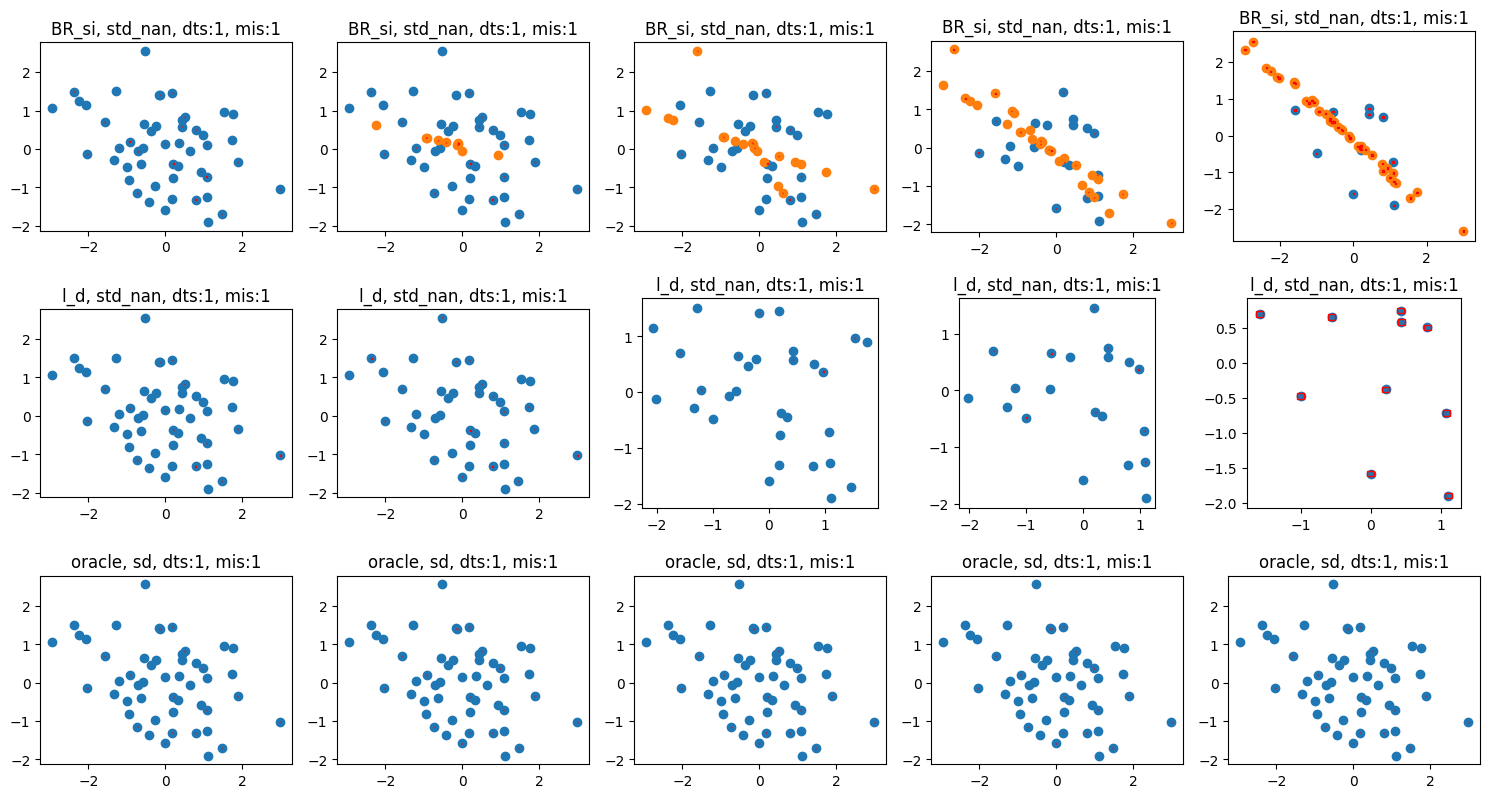

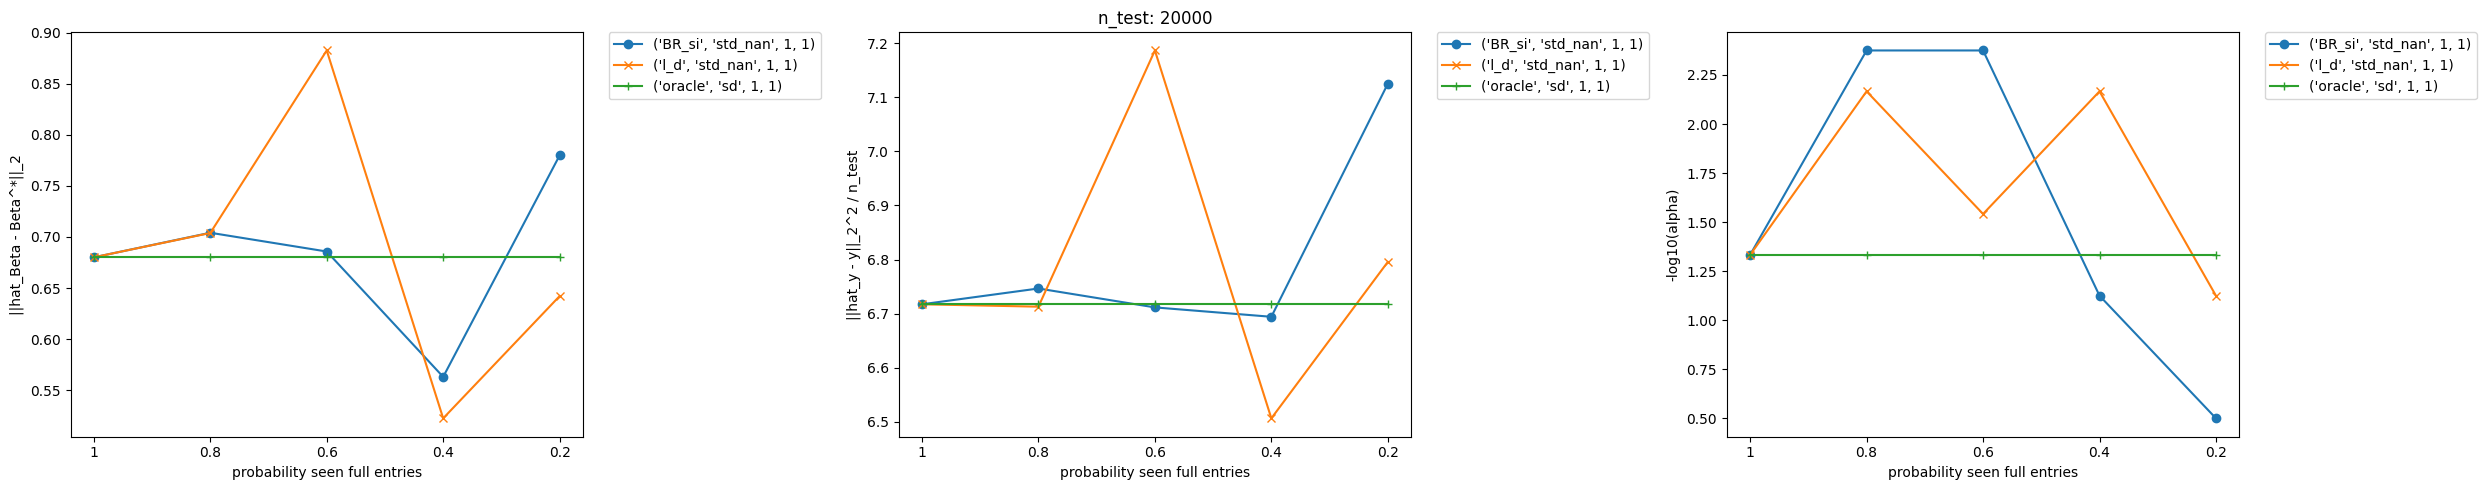

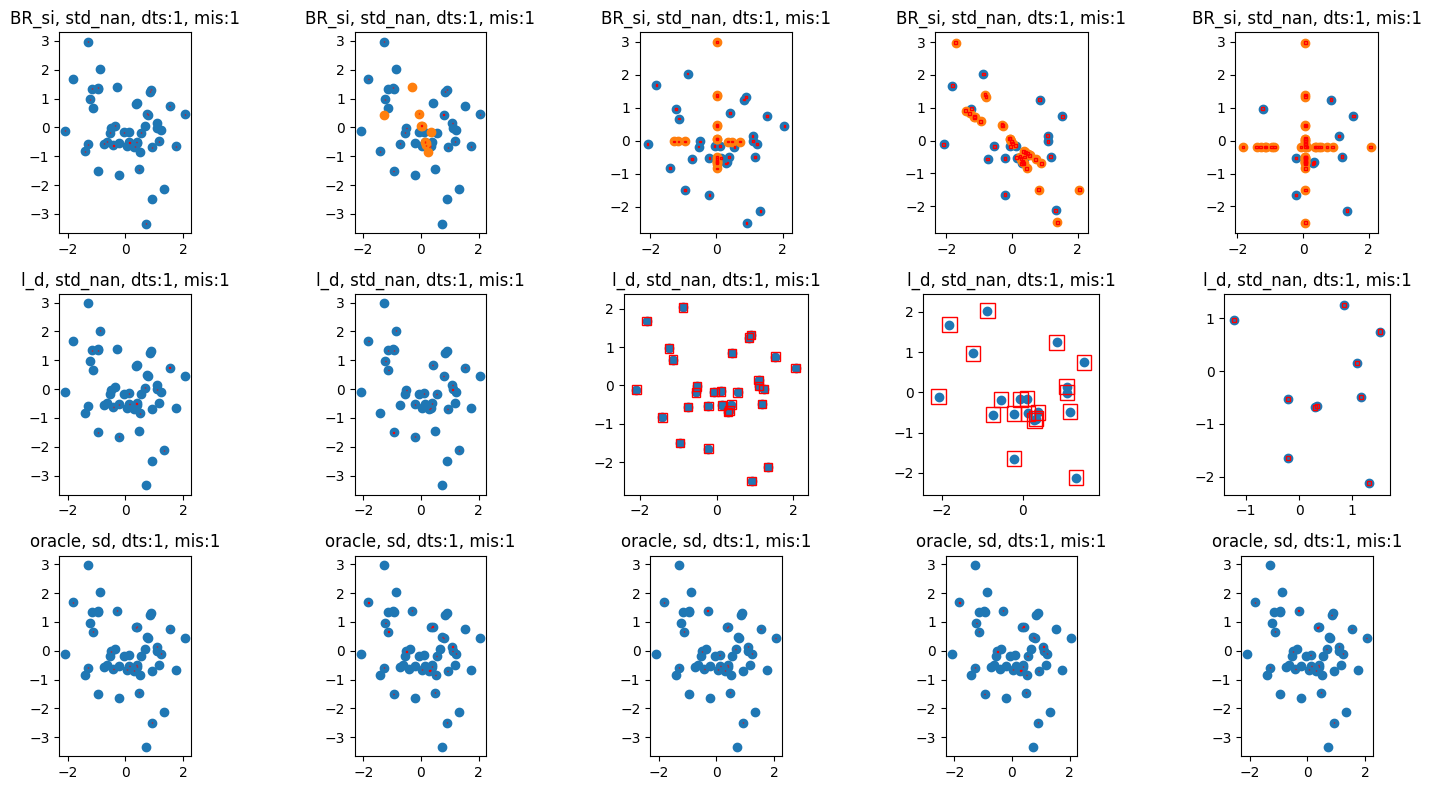

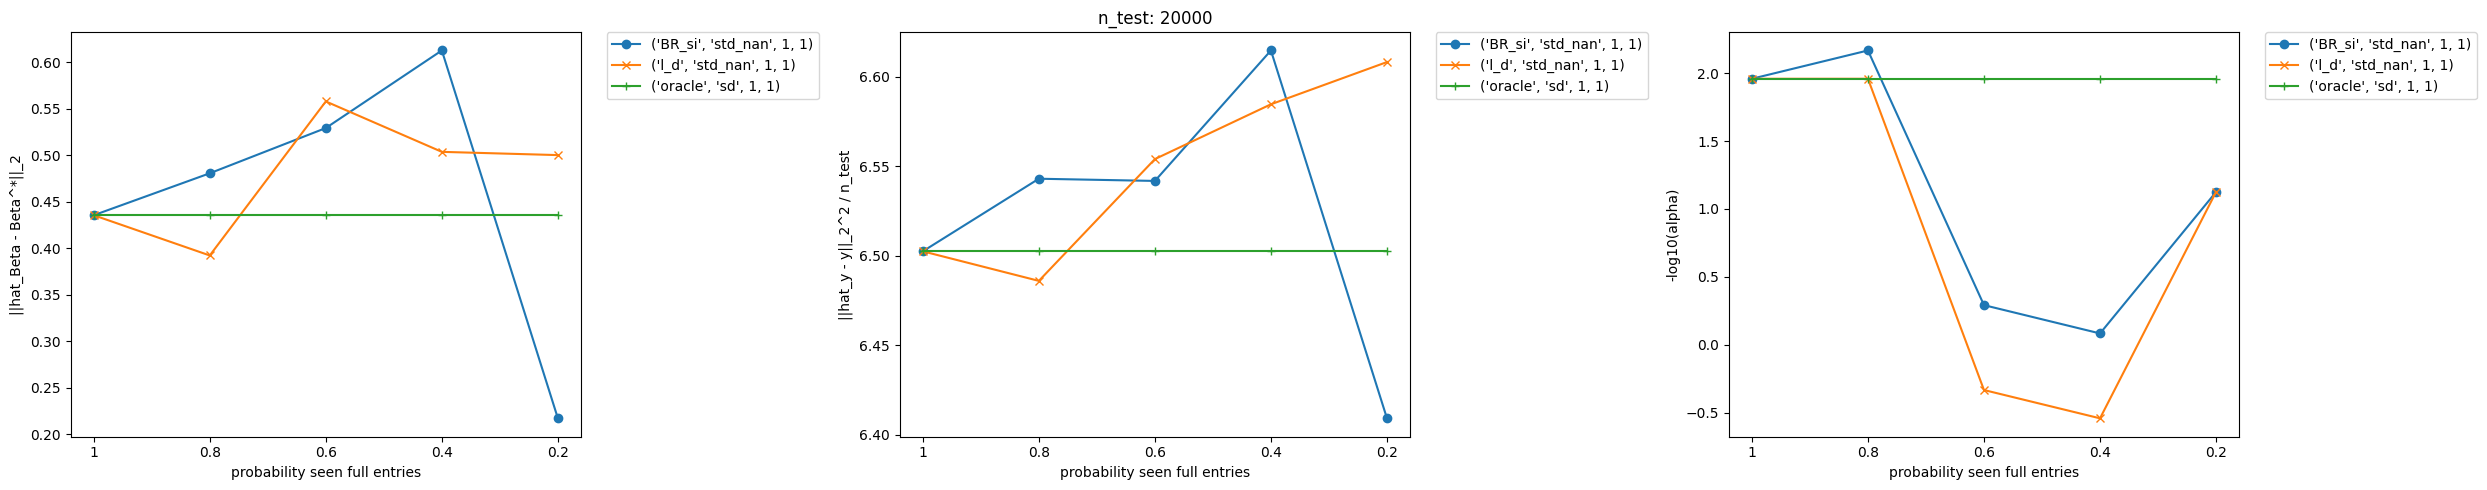

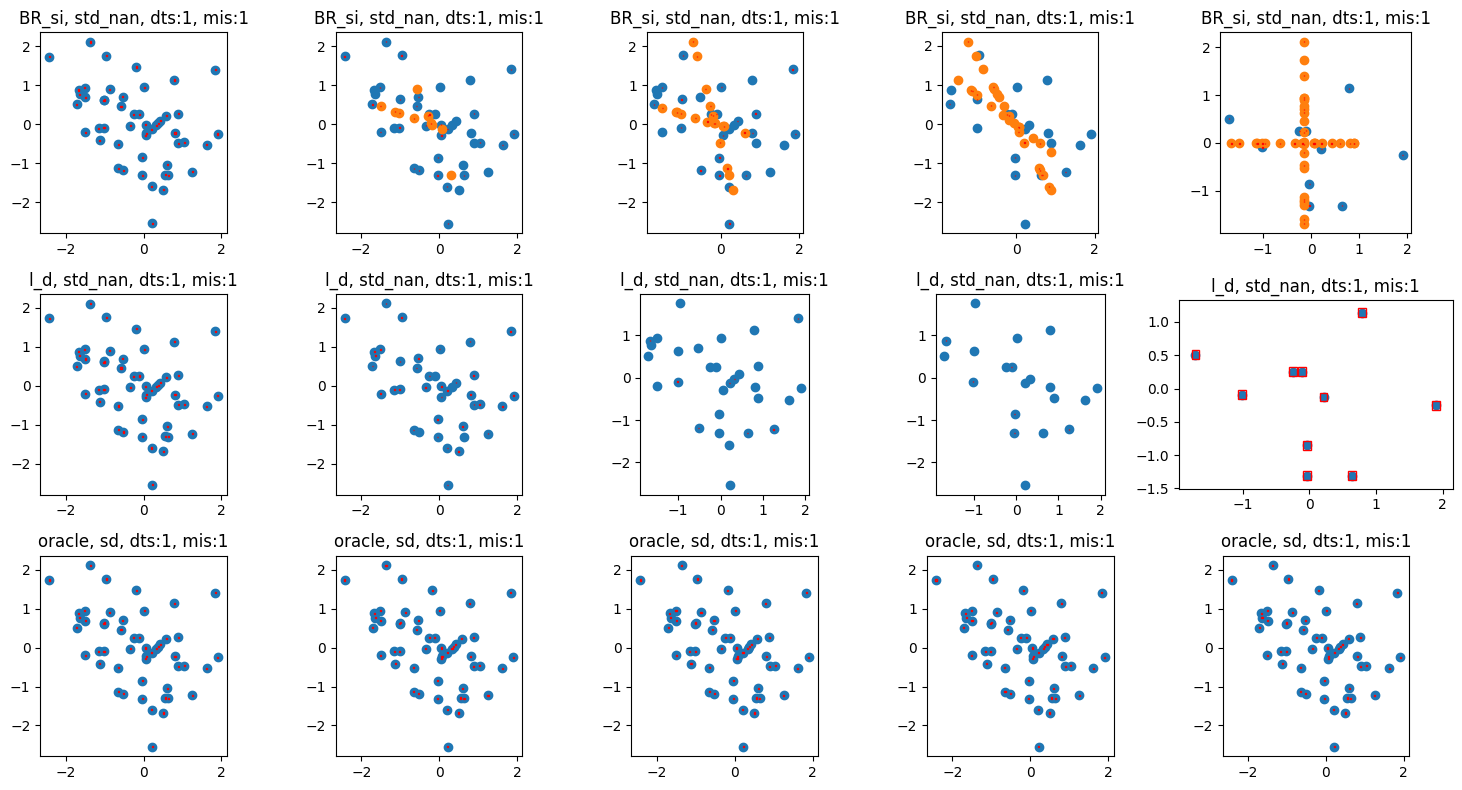

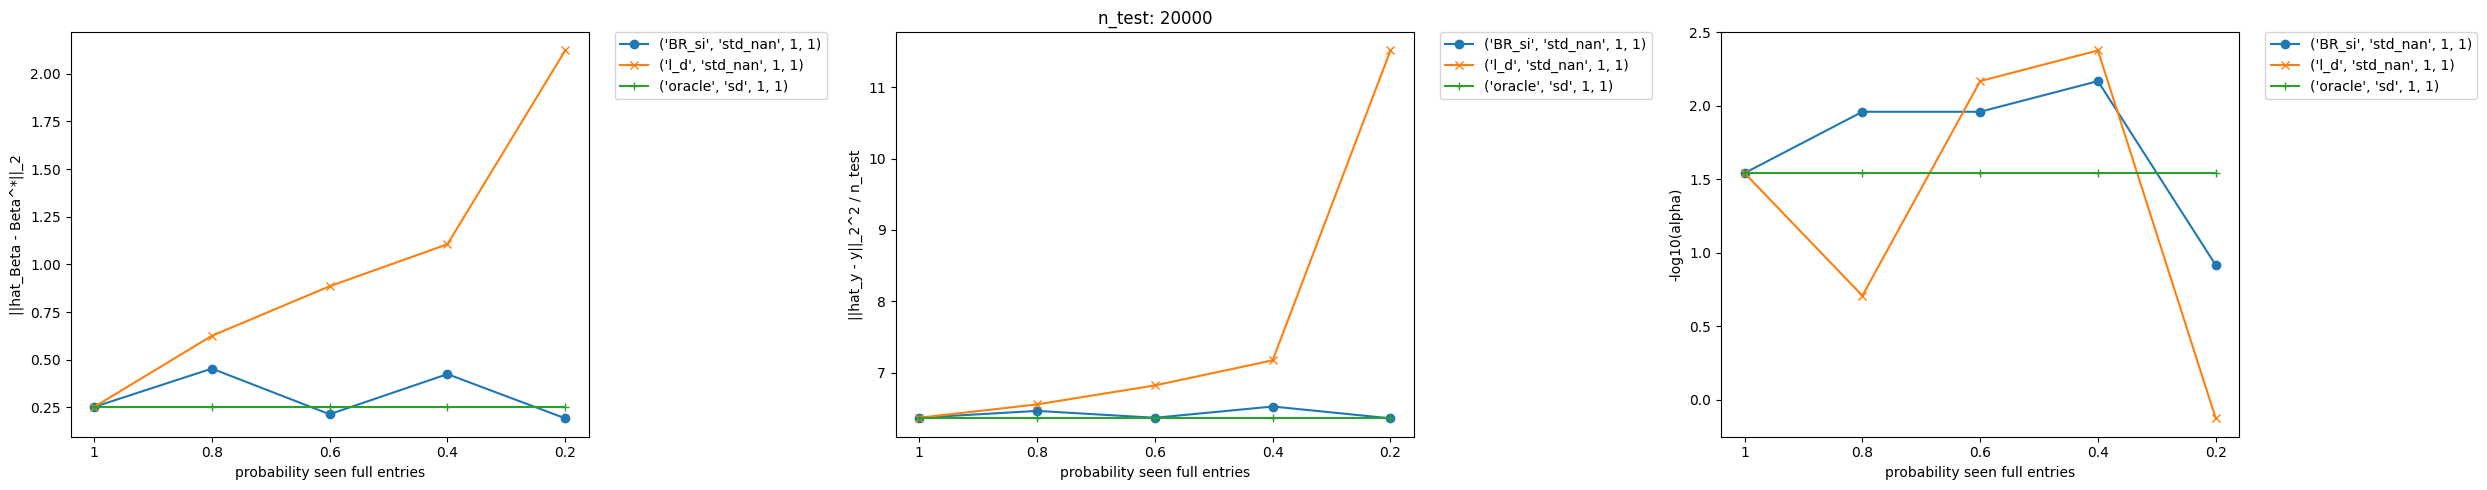

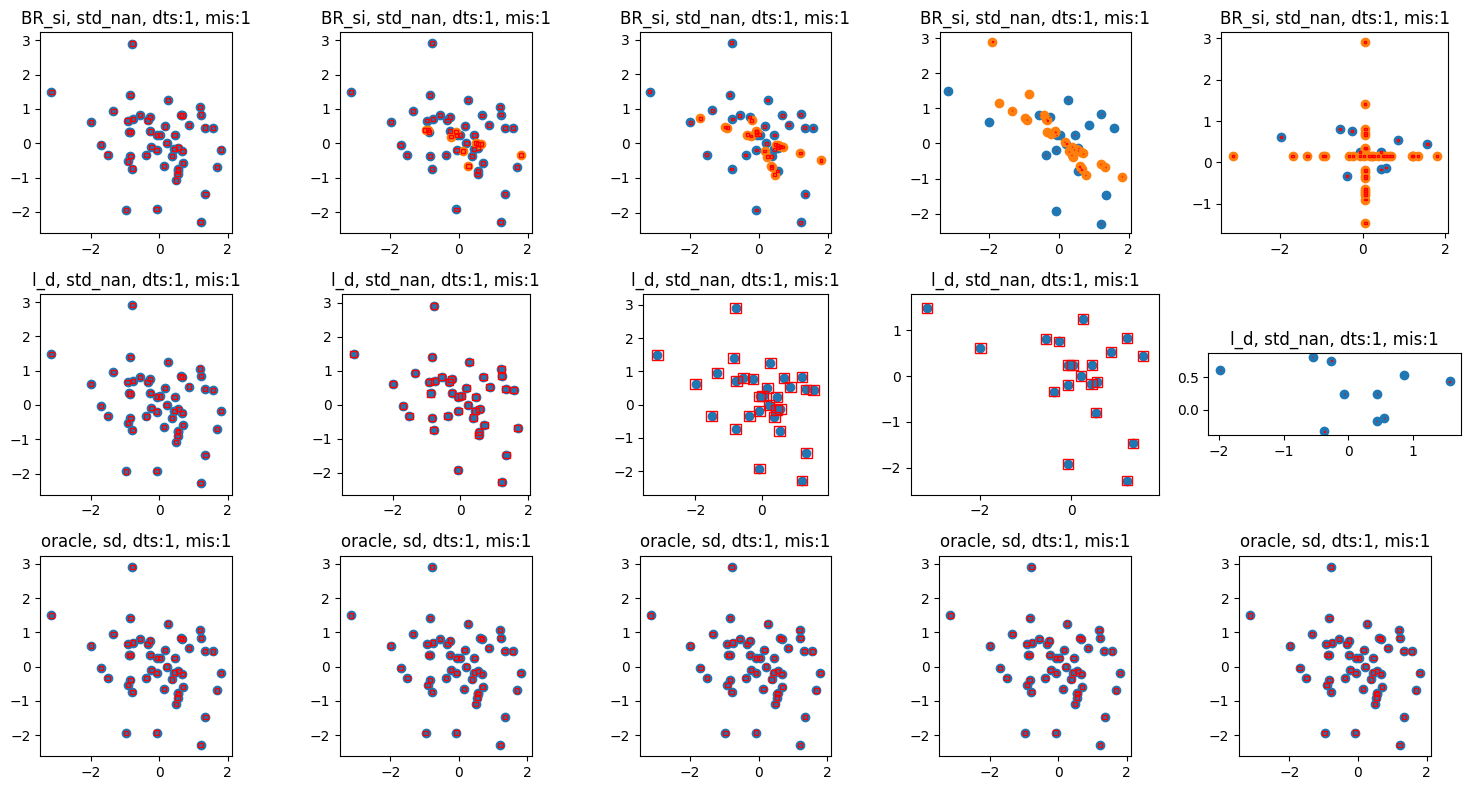

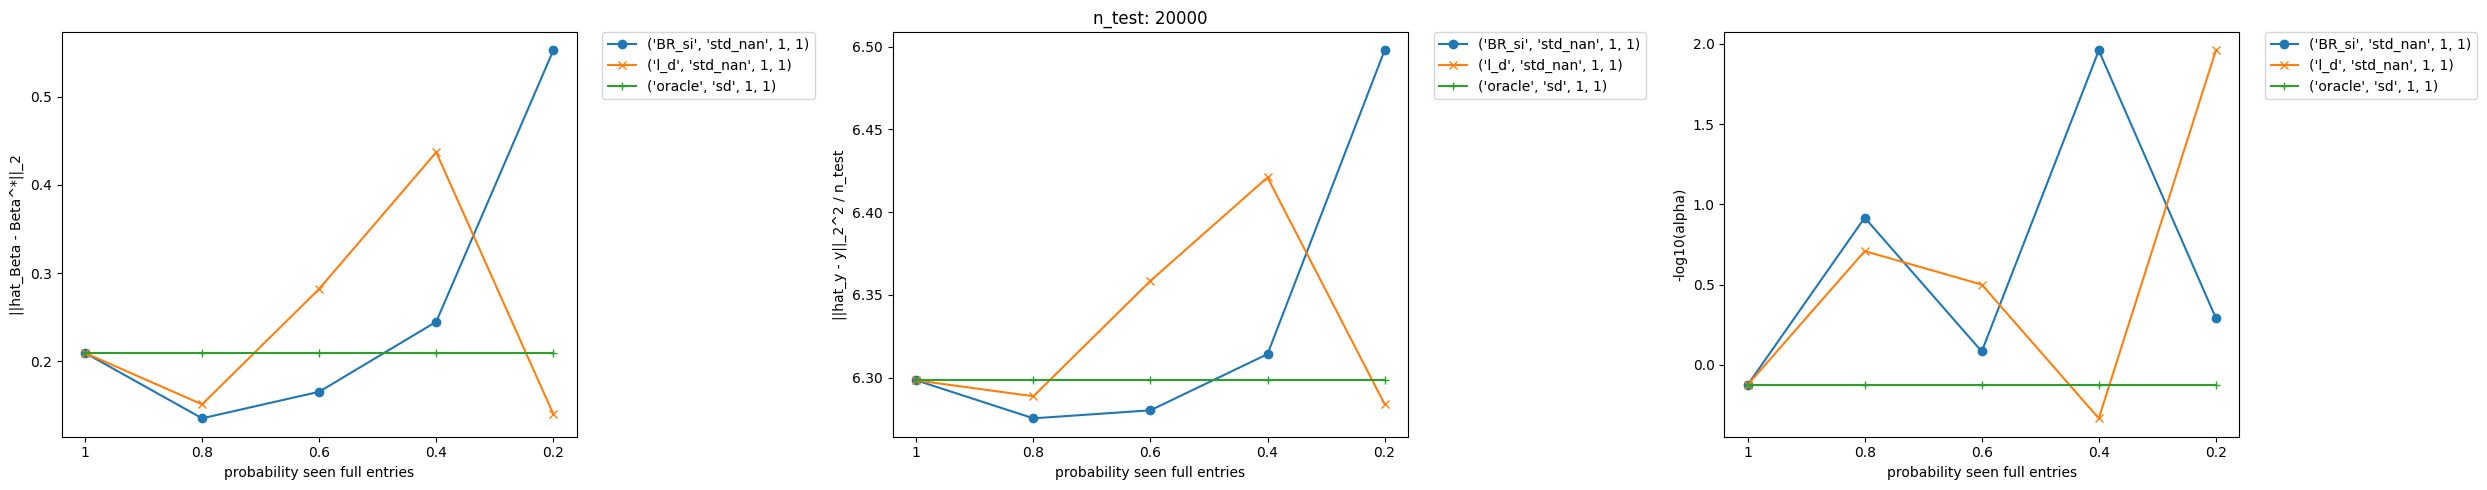

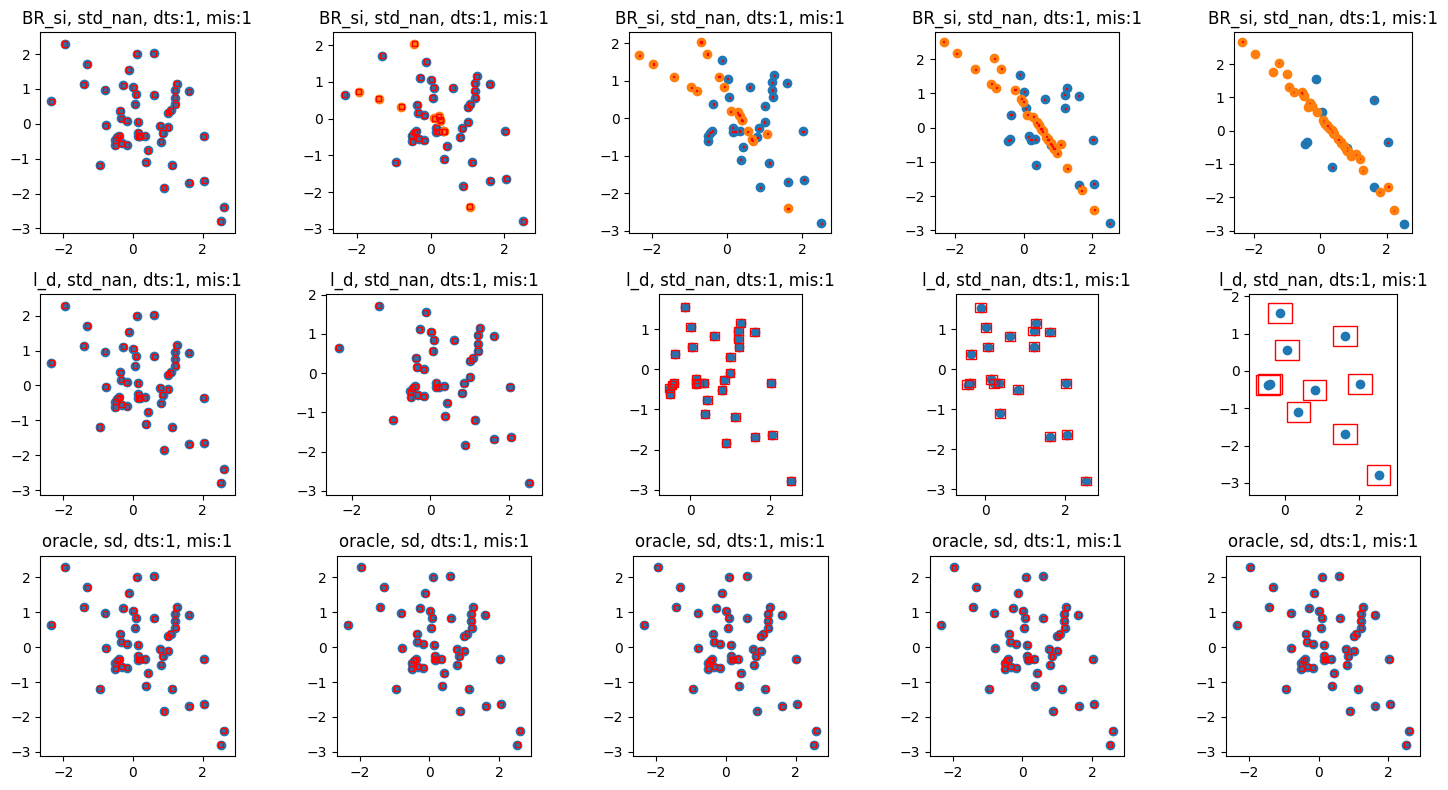

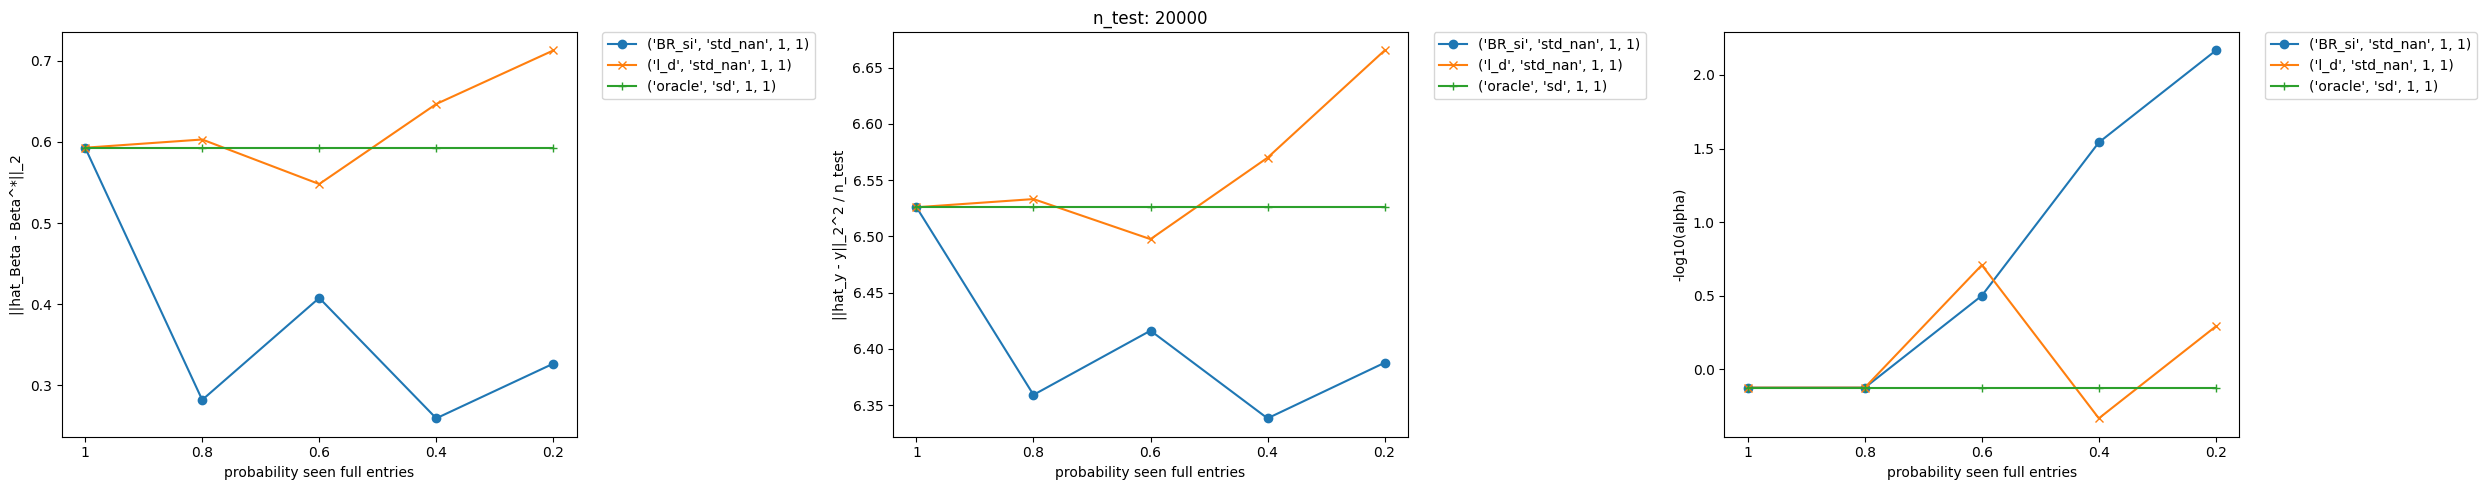

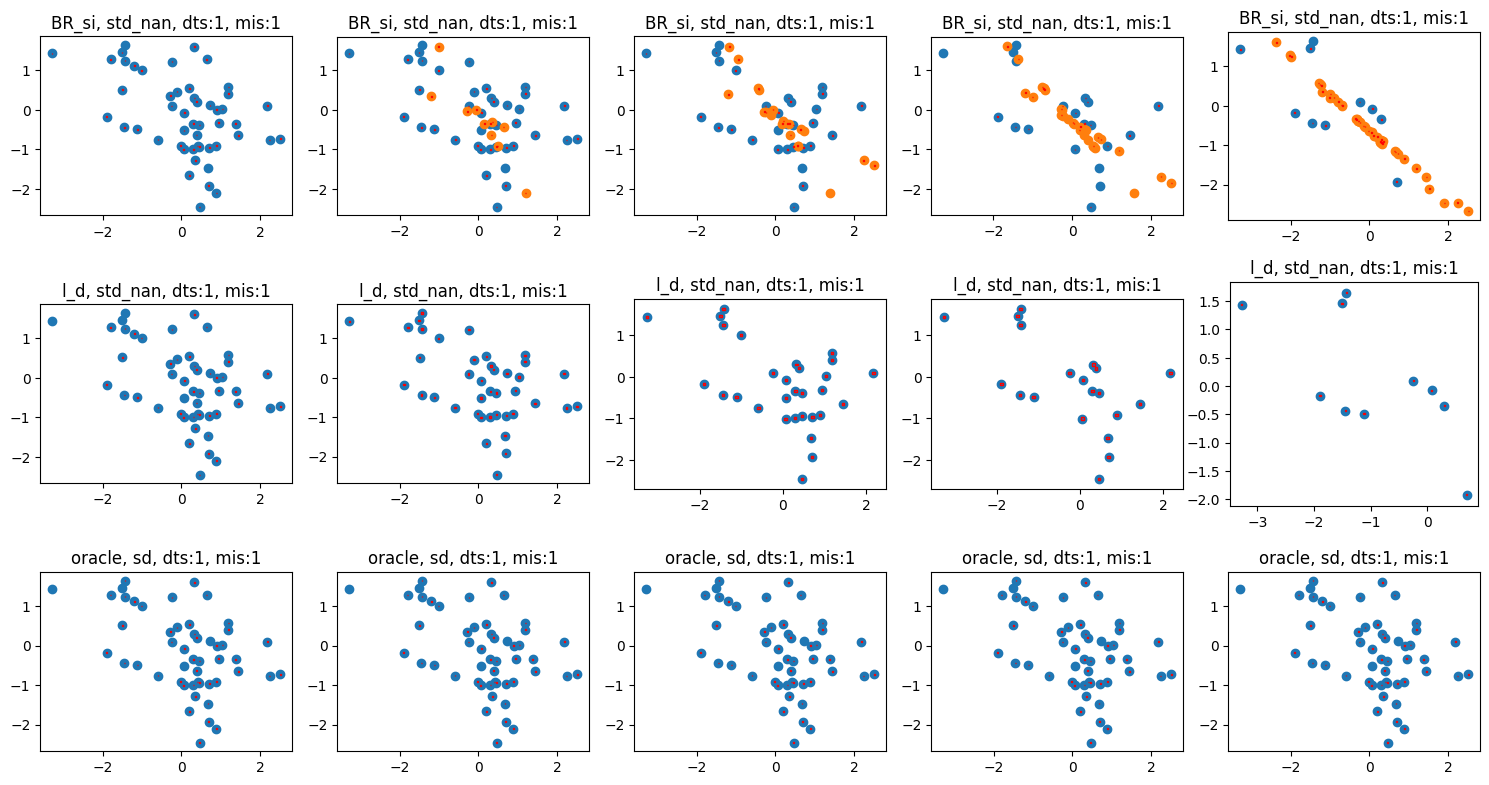

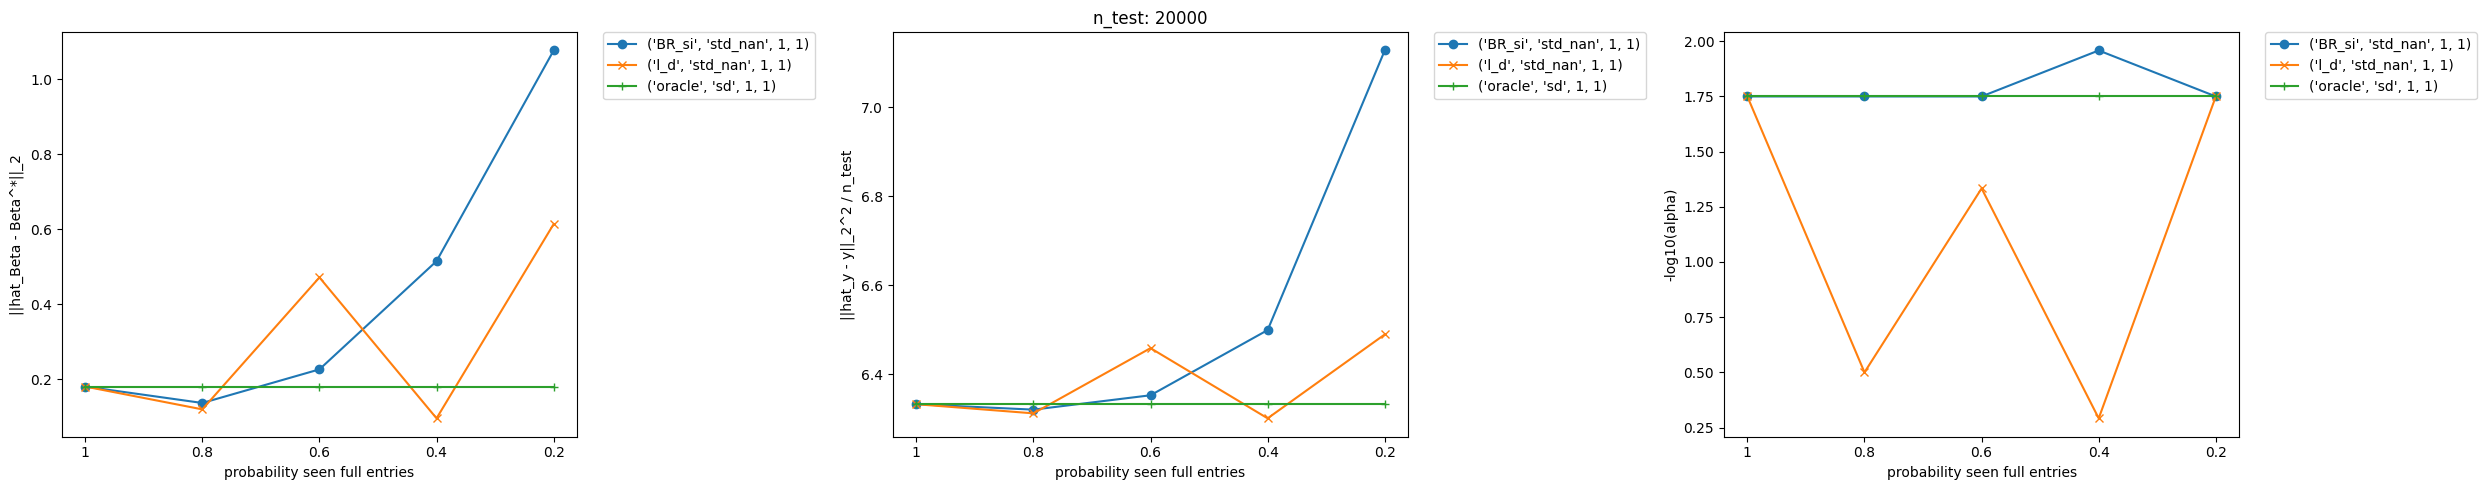

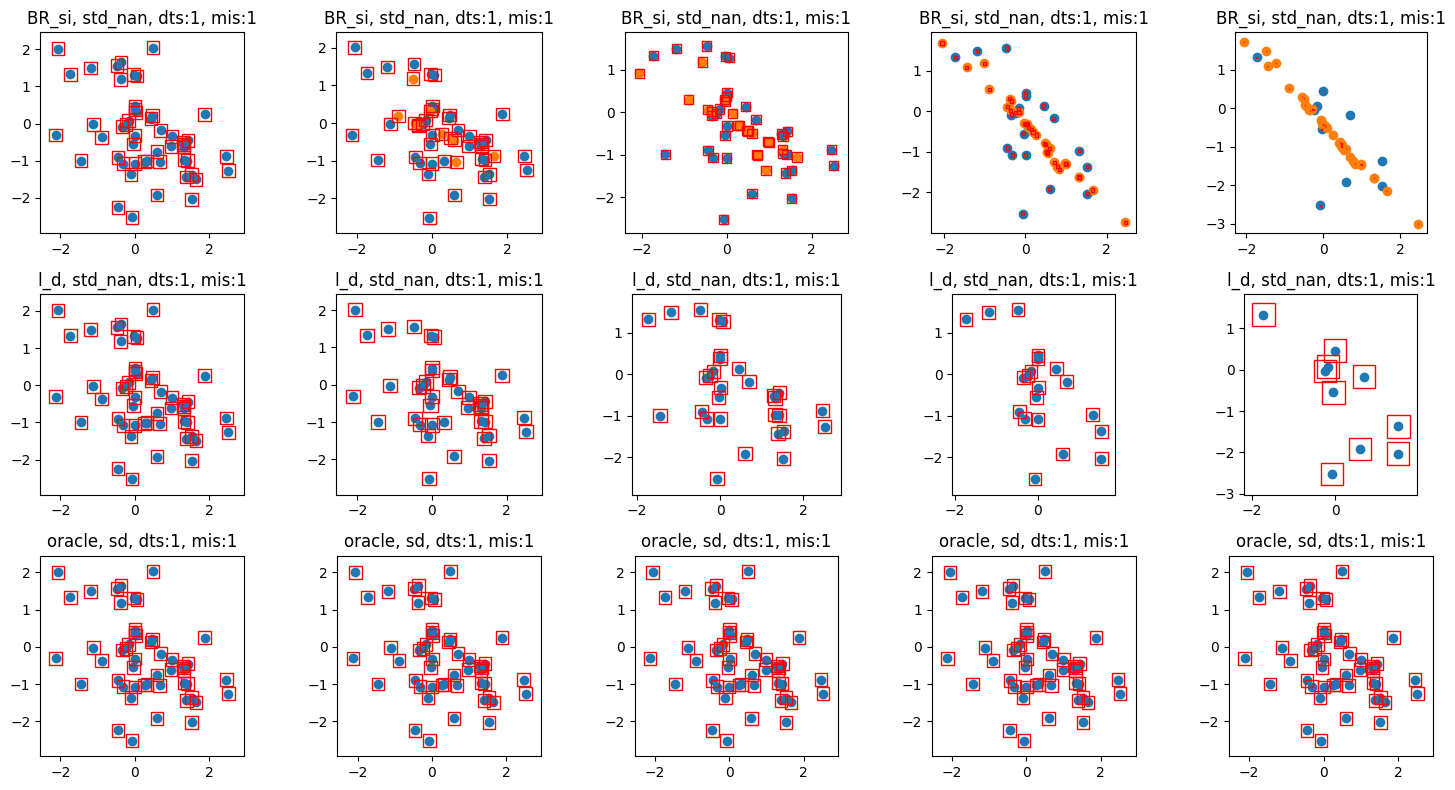

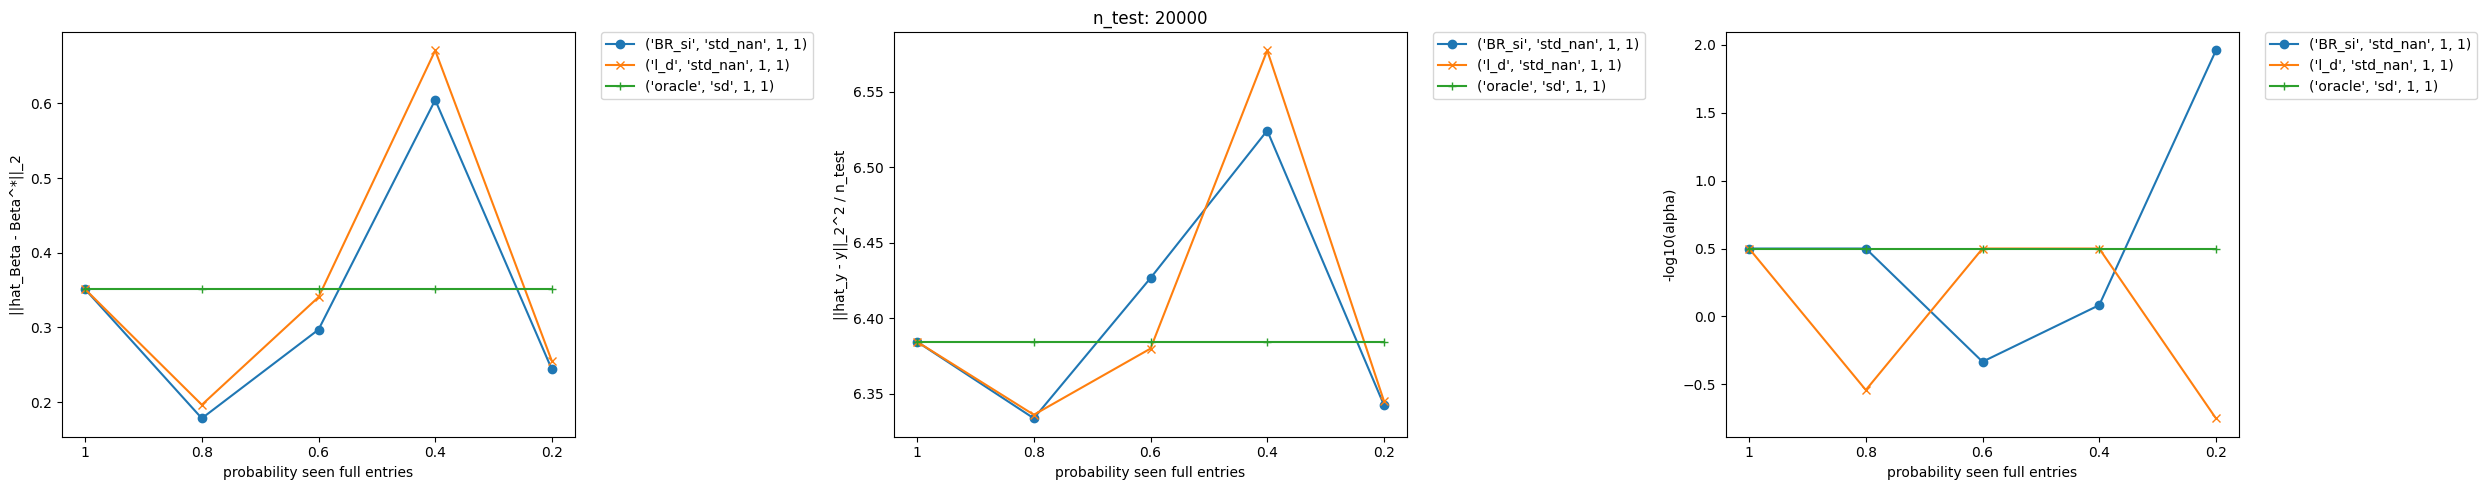

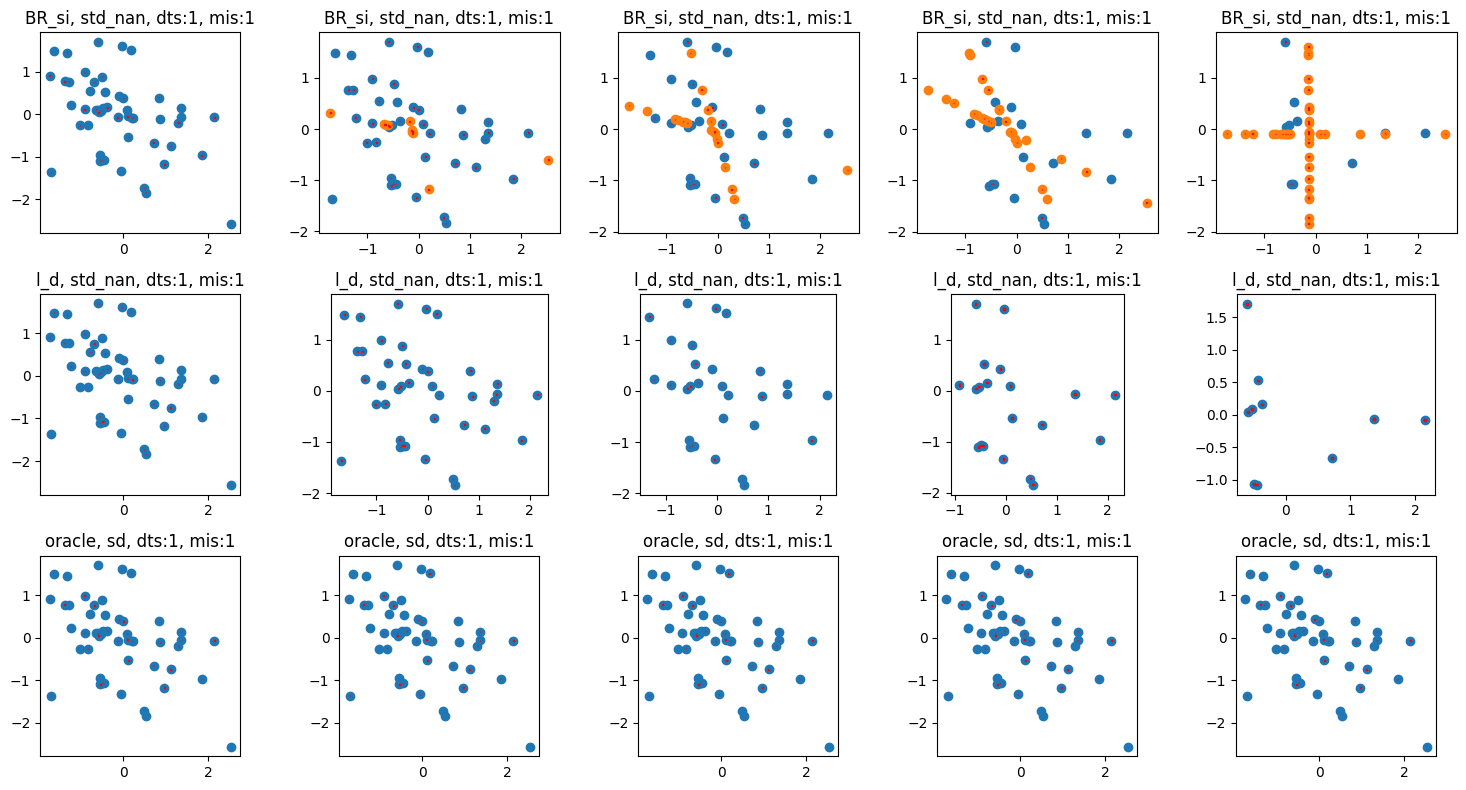

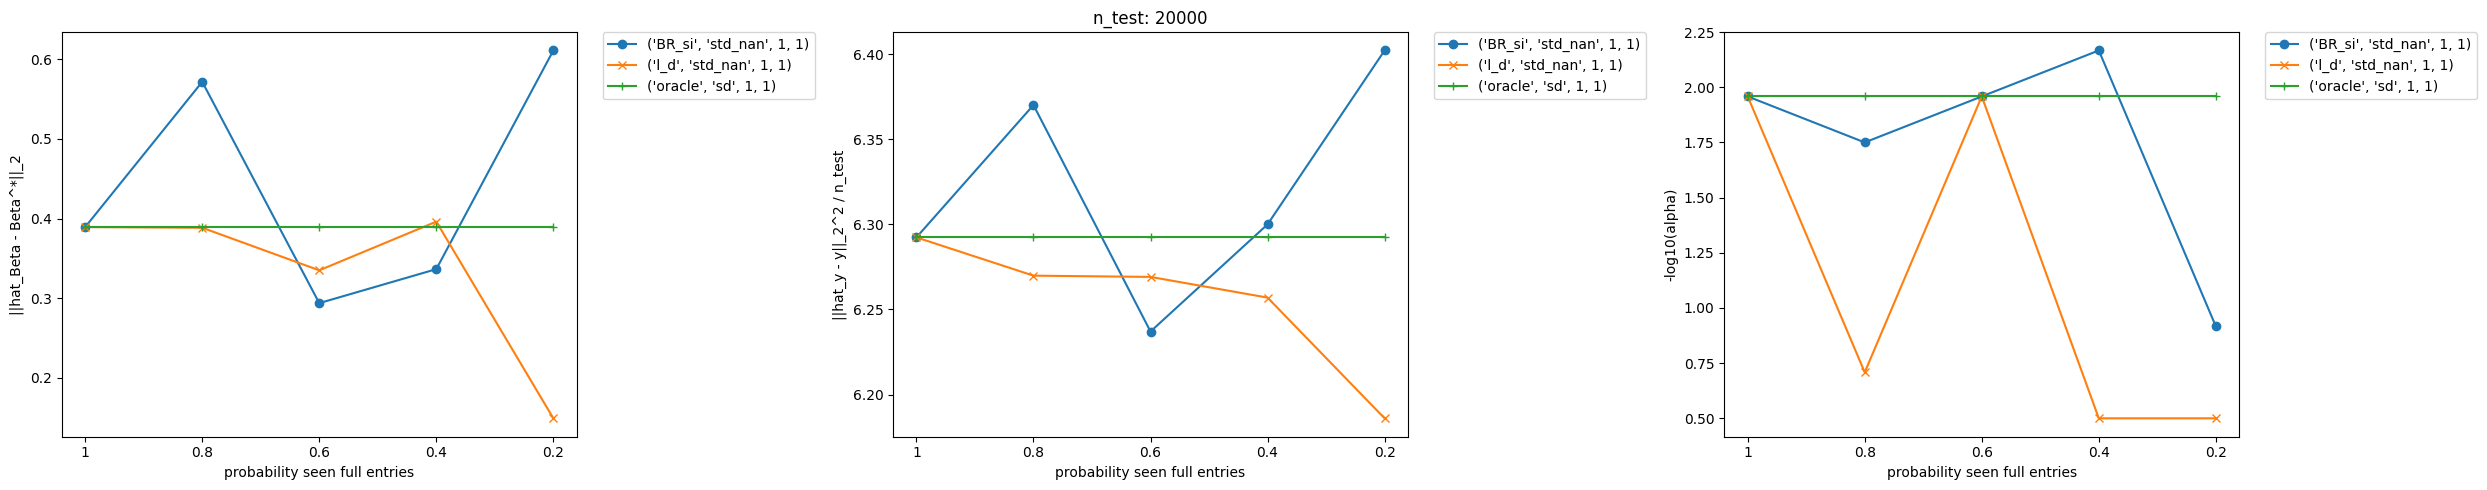

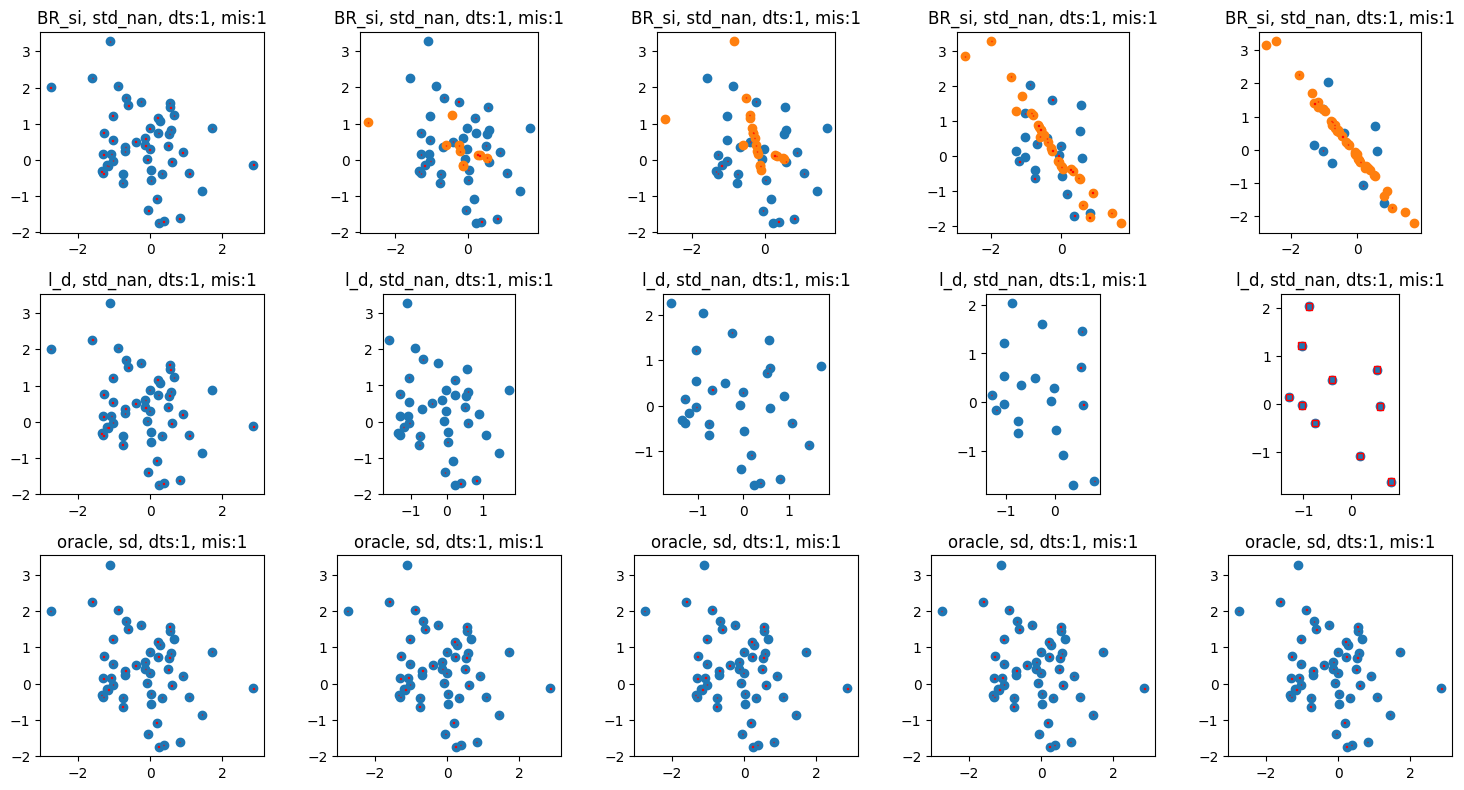

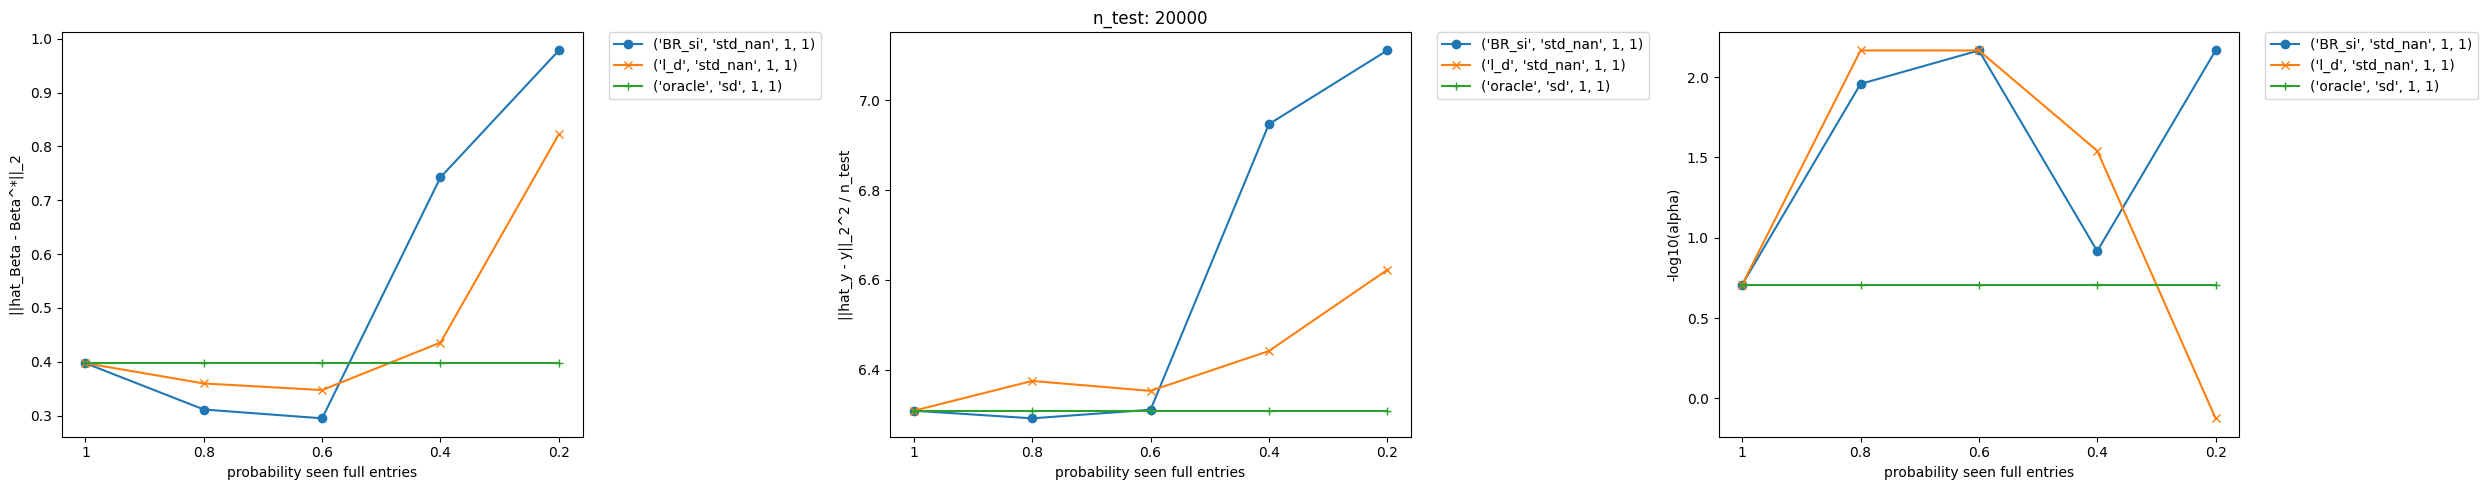

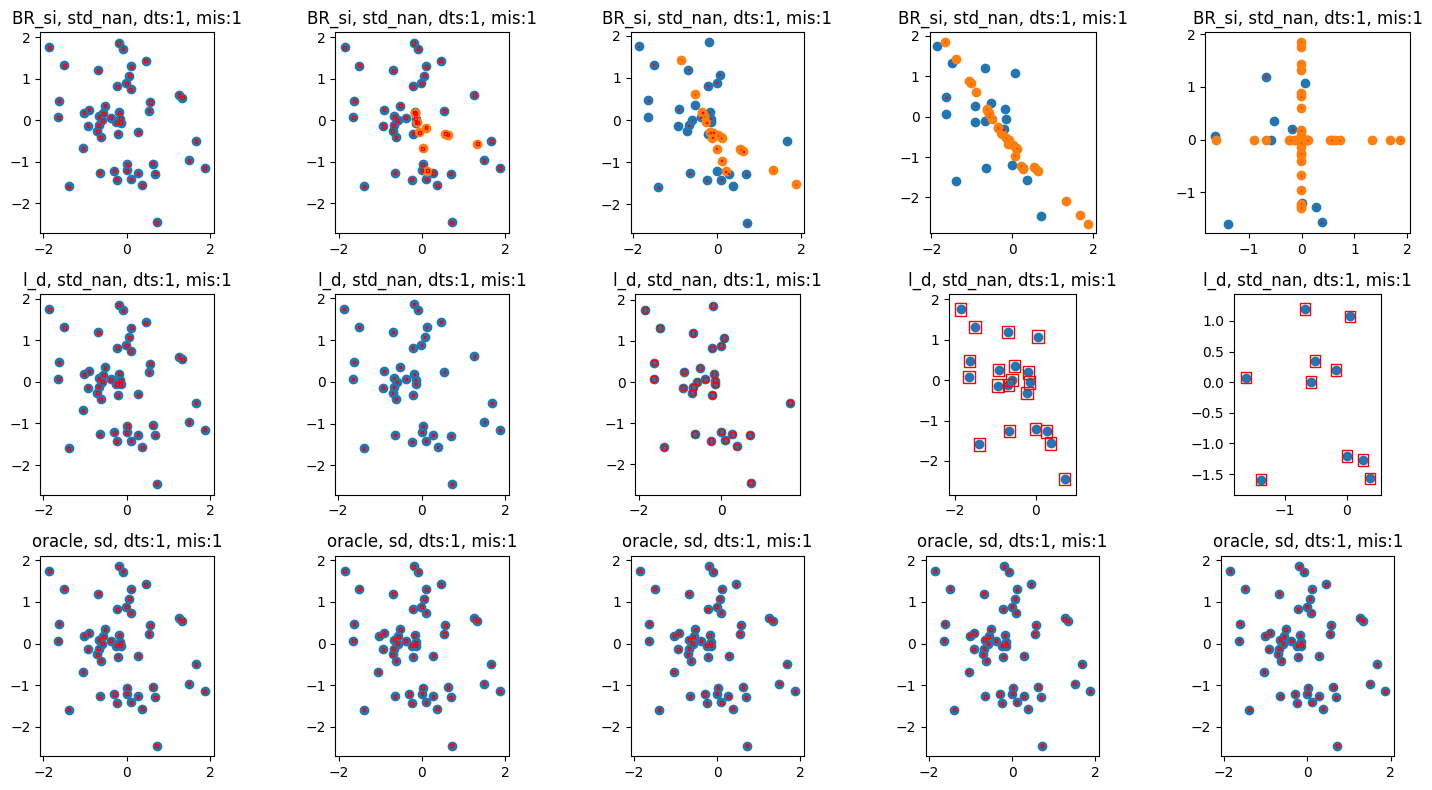

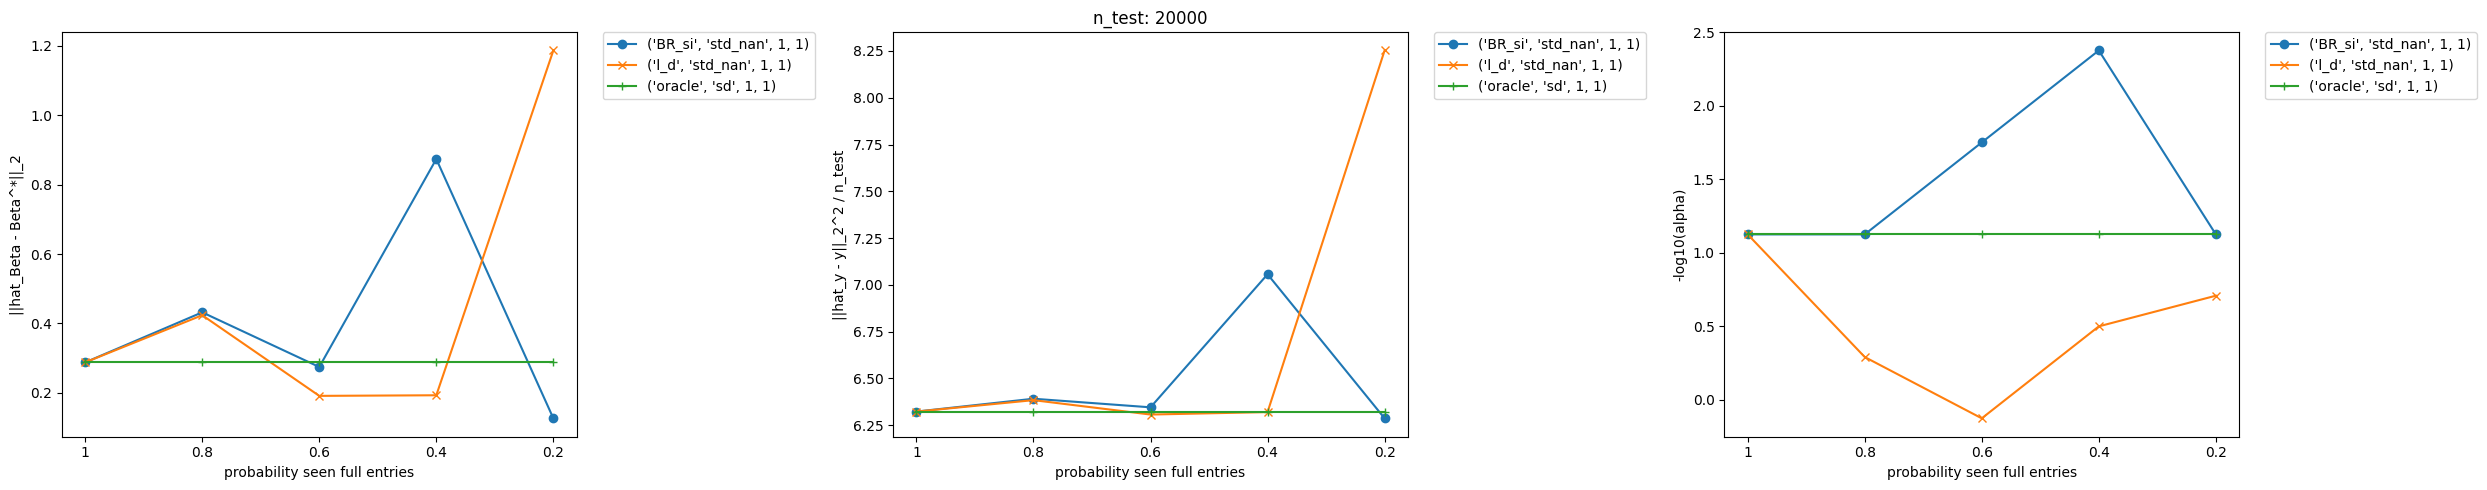

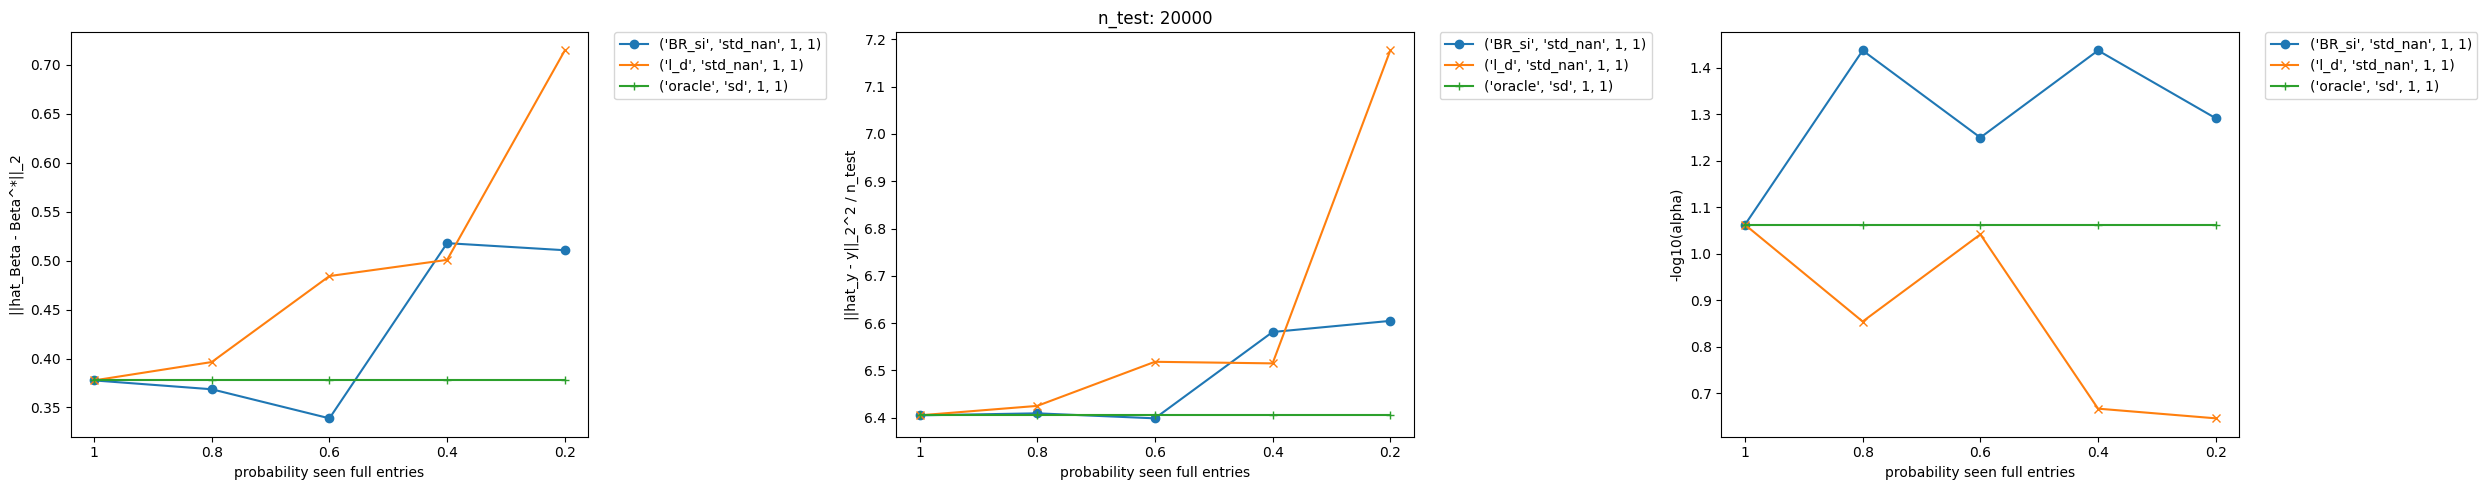

In [49]:

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.8, 0.6, 0.4, 0.2]
#p_seen_both = [0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [2.5] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, -0.4], [-0.4, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
    plots = ['points']#['points', 'l1_vs_coef', '1/alpha_vs_coef']
)
dicc = dicc | {'generation':gen}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 5
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing':1},
                        {'imp_method': 'l_d', 'cov_strategy': 'std_nan', 'multip_dataset': 1, 'multip_missing':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'sd', 'multip_dataset': 1, 'multip_missing':1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.2},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.4},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 0.6},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 0, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 0},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'std_nan', 'mi_nbr': mi_nbr, 'multip_dataset': 3, 'multip_missing': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
nbr_exp = 10
#res[key_tuple]['l2_dist_best_coeff_gt'].append(l2_dist)
#res[key_tuple]['best_coeff'].append(coeff_round)
#res[key_tuple]['best_score'].append(score_round)
#res[key_tuple]['best_alpha'].append(alpha_round)
res_l2 = []

np.random.seed(456789)
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)
if nbr_exp > 1:
  for k in res:
    for h in res[k]:
      res[k][h] = [res[k][h]]
  for i in range(nbr_exp-1):
    np.random.seed(456789 * (i+2))
    res_partial = run_experiments(dicc, list_methods_strategy)
    plot_res(info_x_axis, res_partial, dicc)
    print(res)
    for k in res:
      res[k]['l2_dist_best_coeff_gt'].append(res_partial[k]['l2_dist_best_coeff_gt'])
      res[k]['best_score'].append(res_partial[k]['best_score'])
      res[k]['best_alpha'].append(res_partial[k]['best_alpha'])
      #res[k]['best_coeff'].append(res_partial[k]['best_coeff
    #res.append(res['l2_dist_best_coeff_gt'])

print("final ")
print(res)
for k in res:
  print(k)
  print(np.array(res[k]['l2_dist_best_coeff_gt']))
  print(np.mean(np.array(res[k]['l2_dist_best_coeff_gt']), axis=0))
  print(np.mean(res[k]['l2_dist_best_coeff_gt'], axis=0))
#mean_res = {k: np.mean(v, axis=0) for k, v in res.items()}
mean_res = {k: {v: np.mean(w, axis=0) for v, w in res[k].items()} for k in res}
for k, v in mean_res.items():
  print("k:   ", k)
  for s, t in v.items():
    print(s, ": ", t)
#print(np.mean(res, axis=0))
print("PLOT OF THE MEANS")
plot_res(info_x_axis, mean_res, dicc)




## you can see if you manage to take the index i that maximize alpha



In [ ]:
'''
np.random.seed(456789)

#info_axis = 'train'
#n_train = [400, 800, 1200, 1600, 2000]
#p_seen = make_probabilities([0.8, 0.8, 0.8, 0.8, 0.8])
#main_vec = n_train if info_axis == 'train' else p_seen
#info_x_axis = make_info_axis(main_vec, info_axis)

gen = 'fixed'
info_axis = 'p_seen'  # train or p_seen
#p_seen_both = [1, 0.95, 0.90, 0.85, 0.80, 0.75, 0.70, 0.65, 0.60, 0.55, 0.50, 0.45, 0.40, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02]
#p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
p_seen_both = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
#p_seen_both = [1, 0.9, 0.8]
length_vec = len(p_seen_both)
#n_train = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
n_train = [50] * length_vec
error_vec =  [1] * length_vec
p_seen = make_probabilities(p_seen_both)
if info_axis == 'train':
  main_vec = n_train
elif info_axis == 'p_seen':
  main_vec = p_seen_both
elif info_axis == 'error':
  main_vec = error_vec
#main_vec = n_train if info_axis == 'train' else p_seen_both
info_x_axis = make_info_axis(main_vec, info_axis)


dicc = make_dictionary_data(
    nbr_experiments= len(main_vec), n_train = n_train, n_test=20000,
    data = {'data': 'Normal', 'mean': np.array([0, 0]), 'cov': np.array([[1, -0.1], [-0.1, 1]])},
    beta_gt = np.array([-0.5, 2]),
    p_miss = p_seen,
    err_vector = ['Gaussian_on_y', error_vec],
)
dicc = dicc | {'generation':gen}
for key, value in dicc.items():
  print(key,": " , value[0])

# (imp method, cov strategy, mi_nbr)
#list_imp_cov_methods = [('BR_si', 'sd'), ('l_d', 'sd'), ('mi', 'sd', 1)]

#list_methods_strategy = make_dictionary_method(list_imp_cov_methods)
mi_nbr = 30
list_methods_strategy = [{'imp_method': 'BR_si', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'l_d', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        {'imp_method': 'oracle', 'cov_strategy': 'eye', 'multip_betw': 1, 'multip_with':1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 3},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'eye', 'mi_nbr': 2},
                        #{'imp_method': 'mi_pure', 'cov_strategy': 'cond_var', 'cov_strategy_within': 'sd', 'mi_nbr': 5},
                        #{'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'zero', 'mi_nbr': mi_nbr, 'multip_betw': 1, 'multip_with': 1},
                        #{'imp_method': 'mi_mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'eye', 'mi_nbr': 5},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 0, 'multip_with': 1},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 0},
                        {'imp_method': 'mi', 'post_imp':'mean', 'cov_strategy_between': 'cond_var', 'cov_strategy': 'RR', 'mi_nbr': mi_nbr, 'multip_betw': 3, 'multip_with': 1},
                        #{'imp_method': 'mi', 'cov_strategy': 'RR', 'mi_nbr': 5},
                        ]
print(list_methods_strategy)
for el in list_methods_strategy:
  for key, value in el.items():
    print(key,": " , value)

print("----> Starting experiments")
res = run_experiments(dicc, list_methods_strategy)
plot_res(info_x_axis, res, dicc)



## you can see if you manage to take the index i that maximize alpha
'''


In [ ]:
X = np.random.randint(2, 5, size=(2, 2, 2))
print(X)

XX = np.concatenate(X)
print(XX)


Y = np.random.randint(2, 5, size=(1, 3, 2))
print(Y)

YY = np.concatenate(Y)
print(YY)


Z = np.random.randint(2, 5, size=(5, 2))
print(Z)

ZZ = np.concatenate(Z)
print(ZZ)

print("other")
s = np.random.randint(2, 4, 5)
print(s)
z = np.tile(s, reps=3)  # np.array([s] * 2)
print(z)


print("other mult")
s = np.random.randint(2, 8, size=(3, 2))
print(s)
z = np.tile(s, reps=(3, 1))  # np.array([s] * 2)
print(z)


In [ ]:
'''
## random forest imputer
from sklearn.ensemble import RandomForestRegressor
rf_estimator = RandomForestRegressor(n_estimators=4, max_depth=10, bootstrap=True, max_samples=0.5, n_jobs=2, random_state=0)

X_rf = single_imputation(X_nan, rf_estimator)
print(X_rf.shape)
sd_rf = np.std(X_rf, axis=0)
S_inv_rf = np.diag(1 / sd_rf)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std rf\n ", sd_rf)
fig, ax = plt.subplots(num='advtrain_linf_rf')
linfadvtrain_rf = AdversarialTraining(X_rf, y, S_inv_rf, p=np.inf)
estimator_rf = lambda X, y, a:  linfadvtrain_rf(adv_radius=a)
alphas_adv, coefs_advtrain_linf_rf  = get_path(X_rf, y, estimator_rf, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_rf, ax)
'''

In [ ]:
'''
## iterative imputer Bayesian Ridge

from sklearn.linear_model import BayesianRidge
br_estimator = BayesianRidge()

X_br = single_imputation(X_nan, br_estimator)
sd_br = np.std(X_br, axis=0)
S_inv_br = np.diag(1 / sd_br)
print("std_orig: \n", np.std(X_orig, axis=0))
print("std  br\n ", sd_br)

fig, ax = plt.subplots(num='advtrain_linf_br')
linfadvtrain_br = AdversarialTraining(X_br, y, S_inv_br, p=np.inf)
estimator_br = lambda X, y, a:  linfadvtrain_br(adv_radius=a)
alphas_adv, coefs_advtrain_linf_br  = get_path(X_br, y, estimator_br, 1e4)
plot_coefs_l1norm(coefs_advtrain_linf_br, ax)
'''

In [ ]:
'''
## mean imputation
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_mean = imp_mean.fit_transform(X_nan)
sd_mean = np.std(X_mean, axis=0)
print(sd_mean)
S_inv_mean = np.diag(1 / sd_mean)

fig, ax = plt.subplots(num='advtrain_linf_mean')
linfadvtrain_mean = AdversarialTraining(X_mean, y, S_inv_mean, p=np.inf)
estimator_mean = lambda X, y, a:  linfadvtrain_mean(adv_radius=a)
alphas_adv, coefs_advtrain_linf_mean  = get_path(X_mean, y, estimator_mean, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_mean, ax)
'''

In [ ]:
'''
# imputation elliptic

mu = np.nanmean(X_nan, axis=0)
print("means ", mu)
delta = np.mean(masks) # parameter missingness
print("delta ", delta)
X_0 = np.nan_to_num(X_nan)
print("nbr obs", X_0.shape[0])
S_ellp =  X_0.T @ X_0 / X_0.shape[0]
S_ellp = (1/delta - 1/(delta**2)) * np.diag(np.diag(S_ellp)) + 1/(delta**2) * S_ellp
print("eig cov ", np.linalg.eigvalsh(S_ellp))
X_ellp = imputation_elliptic(mu, S_ellp, X_nan, masks)
#S_inv_ellp = np.linalg.inv(S_ellp)  # other variance
sd_inv_ellp = np.std(X_ellp, axis=0)
print("sd ellp", sd_inv_ellp)

fig, ax = plt.subplots(num='advtrain_linf_ellp')
linfadvtrain_ellp = AdversarialTraining(X_ellp, y, S_ellp, p=np.inf)
estimator_ellp = lambda X, y, a:  linfadvtrain_ellp(adv_radius=a)
alphas_adv, coefs_advtrain_linf_ellp  = get_path(X_ellp, y, estimator_ellp, 1e1)
plot_coefs_l1norm(coefs_advtrain_linf_ellp, ax)
'''

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


# Example data
x_test_rect = np.random.rand(10)
y_test_rect = np.random.rand(10)

# Plot the points
fig, ax = plt.subplots()
ax.scatter(x_test_rect, y_test_rect)

width = 0.1
height = 0.1

add_rectangles(x_test_rect, y_test_rect, width, height, ax)

# Add the rectangle to the plot


In [ ]:
# Cell for some tests

def test_clear_dataset(n, d):
  print("test clear dataset")
  X = np.random.randint(1, 3, size=(n, d))
  y = np.random.randint(1, 3, size=n)
  masks = np.random.binomial(1, 0.3, size=(n, d))
  print("X \n", X)
  print("y\n", y)
  print("masks \n", masks)
  masks[:, 0] = np.ones(n)
  masks[0, :] = np.ones(d)
  X_res, y_res, masks_res = clear_dataset(X, y, masks)
  print("X_res \n", X_res)
  print("y\n", y_res)
  print("masks \n", masks_res)
  print("test clear dataset ended successfully")

def test_generate_X():
    print("test generate_X started")
    fig, ax = plt.subplots(3, 1, figsize=(10, 8), num='advtrain_linf')
    gen = generate_X('circles', 2)
    data = gen(1000)
    print(data.shape)
    ax[0].scatter(data[:, 0], data[:, 1])
    print("test generate passed syccessfully")

def test_preparation_dataset(n, d):
      print("\ntest preparation dataset started")
      X_train = np.random.rand(n, d)
      print("X_train \n", X_train)
      mask = np.random.binomial(1, 0.5, (n, d))
      print("mask, 0 seen, 1 missing \n ", mask)
      X_masked = X_train * (1 - mask)
      print("X_masked \n", X_masked)
      X_nan_train = X_train.copy()
      X_nan_train[mask == 1] = np.nan
      print("X_nan_train \n", X_nan_train)
      X_br_train = single_imputation(X_nan_train, BayesianRidge())
      print("X_br_train\n ", X_br_train)

      print("what happens if we run single_imputation of full dataset")
      X_br_full = single_imputation(X_train, BayesianRidge())
      print("X_br_full\n ", X_br_full)
      np.testing.assert_allclose(X_train, X_br_full)  # shuold be untouched
      print("test preparation dataset ended successfully")

def test_listwise_delection(n, d):
    print("\n test list_wise delection started")
    X = np.random.rand(n, d)
    print("data\n", X)
    mask = np.random.binomial(1, 0.2, (n, d))
    print("mask \n", mask)
    X_ld = listwise_delection(X, mask)
    print("after calling function, X_ld \n", X_ld)

    print("edge cases, all missing")
    mask_1 = np.ones_like(X)  # all missing
    X1 = listwise_delection(X, mask_1)
    print("X1 \n", X1)  # should be empty
    mask_0 = np.zeros_like(X)  # all seen
    X0 = listwise_delection(X, mask_0)
    print("X0 \n", X0)
    np.testing.assert_allclose(X0, X)  # should be the original dataset

    print("one dimnsional array")
    y = np.random.rand(n)
    print("y before ", y)
    y_ld = listwise_delection(y, mask)
    print("y after ld ", y_ld)
    print("test listwise_delection passed")


test_generate_X()
test_preparation_dataset(3, 4)
test_listwise_delection(3, 4)
test_clear_dataset(6, 3)

xxx = np.random.randint(2, 5, size=(3, 3)) * 1.0
mmm = np.random.binomial(1, 0.5, size=(3, 3))
print(xxx)
print(mmm)
print(mmm == 1)
print(xxx[mmm == 1])
xxx[mmm == 1] = np.nan
print(xxx)
mask_from_xxx = np.isnan(xxx).astype(int)
print("mask from xxx \n", mask_from_xxx)


In [ ]:
# test best predictor

def test_best_predictor(n, d, nb_coeff):
  X_test = np.random.randint(1, 9, size=(n, d))
  beta_gt_test = np.random.randint(1, 7, size=d)
  y_test = X_test @ beta_gt_test
  #print("X_test \n", X_test, "\n beta_gt", beta_gt_test, "\n y_test = X_test @ beta_gt_test ", y_test)
  coeff_test = np.random.randint(1, 5, size=(d, nb_coeff))
  rdm_idx = np.random.randint(1, d+1, size=1)
  print(rdm_idx)
  #print("coeff test partial ", coeff_test[:, -1])
  rng = np.arange(nb_coeff)
  #print(rng != rdm_idx)
  coeff_test[:, rng != rdm_idx] = coeff_test[:, rng != rdm_idx] + 1000  # increase artificially the value of the other coefficient, to induce the minimum index to be rdm_idx
  #print("coeff_test \n", coeff_test)
  best_coeff, best_score = best_predictor(X_test, coeff_test, y_test)
  print("best coeff ", best_coeff)
  print("best score ", best_score)
  np.testing.assert_allclose(best_coeff, coeff_test[:,rdm_idx].squeeze())
  print("test best predictor passed")

test_best_predictor(100, 5, 20)




In [ ]:
# test train_and_plot

X_diab, y_diab = datasets.load_diabetes(return_X_y=True)
n, d = X_diab.shape
print("n:  ", n, ", d: ", d)
# Standardize data
X_diab -= X_diab.mean(axis=0)
X_diab /= X_diab.std(axis=0)

## original lasso
fig_l, ax_l = plt.subplots(num='lasso')
alphas_lasso, coefs_lasso, _ = get_lasso_path(X_diab, y_diab)
plot_coefs_l1norm(coefs_lasso, ax_l)

## Antonio's algo, 1 matrix
S_diab_eye = np.eye(X_diab.shape[1])
fig, ax_1 = plt.subplots(1, 1, num='advtrain_linf_diab')
fig, ax_2 = plt.subplots(1, 1, num='advtrain_linf_diab_2')
train_and_plot(X_diab, y_diab, S_diab_eye, [ax_1, ax_2])

## Antonio's algo, multiple diagonal matrix
#S_diab = np.eye(X_diab.shape[1])
#S_diab = np.random.randint(1, 3, size=(n, d))
#print(S_diab)
#fig, ax_5 = plt.subplots(1, 1, num='advtrain_linf_diab_5')
#fig, ax_6 = plt.subplots(1, 1, num='advtrain_linf_diab_6')
#train_and_plot(X_diab, y_diab, S_diab, [ax_5, ax_6])


## Antonio's algo, multiple matrices (same matrix stacked multiple time)
S_diab_stacked = np.array([S_diab_eye] * X_diab.shape[0])
S_diab_stacked = np.concatenate(S_diab_stacked)
fig, ax_3 = plt.subplots(1, 1, num='advtrain_linf_diab_3')
fig, ax_4 = plt.subplots(1, 1, num='advtrain_linf_diab_4')
train_and_plot(X_diab, y_diab, S_diab_stacked, [ax_3, ax_4])




In [ ]:
# test imputations

np.random.seed(45)


def test_imputations(n, d):
  X = np.random.randint(2, 5, size=(n, d)) * 1.0
  y = X @ np.random.randint(1, 3, size=d)
  m = np.random.binomial(1, 0.4, size=(n, d))  # 1 missing, 0 seen
  print("m original\n", m)
  X, y, m = clear_dataset(X, y, m)
  print(m)
  X_nan = X.copy()
  X_nan[m == 1] = np.nan

  #mask_from_xxx = np.isnan(xxx).astype(int)
  print("X\n ", X)
  print("masks \n", m)
  print("X_nan\n ", X_nan)
  methods = ['BR_si', 'mi', 'l_d']
  nbr_mi = [1, 3]
  #for method in methods:
  #  dict_info = {'imp_method': method, 'mi_nbr':nbr_mi}
  #dict_info = {'imp_method':methods, 'mi_nbr':nbr_mi}
  for method in methods:
    print("---------- method: ", method)
    if method == 'mi':
      for x in nbr_mi:
        print("-------------------- nbr mi: ", x)
        dict_info = {'imp_method':method, 'mi_nbr':x}
        #print("XNANNANAN ", X_nan)
        X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
        print(X_res, y_res, "\n", mask_res)
    else:
      dict_info = {'imp_method': method}
      X_res, y_res, mask_res = imputations(dict_info, X_nan, y)
      print(X_res, y_res, "\n", mask_res)
    print("test imputations ended successfully")

test_imputations(6, 3)


In [ ]:
x = []
y = np.array([1, 2])
x.append(y)
x.append(y)
x.append(y)
xx = np.stack(x)
print(x)
print(xx)
print(type(xx))


import matplotlib.pyplot as plt

sizes = [100, 1000, 10000, 100000]
values = [0.8, 0.85, 0.9, 0.92]
positions = range(len(sizes))

plt.plot(positions, values, marker='o', label='Model Accuracy')  # Add label here
plt.xticks(positions, sizes)

plt.xlabel("Dataset Size (equispaced)")
plt.ylabel("Accuracy")
plt.title("Performance vs Dataset Size (equispaced x-axis)")
#plt.legend()  # Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()



In [ ]:

dictio = {'a':1, 'b':2, 'c':3}
vv = dictio.values()
#print(vv)
#print(vv[1])

x1 = np.array([1, 2, 3])
x2 = np.array([3, 2 ,1])
v = np.maximum(x1, x2)
print(v)


In [ ]:
m, n, d = 2, 3, 2
x_int = np.random.randint(1, 9, (m, n, d))
print(x_int)
s = np.std(x_int, axis=0)
print(s)

# manual
print("manual computation")
x = np.zeros((m, d))
for i in range(n):
  print("i -----> ", i)
  x = x_int[:, i, :]
  print("x\n", x)
  ss = np.std(x, axis=0)
  print(ss)


print("little exp on squeeze")
sss = np.random.rand(1, 3, 3)
print(sss)
print(sss.squeeze())
print(sss.squeeze())



In [ ]:
int(34.99)

xxxx = np.random.randint(2, 4, (5, 2))
print(xxxx)
xxxx[0:2, :] = 1
print(xxxx)

print("yyyy\n")
yy = []
yy.append([1, 2, 3])
yy.append([4, 5, 6])
print(yy)
print(np.stack( yy ).T)
print("\n\n")
yyy = np.random.randint(1, 10, size=(3 , 3))
print(yyy)
yyy_a = np.array([yyy] * 2)
print(yyy_a.shape)
print(np.concatenate([yyy] * 2))
#print(np.tile(yyy_a, (2, 1, 1) ))

zzz = np.zeros((2, 2))

np.sum(np.zeros((2, 2)) == zzz)

In [ ]:

def multiple_imputation1(nbr_mi, X_nan):
    n, d = X_nan.shape
    res = np.zeros((nbr_mi, n, d))
    for i in range(nbr_mi):
       n_i = np.random.randint(0, 1000)
       ice = IterativeImputer(random_state=n_i, max_iter=50, sample_posterior=True)
       res[i, :, :] = ice.fit_transform(X_nan)
       #print("fin res shape", res.shape)
       #if nbr_mi == 1:
        #res = res[0, :, :]
        #print("fin res shape", res.shape)
    return res


Xx = np.random.randint(1, 3, (4, 4)) * 1.0
mm = np.random.binomial(1, 0.25, (4, 4))
print(Xx)
print(mm)
Xx[mm == 1] = np.nan
print(Xx)

ice = IterativeImputer(random_state=18, max_iter=50, sample_posterior=True)
ice.fit(Xx)
XxX = np.random.randint(1, 3, (2, 4)) * 1.0
mmM = np.random.binomial(1, 0.5, (2, 4))
print(XxX)
print(mmM)
XxX[mmM == 1] = np.nan
print(XxX)

print(ice.transform(XxX))
print(ice.transform(XxX))




